In [41]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import sys
import seaborn as sns
from pandas import DataFrame
import matplotlib.patches as mpatches
from scipy.stats import probplot
np.random.seed(42)

In [3]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [70]:
# Load the log file
d_frames = []
for i in range(1, 8):
    fn = '/Users/jozef/Jupyter/Signal_Processing/DBS/data\\session_logs\\scores_raw_' + str(i) +'.p'
    with open(fn, 'rb') as fid:
         d_frames.append(pickle.load(fid))  # is a pandas dataframe
        
for i, df in enumerate(d_frames):
    df.insert(0, 'session', np.repeat(i+1, df.shape[0]))   


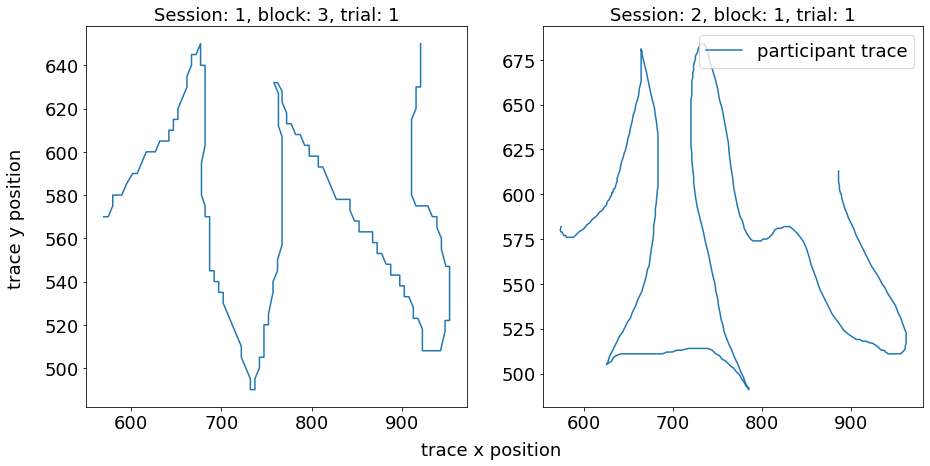

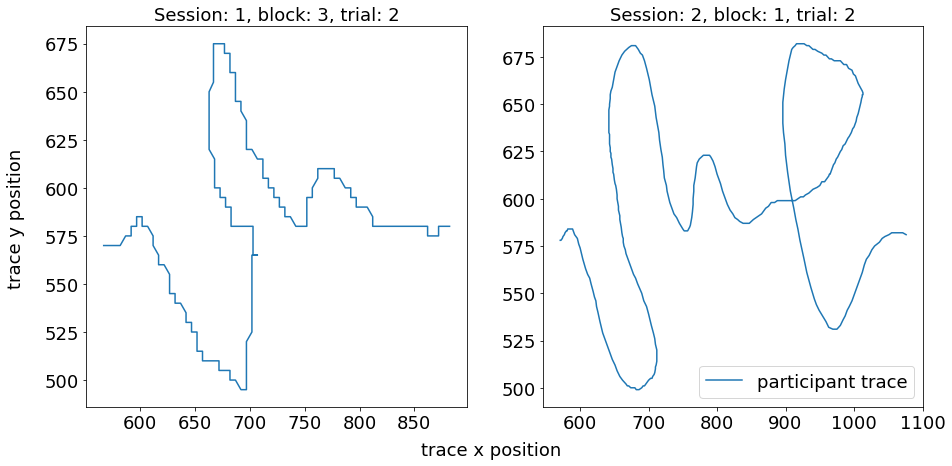

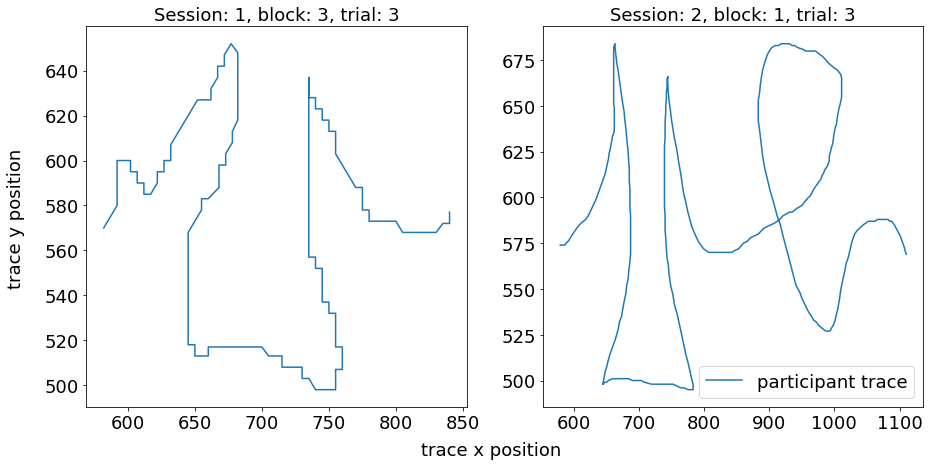

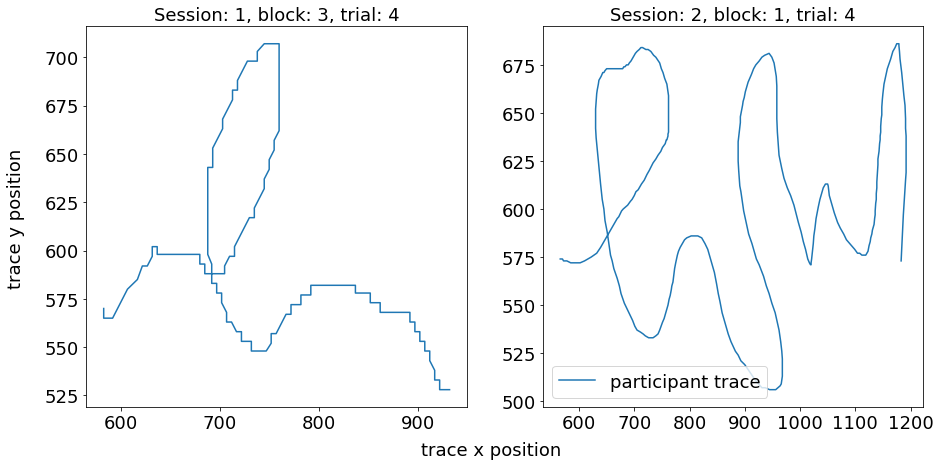

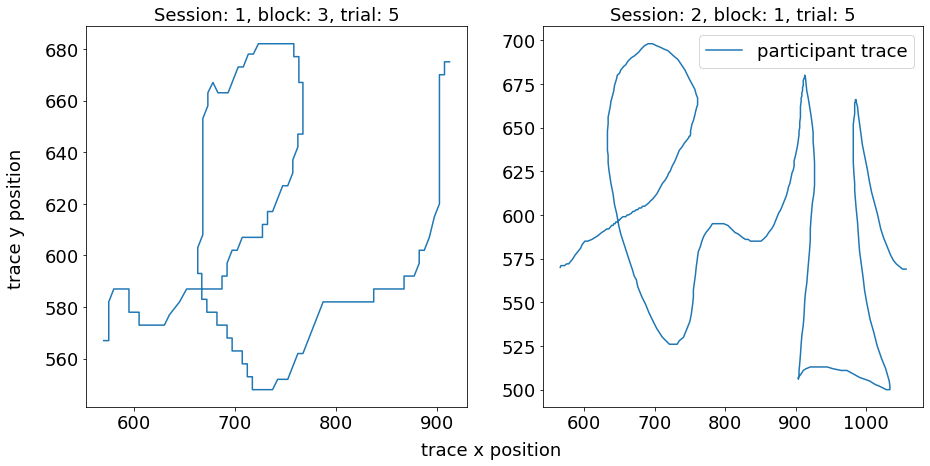

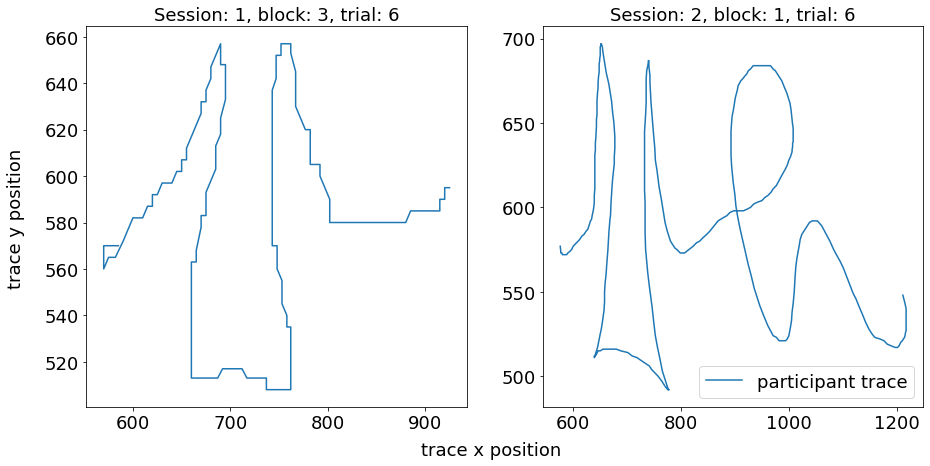

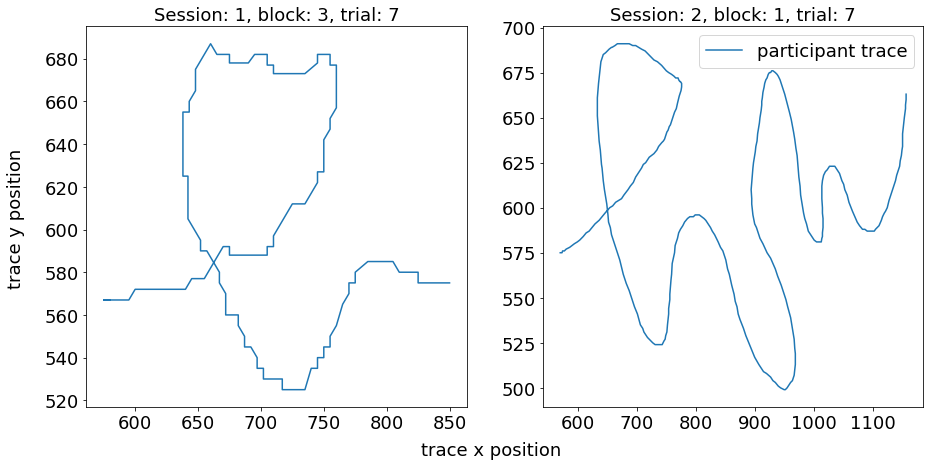

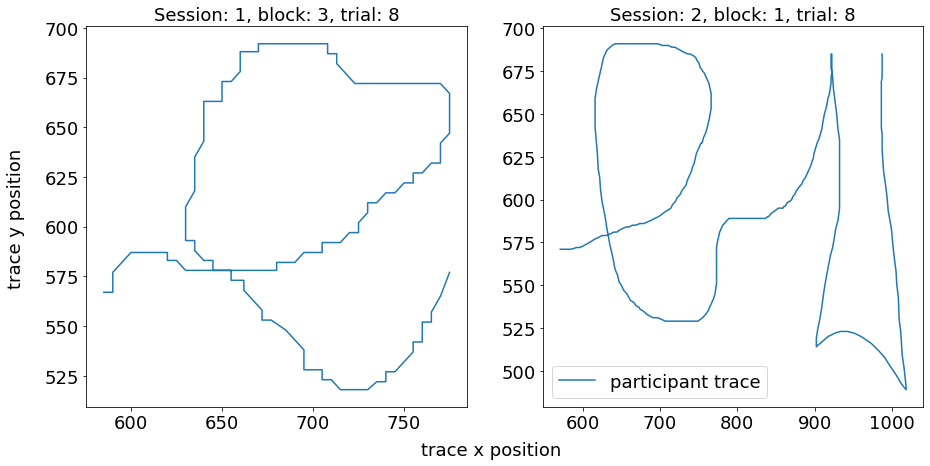

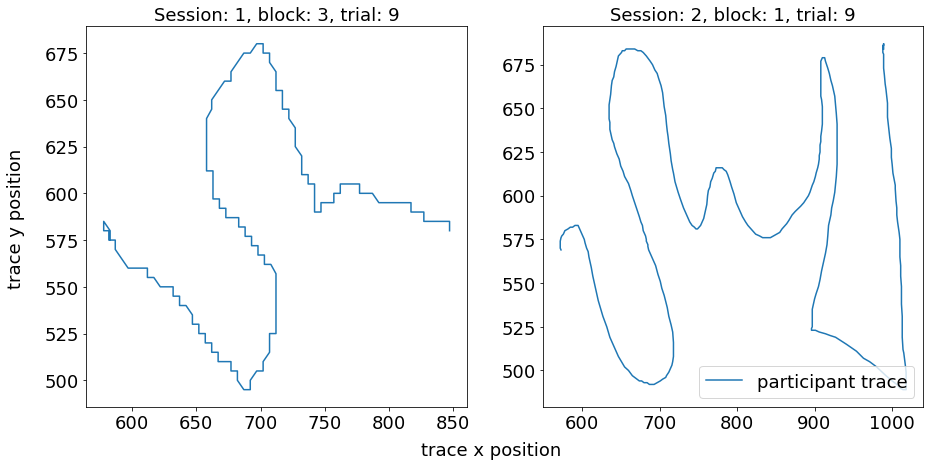

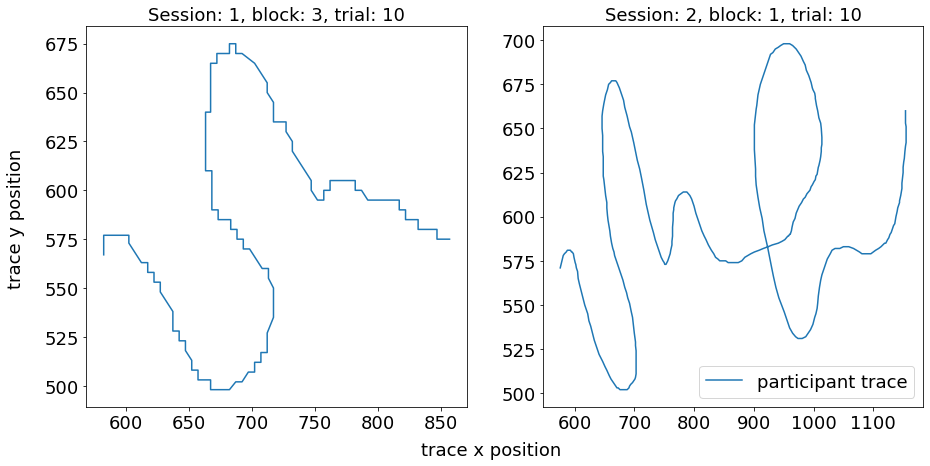

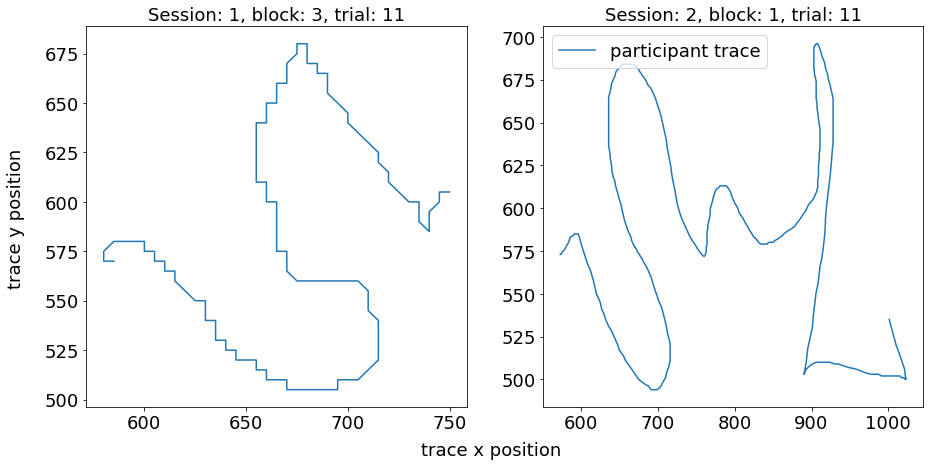

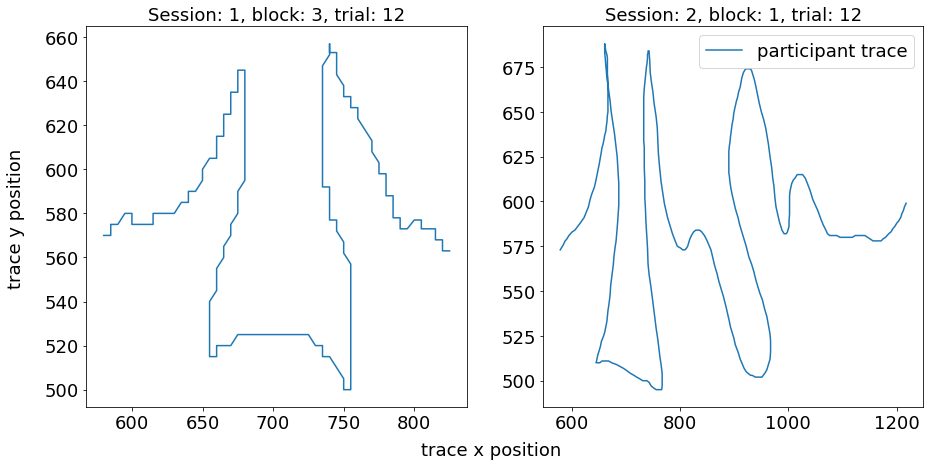

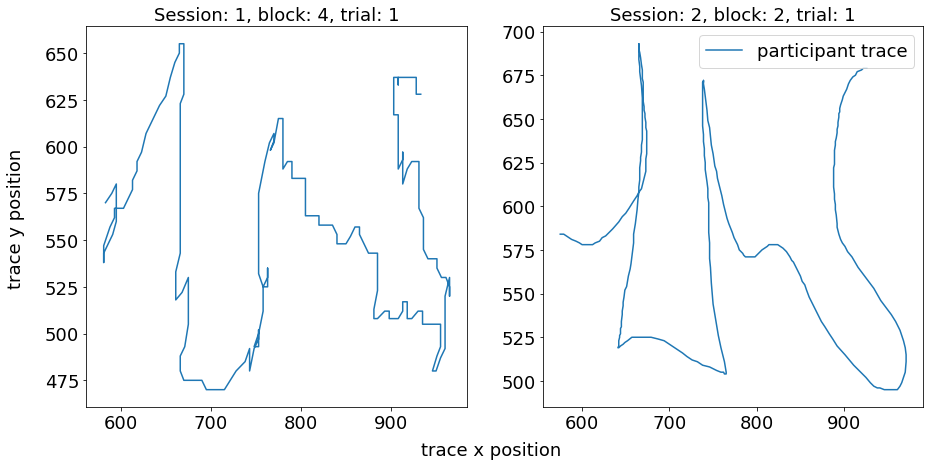

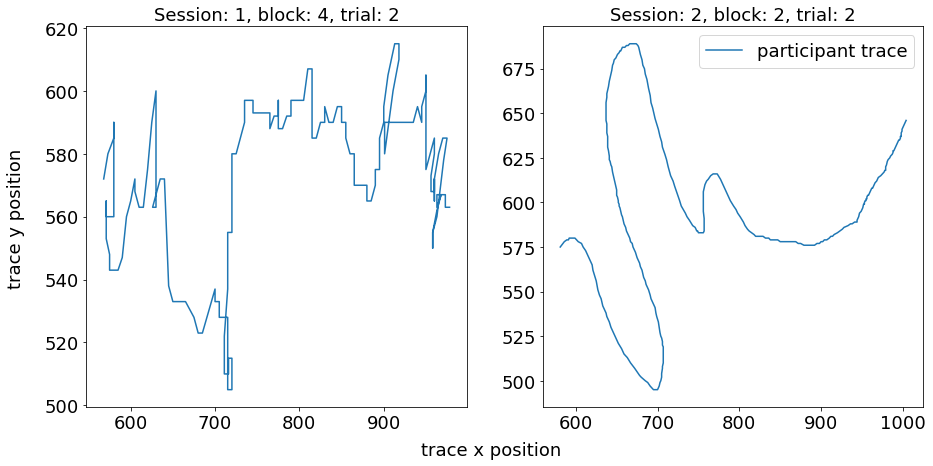

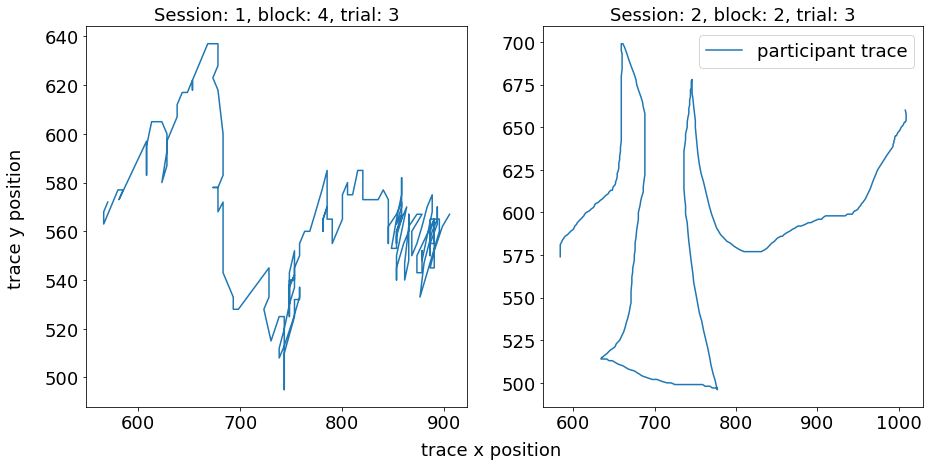

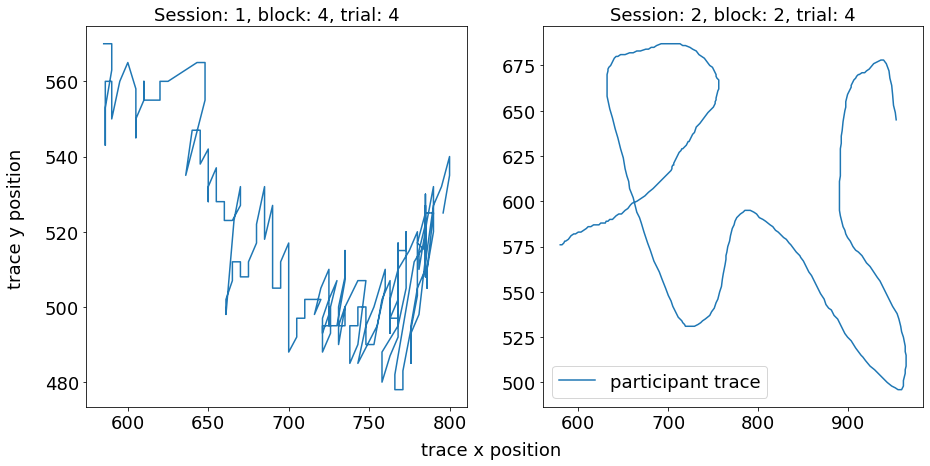

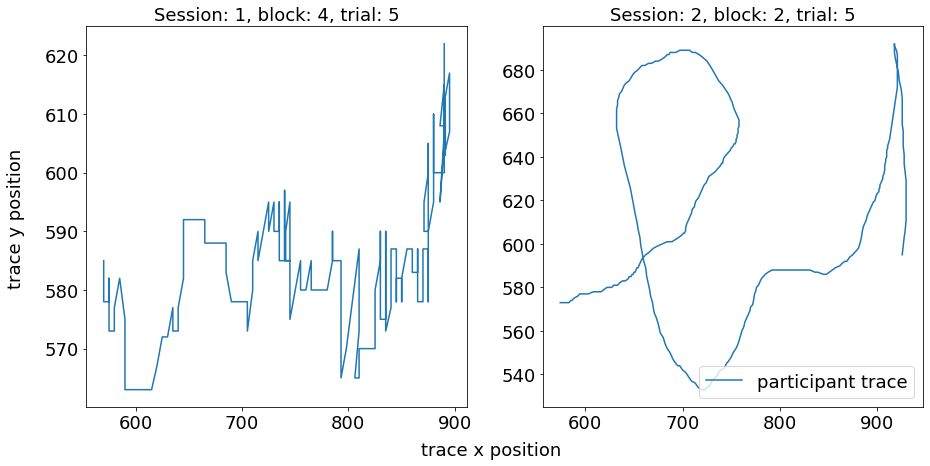

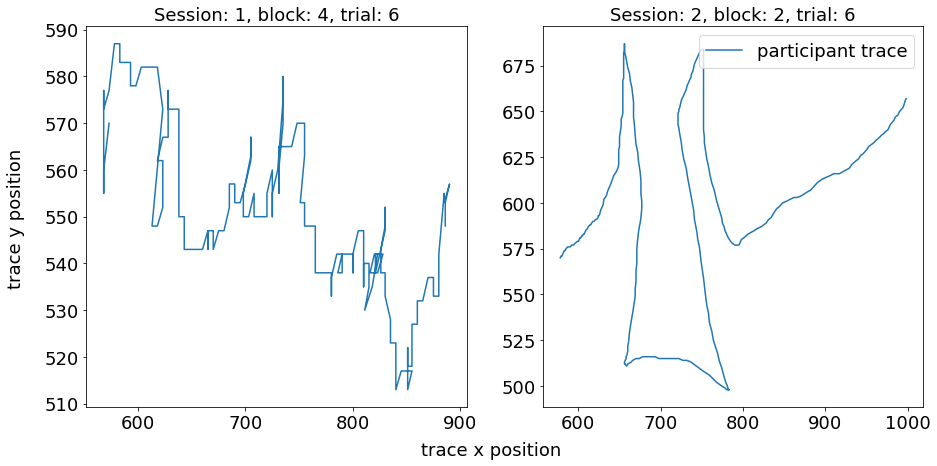

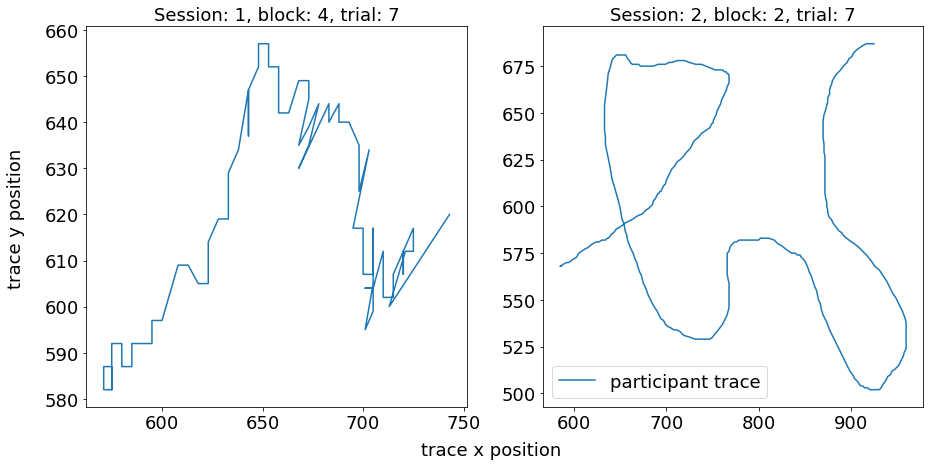

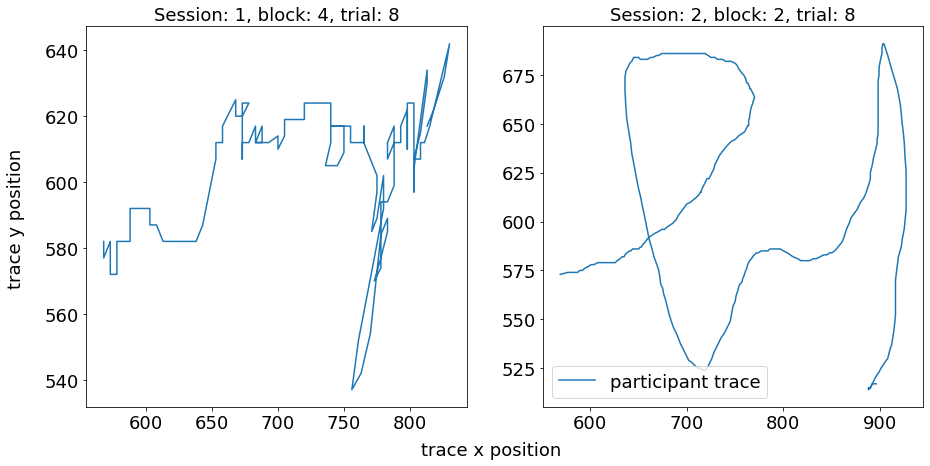

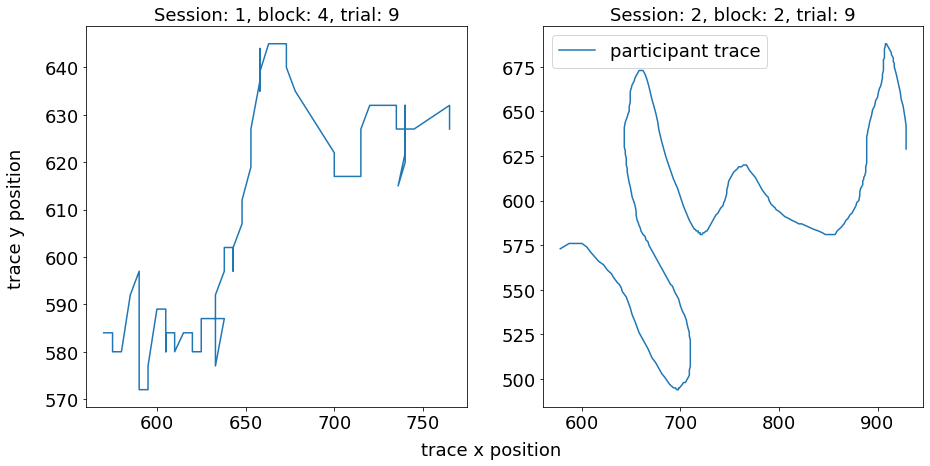

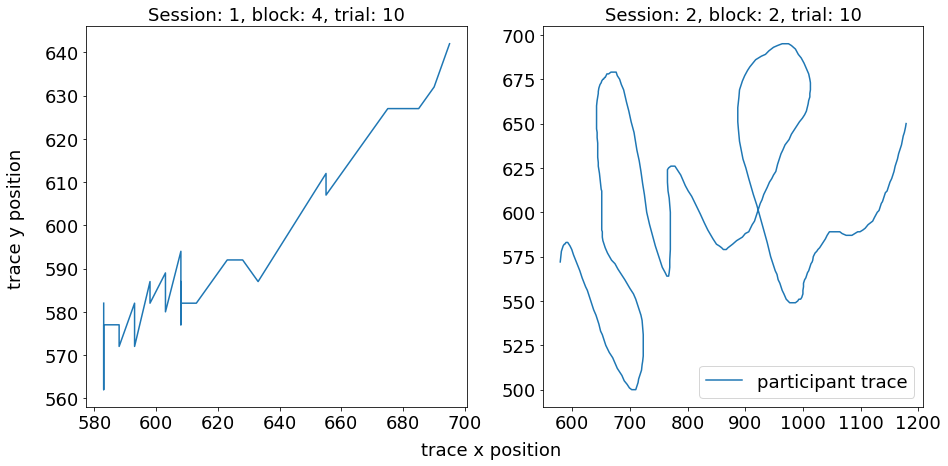

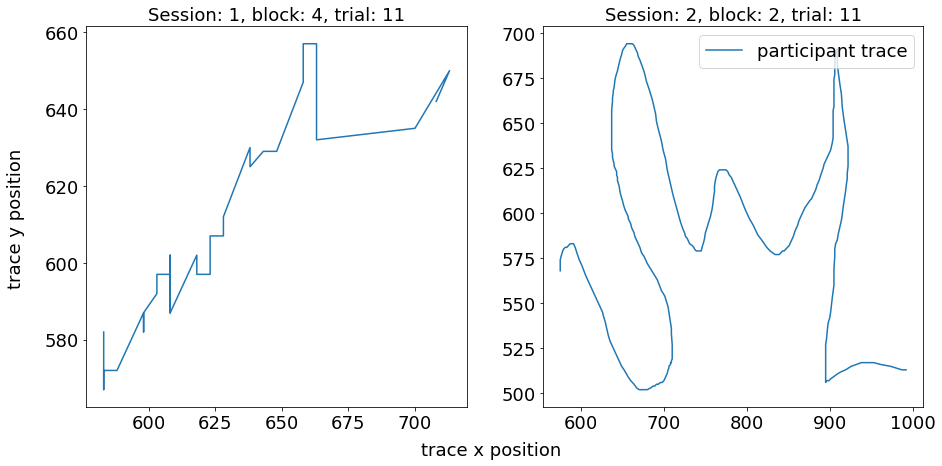

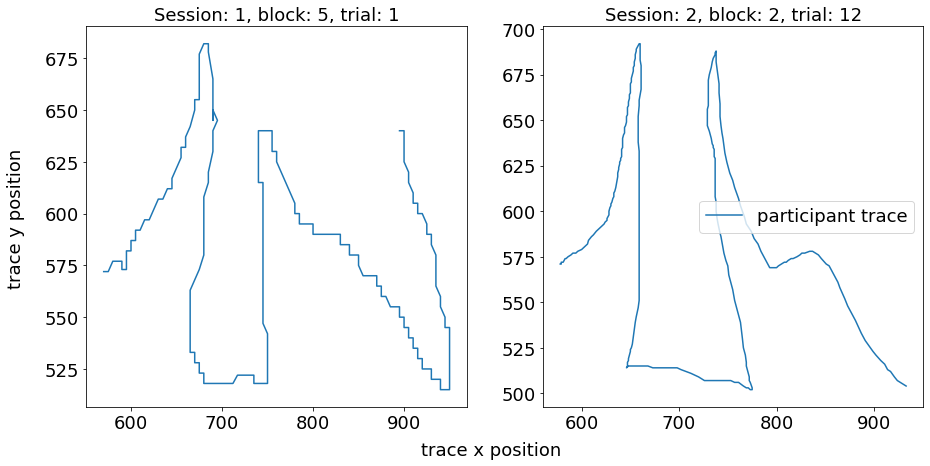

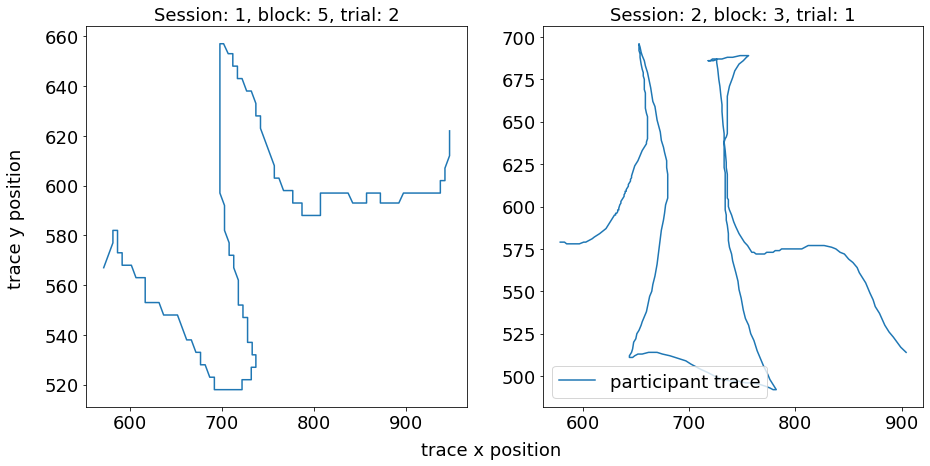

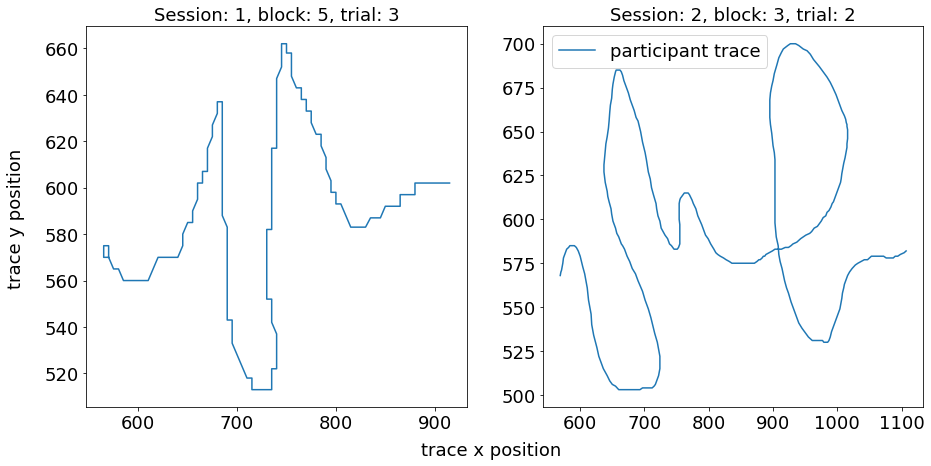

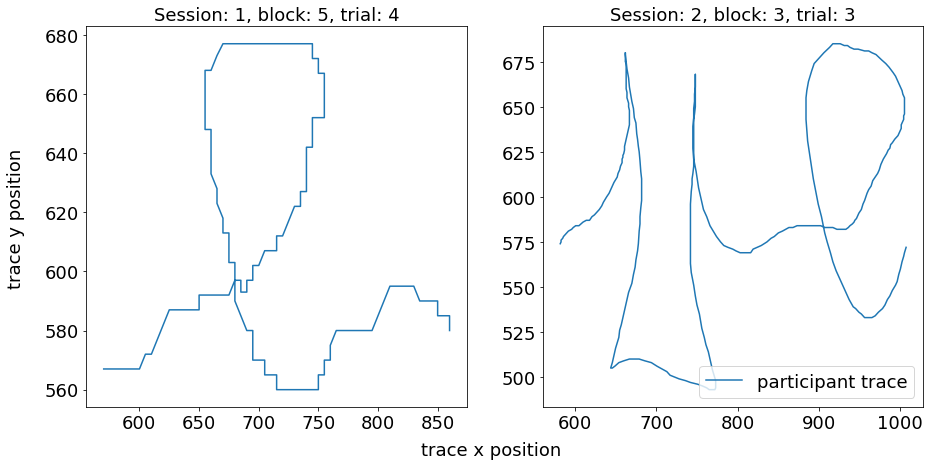

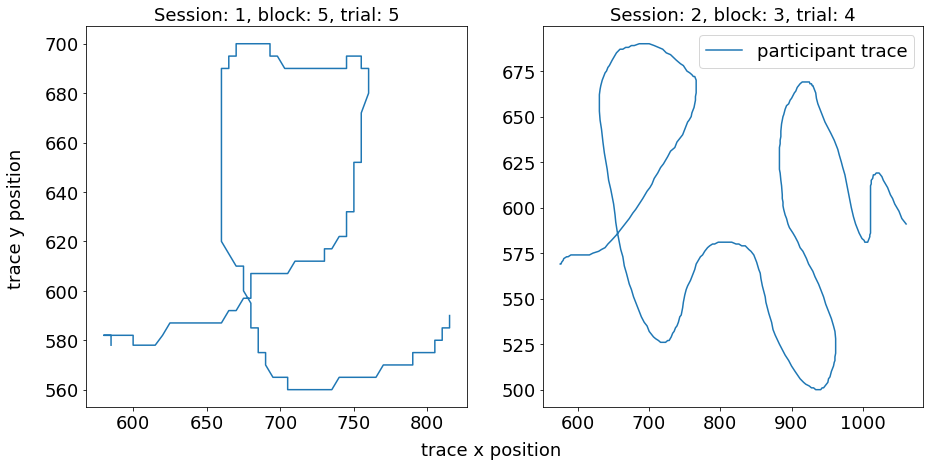

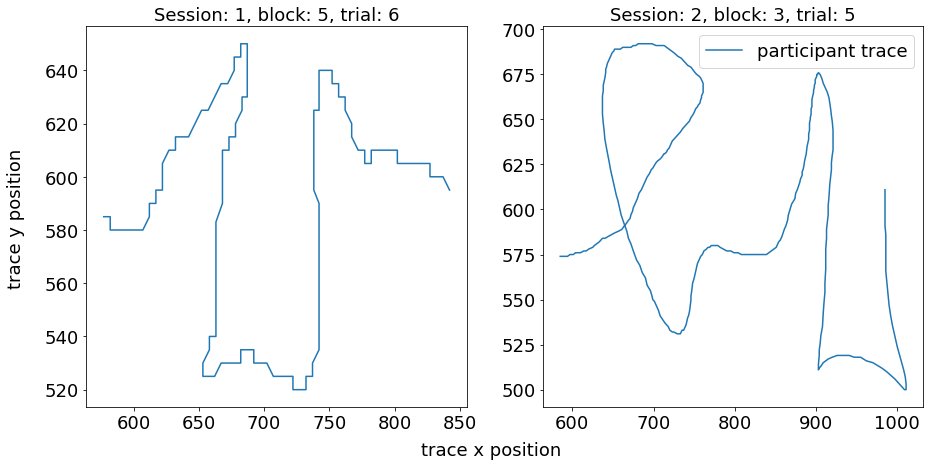

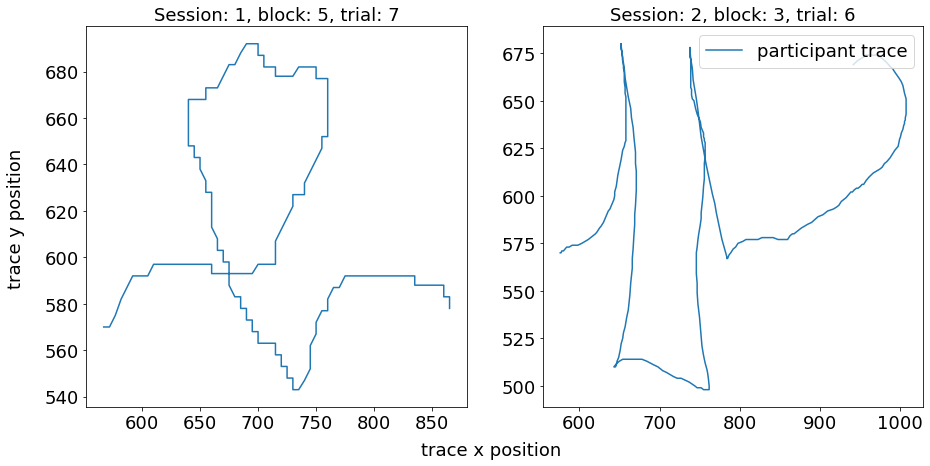

In [7]:
# plot some trials of session 1 and session 2
for k in range(30):
    fig, axs = plt.subplots(1,2, figsize = (15,7))    
    axs = axs.ravel()
    for i, session in enumerate(d_frames[:2]):
        axs[i].plot(session.iloc[k]['pos_t'][:,0], session.iloc[k]['pos_t'][:,1], label = 'participant trace')
        axs[i].set_title("Session: %d, block: %d, trial: %d" % (i+1, session.iloc[k]['ix_block'], session.iloc[k]['ix_trial'] ))
    fig.text(0.5, 0.04, 'trace x position', ha='center', va='center')
    fig.text(0.06, 0.5, 'trace y position', ha='center', va='center', rotation='vertical')
    plt.legend() 
    plt.show()

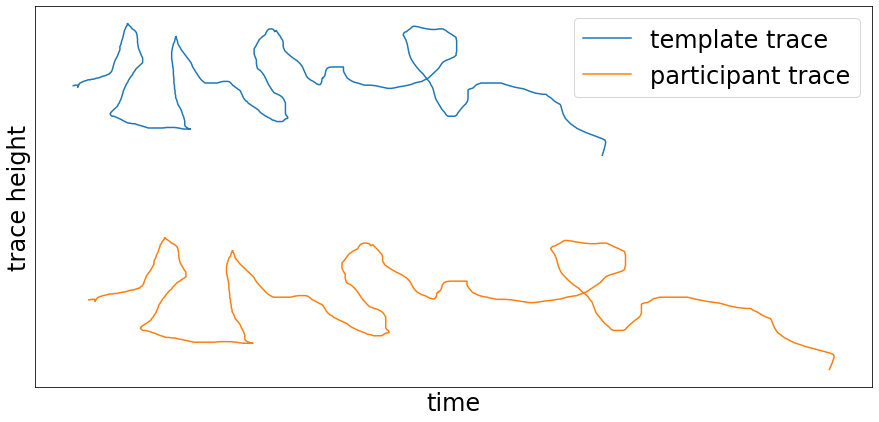

In [8]:
# plot example to be used to explain DTW
position = d_frames[5].iloc[0]['pos_t']
fig, ax = plt.subplots(1,1,figsize = (15,7))
ax.plot(position[:,0], position[:,1], label = 'template trace')
ax.plot(position[:,0]*1.4 - 200, position[:,1]-400, label = 'participant trace')
ax.legend(fontsize = 24)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_xlabel("time", fontsize = 24)
ax.set_ylabel("trace height", fontsize = 24)
fig.savefig("dtw_example")
plt.show()


In [9]:
# merge different sessions into one dataframe
df_sessionlog = pd.concat(d_frames[1:]).reset_index()

In [11]:
# load and process DTW mapping
fn = '/Users/jozef/Jupyter/Signal_Processing/DBS/data\\dtw_opti_paths_df.p'
with open(fn, 'rb') as fid:
    opti_paths = pickle.load(fid)
opti_paths = opti_paths.assign(block = opti_paths['block'].astype(int))
opti_paths = opti_paths.assign(trial = opti_paths['trial'].astype(int))
remove_s = pd.Series([x[1:] for x in opti_paths['session']])
opti_paths = opti_paths.assign(session = remove_s.astype(int))

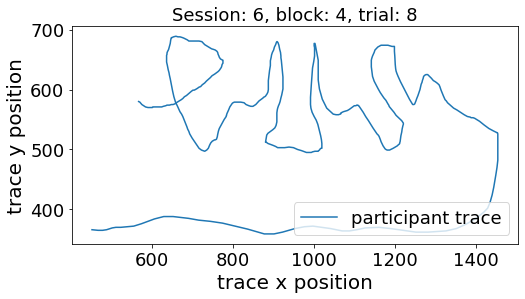

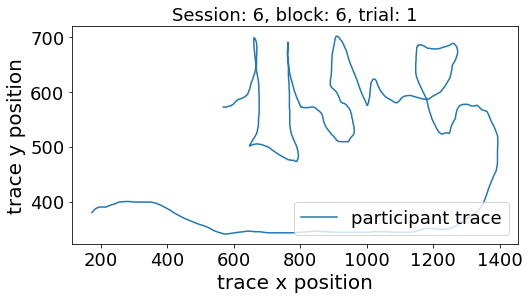

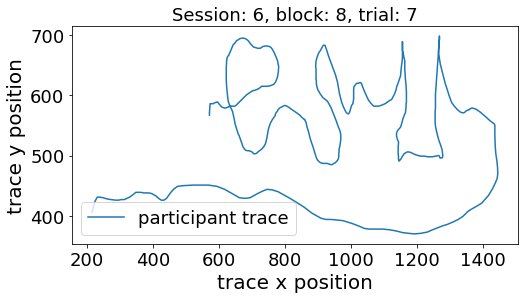

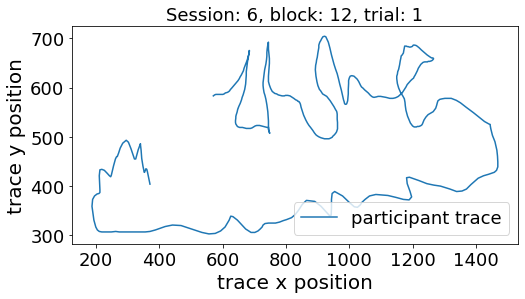

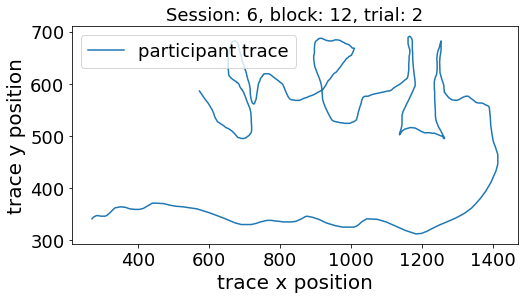

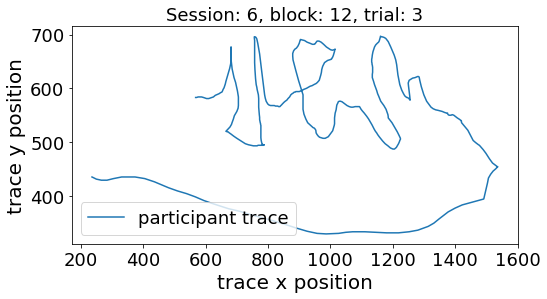

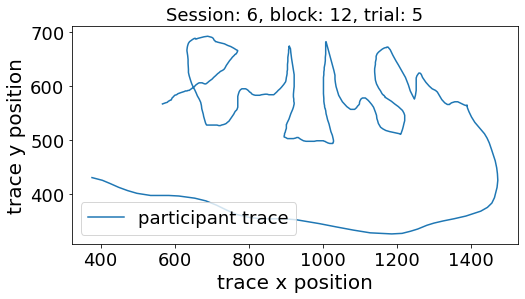

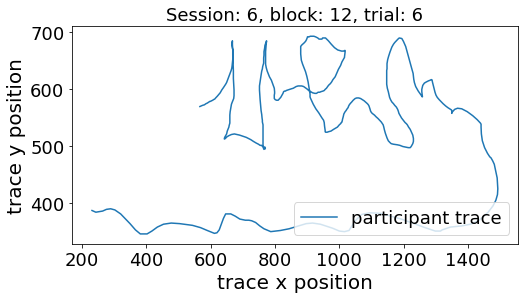

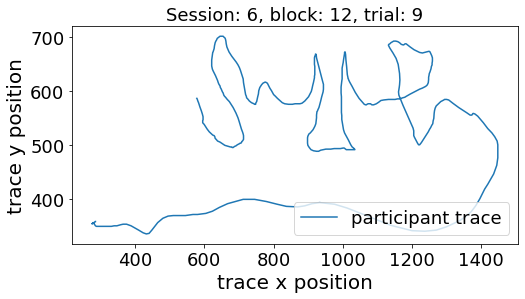

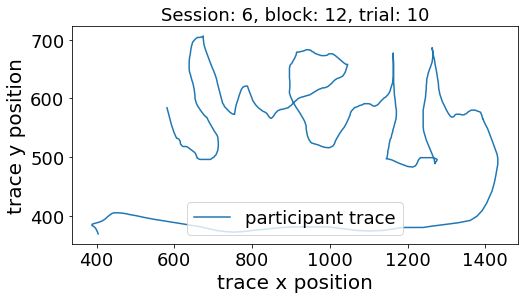

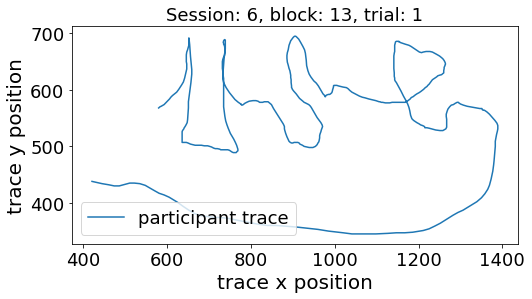

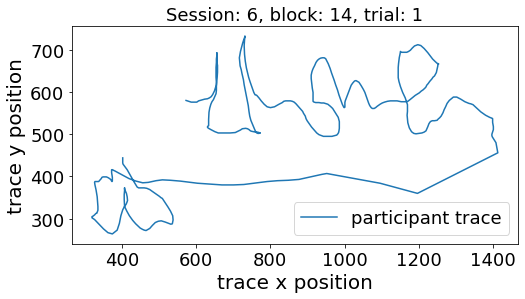

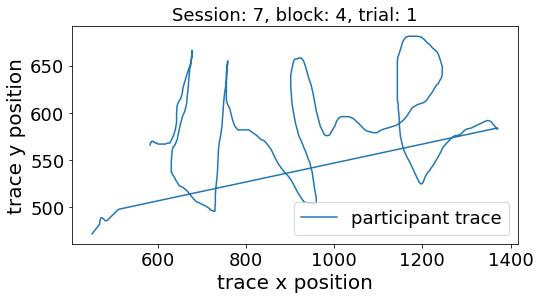

In [12]:
# plot trials with distance 0
for row in df_sessionlog[df_sessionlog['dist_t'].map(len) < 2].iterrows():    
    plt.figure(figsize=(8, 4))
    plt.plot(row[1]['pos_t'][:,0], row[1]['pos_t'][:,1], label = 'participant trace')   
    plt.title("Session: %d, block: %d, trial: %d" % (row[1]['session'], 
                                                     row[1]['ix_block'], row[1]['ix_trial']))
    plt.xlabel('trace x position')
    plt.ylabel('trace y position')
    plt.legend()
    plt.show()

In [13]:
# Remove trials with distance length 0
df_sessionlog = df_sessionlog[df_sessionlog['dist_t'].map(len) > 1]
df_sessionlog = df_sessionlog[~df_sessionlog[['session', 'ix_block']].apply(tuple, axis=1).isin([(6,12)])]

In [14]:
def generate_direction_labels(speed: list) -> list:
    """
    Function that generates a list of direction bind from the speed_t vector
    
    @params speed_t: the speed vectors 
    @returns labels: the direction bins
    """
    y = speed[:,1]
    x = speed[:,0]
    radians = np.arctan2(y,x) % (2*np.pi)
    labels = []
    for k, rad in enumerate(radians):        
        for i in range(8):
            if i * np.pi / 4 <= rad < (i + 1) * np.pi / 4:
                labels.append(i+1)
                continue                
    return labels

In [15]:
def create_directed_df(df_sessionlog, opti_paths, smoothing = True):
    """
    Function that extracts the directed features from the original session logs. 
    @param df_sessionlog: pandas DataFrame containing the data from the copy-draw task
    @param opti_paths: pandas DataFrame containing the dynamic time warp mapping to be used for distance binning
    @param smoothin: whether to smooth the speed_t feature 
    
    @returns d_frame: the dataframe containing the directed features
    """
    feats = ['speed_t', 'accel_t', 'jerk_t']
    data = {}
    copy_feats = ['session', 'stim', 'ix_block', 'startTStamp']
    
    for feat in copy_feats:
        data[feat] = []
        
    for feat in feats + ['dist']:
        for d_bin in range(1,9):
            col_name = feat + '_' + str(d_bin)
            data[col_name] = []
            
    data['ix_trial'] = []

    for index, row in df_sessionlog.iterrows():
        ix_trial = int(np.squeeze(row['ix_trial']))
        ix_block = row['ix_block']
        session = row['session']       
        if smoothing:
            y = pd.Series(row['speed_t'][:,1]).rolling(7, min_periods = 1, center=True).mean()
            x = pd.Series(row['speed_t'][:,0]).rolling(7, min_periods = 1, center=True).mean()   
        
            row['speed_t'] = np.column_stack((x,y))
        
        for f in copy_feats:            
            data[f].append(int(row[f])) 
        
        data['ix_trial'].append(ix_trial)  

        direction_bins = generate_direction_labels(row['speed_t'])
        for i, feat in enumerate(feats):
            # needed because accel is undefined on s_1  and jerk on s_1/s_2
            labels = np.array(direction_bins[i:])         
            feature_row = row[feat]
            for d_bin in range(1,9):
                col_name = feat + '_' + str(d_bin)               

                # Get features in one bin
                binned_feature = feature_row[labels == d_bin]
                magnitudes = np.linalg.norm(binned_feature, axis = 1)
                
                if len(magnitudes) == 0:
                    data[col_name].append(float('nan'))
                else:                    
                    mean = np.mean(magnitudes)
                    data[col_name].append(mean)                       

        mapping = np.array(opti_paths[(opti_paths.session == session) & 
                             (opti_paths.block == ix_block) &
                             (opti_paths.trial == ix_trial)].iloc[0]['optimal_path'][0][0][:row['pathlen']], dtype = np.intc) 
        
        # add empty bin for dist_that maps to last tracelet with undefined speed.
        direction_bins = np.insert(direction_bins,0, 999)
        
        # -1 since index seems to start at 1
        dist_labels = np.array(direction_bins)[mapping[:,1]-1]   
        
        dists = np.squeeze(row['dist_t'])        
        dist_bins = np.column_stack((dist_labels, dists))       
        

        for d_bin in range(1,9):
            col_name = 'dist' + '_' + str(d_bin)
            
            directional_dist = dist_bins[dist_bins[:,0] == d_bin][:,1]
            
            if len(directional_dist) == 0:                
                data[col_name].append(float('nan'))
            else:
                mean = np.mean(directional_dist)
                data[col_name].append(mean)
                
    na_frame = DataFrame(data=data)
    d_frame = DataFrame(columns = na_frame.columns)
    
    # fill empty bins with average onf the session
    for _, group in na_frame.groupby('session'):  
        d_frame = d_frame.append(group.fillna(group.mean()), ignore_index = True)        
    
    return d_frame

In [68]:
def create_undirected_df(df_sessionlog):
    """
    Function that extracts the undirected features from the original session logs. 
    @param df_sessionlog: pandas DataFrame containing the data from the copy-draw task    
        
    @returns d_frame: the dataframe containing the undirected features
    """
    feats = ['speed_t', 'accel_t', 'jerk_t']
    data = {}
    copy_feats = ['session', 'stim', 'ix_block', 'startTStamp']
    
    for feat in copy_feats:
        data[feat] = []
        
    for feat in feats + ['dist']:          
        data[feat] = []
            
    data['ix_trial'] = []
    
    for index, row in df_sessionlog.iterrows():
        ix_trial = int(np.squeeze(row['ix_trial']))
        ix_block = row['ix_block']
        session = row['session']
        
        for f in copy_feats:            
            data[f].append(int(row[f]))
        
        data['ix_trial'].append(ix_trial)  
        # calculate direction bins
        direction_bins = generate_direction_labels(row['speed_t'])
        for i, feat in enumerate(feats):
            # needed because accel is undefined on s_1  and jerk on s_1/s_2
            labels = np.array(direction_bins[i:])         
            feature_row = row[feat]            

            # compute vector magnitudes
            magnitudes = np.linalg.norm(feature_row, axis = 1)
            
            # should never happen in the undirected features
            if len(magnitudes) == 0:
                data[feat].append(float('nan'))
            else:
                mean = np.mean(magnitudes)
                data[feat].append(mean)
        data['dist'].append(np.mean(row['dist_t']))   
    
    return DataFrame(data=data)

In [17]:
unsmoothened_df = create_directed_df(df_sessionlog, opti_paths, smoothing = False)

In [18]:
directed_df = create_directed_df(df_sessionlog, opti_paths)

In [69]:
undirected_df = create_undirected_df(df_sessionlog)

In [20]:
directed_df.to_csv('data/directed_features.csv',index=False)

In [21]:
undirected_df.to_csv('data/undirected_features.csv',index=False)

In [22]:
whole_df = directed_df.merge(undirected_df)

In [23]:
whole_df.to_csv('data/all_features.csv',index=False)

In [24]:
def create_directed_sub_trial_df(df_sessionlog, opti_paths):
    """
    Function that extracts the directed features from the original session logs, and creates the sub-trials. 
    
    @param df_sessionlog: pandas DataFrame containing the data from the copy-draw task
    @param opti_paths: pandas DataFrame containing the dynamic time warp mapping to be used for distance binning
    @params subdivisions: controls in how many sub-trials each trial is split
    
    @returns d_frame: the dataframe containing the directed features
    """
    subdivisions = 3
    feats = ['speed_t', 'accel_t', 'jerk_t']
    data = {}
    copy_feats = ['session', 'stim', 'ix_block', 'startTStamp']
    
    for feat in copy_feats:
        data[feat] = []
        
    for feat in feats + ['dist']:
        for d_bin in range(1,9):
            col_name = feat + '_' + str(d_bin)
            data[col_name] = []
            
    data['ix_trial'] = []
    data['sub_trial'] = []
    for index, row in df_sessionlog.iterrows():
        ix_trial = int(np.squeeze(row['ix_trial']))
        ix_block = row['ix_block']
        session = row['session']       
        
        y = pd.Series(row['speed_t'][:,1]).rolling(7, min_periods = 1, center=True).mean()
        x = pd.Series(row['speed_t'][:,0]).rolling(7, min_periods = 1, center=True).mean()
        
        row['speed_t'] = np.column_stack((x,y))
        
        for i in range(subdivisions):
            data['sub_trial'].append(i)
            for f in copy_feats:            
                data[f].append(int(row[f])) 
        
            data['ix_trial'].append(ix_trial)  

        direction_bins = generate_direction_labels(row['speed_t'])
        for i, feat in enumerate(feats):
            # needed because accel is undefined on s_1  and jerk on s_1/s_2
            labels = np.array(direction_bins[i:])         
            feature_row = row[feat]
            
            # split the trial into parts
            splits = zip(np.array_split(labels, subdivisions), np.array_split(feature_row, subdivisions))
            
            for split_labels, split_feature in splits :
                for d_bin in range(1,9):
                    col_name = feat + '_' + str(d_bin)               

                    # Get features in one bin
                    binned_feature = split_feature[split_labels == d_bin]
                    magnitudes = np.linalg.norm(binned_feature, axis = 1)

                    if len(magnitudes) == 0:
                        data[col_name].append(float('nan'))
                    else:                    
                        mean = np.mean(magnitudes)
                        data[col_name].append(mean)                       

        mapping = np.array(opti_paths[(opti_paths.session == session) & 
                             (opti_paths.block == ix_block) &
                             (opti_paths.trial == ix_trial)].iloc[0]['optimal_path'][0][0][:row['pathlen']], dtype = np.intc) 
        
        # add empty bin for dist_that maps to last tracelet with undefined speed.
        direction_bins = np.insert(direction_bins,0, 999)
        
        # -1 since index seems to start at 1
        dist_labels = np.array(direction_bins)[mapping[:,1]-1]   
        
        dists = np.squeeze(row['dist_t'])        
        dist_bins = np.column_stack((dist_labels, dists))       
        
        for split_dist_bins in np.array_split(dist_bins, subdivisions):
            for d_bin in range(1,9):
                col_name = 'dist' + '_' + str(d_bin)

                directional_dist = dist_bins[dist_bins[:,0] == d_bin][:,1]

                if len(directional_dist) == 0:                
                    data[col_name].append(float('nan'))
                else:
                    mean = np.mean(directional_dist)
                    data[col_name].append(mean)
                
    na_frame = DataFrame(data=data)
    d_frame = DataFrame(columns = na_frame.columns)
    
    # fill empty bins with average onf the session
    for _, group in na_frame.groupby('session'):  
        d_frame = d_frame.append(group.fillna(group.mean()), ignore_index = True)        
    
    return d_frame

In [25]:
def create_undirected_sub_trial_df(df_sessionlog, subdivisions = 3):
    """
    Function that extracts the undirected features from the original session logs, and creates the sub-trials. 
    
    @param df_sessionlog: pandas DataFrame containing the data from the copy-draw task.    
    @params subdivisions: controls in how many sub-trials each trial is split.
    
    @returns the dataframe containing the undirected features.
    """
    
    feats = ['speed_t', 'accel_t', 'jerk_t']
    data = {}
    copy_feats = ['session', 'stim', 'ix_block', 'startTStamp']
    
    for feat in copy_feats:
        data[feat] = []
        
    for feat in feats + ['dist']:          
        data[feat] = []
            
    data['ix_trial'] = []
    data['sub_trial'] = []
    for index, row in df_sessionlog.iterrows():
        ix_trial = int(np.squeeze(row['ix_trial']))
        ix_block = row['ix_block']
        session = row['session']
        
        for i in range(subdivisions):
            data['sub_trial'].append(i)
            for f in copy_feats:            
                data[f].append(int(row[f])) 
        
            data['ix_trial'].append(ix_trial)  

        
        for i, feat in enumerate(feats):                     
            feature_row = row[feat]            
            magnitudes = np.linalg.norm(feature_row, axis = 1)            

            for split in np.array_split(magnitudes, subdivisions):

                if len(split) == 0:
                    data[feat].append(float('nan'))                    
                else:             
                    data[feat].append(np.mean(split))
                
        for split in np.array_split(row['dist_t'], subdivisions):
            if len(split) == 0:
                print(session, ix_block ,ix_trial)
            data['dist'].append(np.mean(split))   
    
    return DataFrame(data=data)

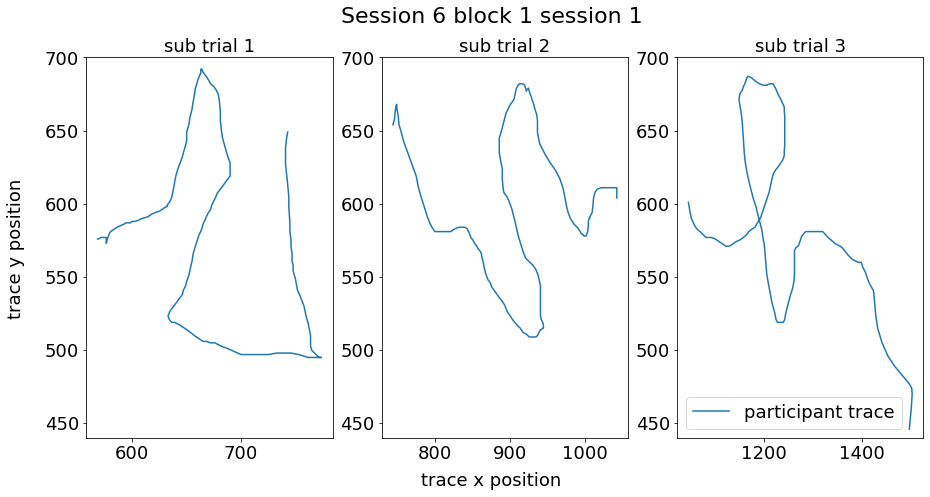

In [26]:
# plot sub-trial example
fig, axs = plt.subplots(1,3, figsize = (15, 7))

axs = axs.ravel()
xs = np.array_split( d_frames[5].iloc[0]['pos_t'][:,0], 3)
ys = np.array_split( d_frames[5].iloc[0]['pos_t'][:,1], 3)
fig.suptitle('Session 6 block 1 session 1')
for i in range(3):
    axs[i].plot(xs[i], ys[i], label = 'participant trace')
    axs[i].set_ylim(440, 700)
    axs[i].set_title('sub trial ' + str(i + 1))
plt.legend()    
fig.text(0.5, 0.04, 'trace x position', ha='center', va='center')
fig.text(0.06, 0.5, 'trace y position', ha='center', va='center', rotation='vertical')

fig.savefig('sub_trial_example')

In [27]:
directed_sub_trial_df = create_directed_sub_trial_df(df_sessionlog, opti_paths)

In [28]:
directed_sub_trial_df.to_csv('data/directed_sub_trial_df.csv',index=False)

In [29]:
undirected_sub_trial_df = create_undirected_sub_trial_df(df_sessionlog, opti_paths)

In [30]:
undirected_sub_trial_df.to_csv('data/undirected_sub_trial_df.csv',index=False)

In [31]:
whole_sub_trial_df = directed_sub_trial_df.merge(undirected_sub_trial_df)

In [32]:
whole_sub_trial_df.to_csv('data/all_features_sub_trial.csv',index=False)

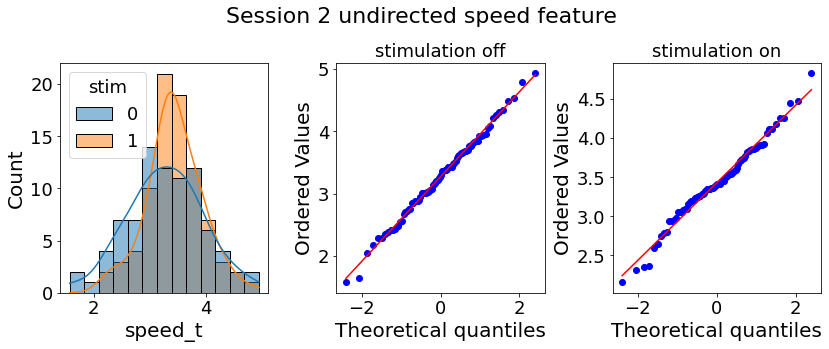

In [42]:
# Plot session 2 undirected speed distribution and QQ plots
fig, axs = plt.subplots(1,3, figsize=(12,5))
axs = axs.ravel()
data = undirected_df[undirected_df['session'] == 2]
fig.suptitle("Session 2 undirected speed feature")
sns.histplot(data = data, x='speed_t', hue='stim', kde = True, ax=axs[0])
fig.tight_layout(pad=1.0)
probplot(data['speed_t'][data['stim'] == 0], plot = axs[1])
axs[1].set_title('stimulation off')
probplot(data['speed_t'][data['stim'] == 1], plot = axs[2])
axs[2].set_title('stimulation on')

fig.savefig("undirected_sesh2_speed_t")

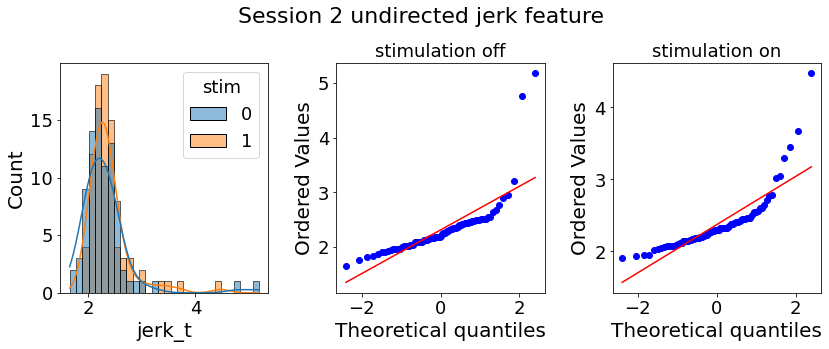

In [43]:
# Plot session 2 undirected jerk distribution and QQ plots
fig, axs = plt.subplots(1,3, figsize=(12,5))
axs = axs.ravel()
data = undirected_df[undirected_df['session'] == 2]
fig.suptitle("Session 2 undirected jerk feature")
sns.histplot(data = data, x='jerk_t', hue='stim', kde = True, ax=axs[0])
fig.tight_layout(pad=1.0)
probplot(data['jerk_t'][data['stim'] == 0], plot = axs[1])
axs[1].set_title('stimulation off')
probplot(data['jerk_t'][data['stim'] == 1], plot = axs[2])
axs[2].set_title('stimulation on')

fig.savefig("undirected_sesh2_jerk_t")

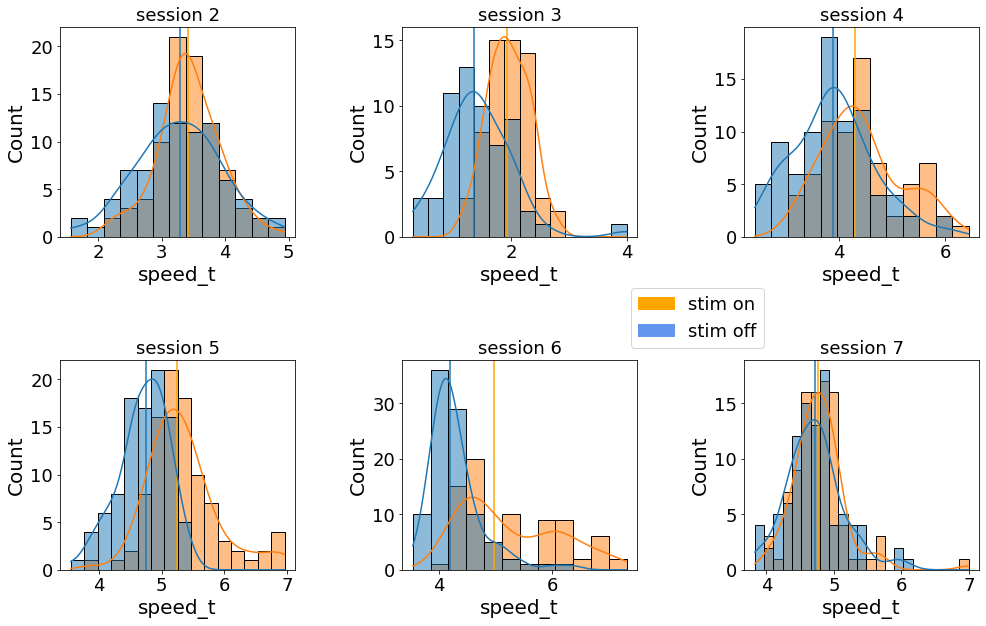

In [38]:
# Plot undirected speed features
fig, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.ravel()

for index, (name, group) in enumerate(undirected_df.groupby('session')):      
    median_0 = group[group['stim']==0]['speed_t'].median()
    median_1 = group[group['stim']==1]['speed_t'].median()
    axs[index].axvline(x=median_0)
    axs[index].axvline(x=median_1, color = 'orange')
    sns.histplot(data = group, x='speed_t', hue='stim', kde = True, ax=axs[index], legend=False).set_title('session ' + str(name))
    
fig.tight_layout(pad=3.0)    
orange_patch = mpatches.Patch(color='orange', label = 'stim on')
blue_patch = mpatches.Patch(color='cornflowerblue', label = 'stim off')
plt.legend(handles = [orange_patch, blue_patch], bbox_to_anchor=(-0.2, 1.2), loc='center')
plt.show()
fig.savefig('undirected_speed_t_all_sesh')

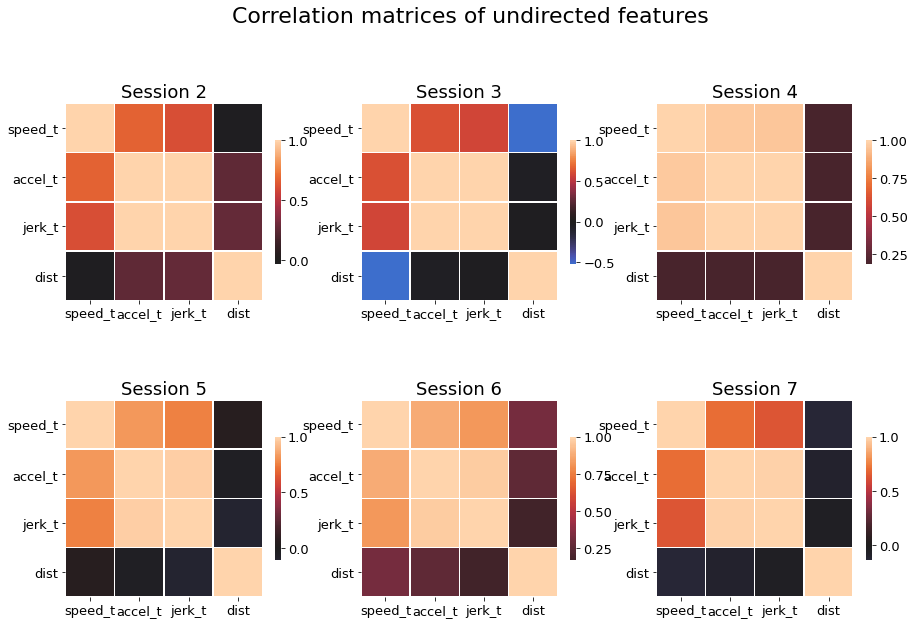

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [53]:
# Plot correlation matrices of the undirected features
from matplotlib.pyplot import figure
plt.rc('xtick', labelsize=13)    
plt.rc('ytick', labelsize=13)

fig, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.ravel()

for name, group in undirected_df.groupby('session'):
    features = group.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
    figure(figsize=(10, 10), dpi=80)
    sns.heatmap(features.corr(), vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = axs[name-2]).set_title("Session " + str(name))
fig.suptitle("Correlation matrices of undirected features")
fig.savefig('undirected_feature_corr')
plt.show()

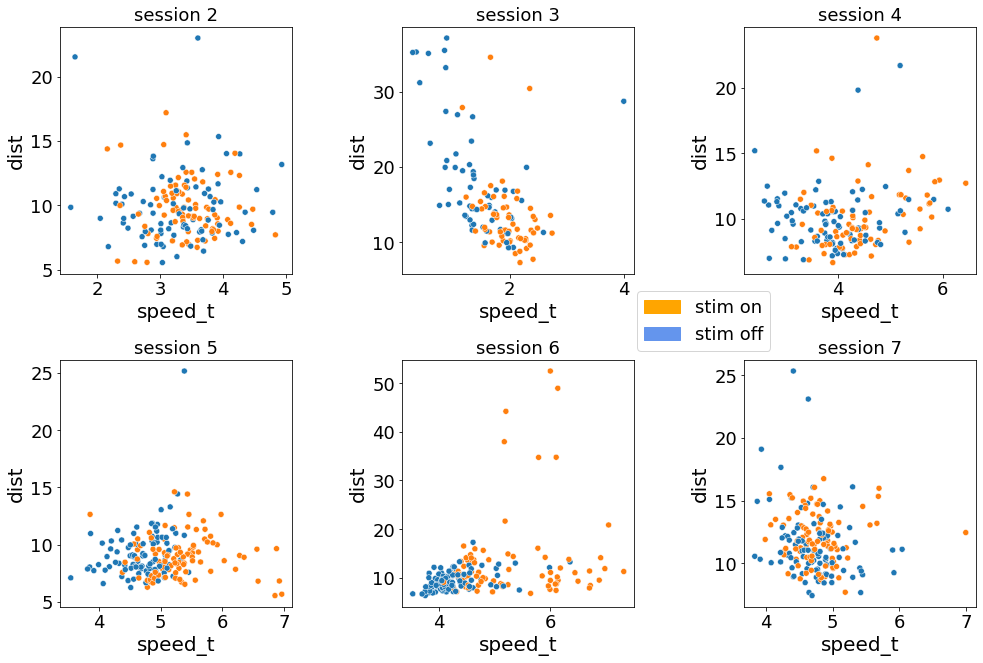

In [39]:
# plot speed versus distance
fig, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.ravel()
fig.tight_layout(pad=3.0)
for index, (name, group) in enumerate(undirected_df.groupby('session')):   
    
    sns.scatterplot(data = group, x='speed_t',y='dist',hue = 'stim', ax = axs[index], legend = False).set_title('session ' + str(name))
    
orange_patch = mpatches.Patch(color='orange', label = 'stim on')
blue_patch = mpatches.Patch(color='cornflowerblue', label = 'stim off')
plt.legend(handles = [orange_patch, blue_patch], bbox_to_anchor=(-0.5, 1), loc='lower left')
fig.savefig('undirected_scatter_all_sesh')
plt.show()

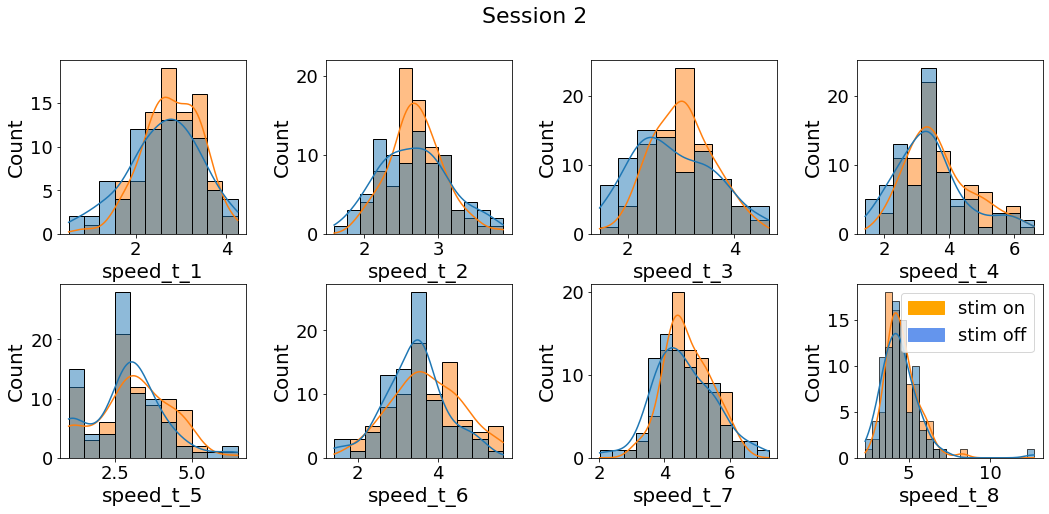

In [44]:
# plot session 2 directed speed features
from scipy.stats import probplot
features = unsmoothened_df[unsmoothened_df['session'] == 2].drop(['session', 'ix_block', 'ix_trial', 'startTStamp'], axis =1)
fig, axs = plt.subplots(2,4, figsize=(15,7))
axs = axs.ravel()
fig.suptitle('Session 2')
fig.tight_layout(pad=1.0)

for i in range (9):
    if features.columns[i] != 'stim':
        sns.histplot(data = features, x=features.columns[i], 
                             hue='stim', kde = True, ax=axs[i-1], legend = False)
orange_patch = mpatches.Patch(color='orange', label = 'stim on')
blue_patch = mpatches.Patch(color='cornflowerblue', label = 'stim off')
axs[-1].legend(handles = [orange_patch, blue_patch])   
fig.savefig('directed_speed_t_sesh_2')

session 2


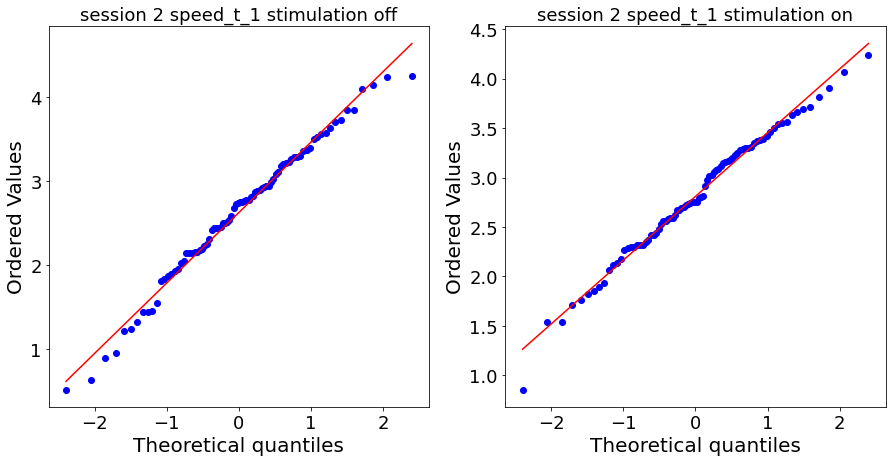

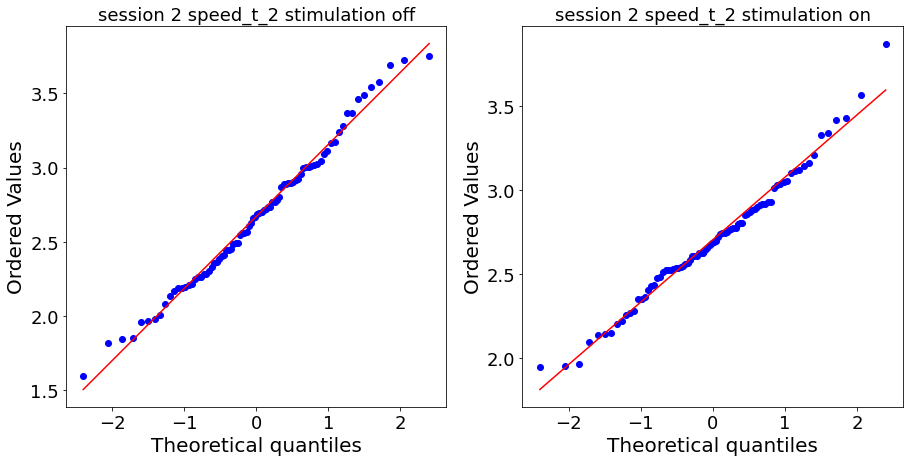

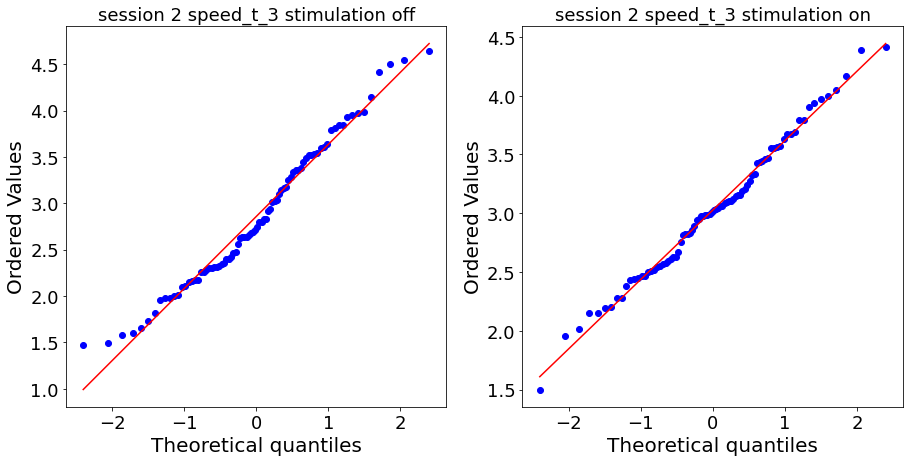

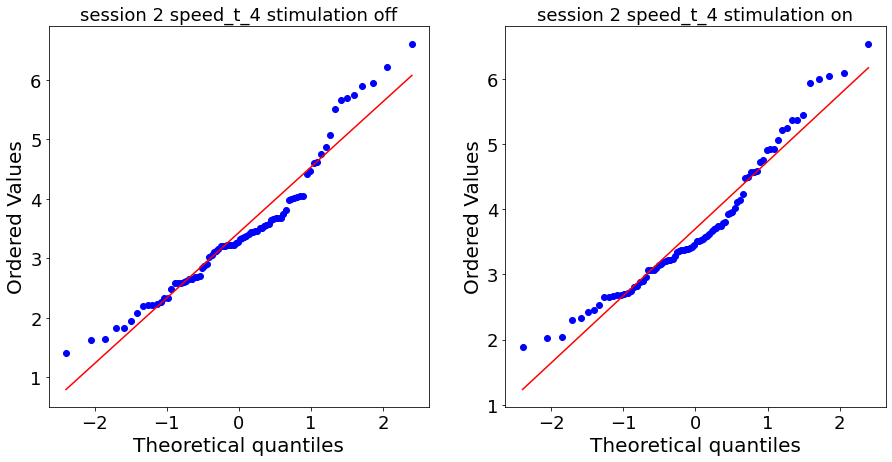

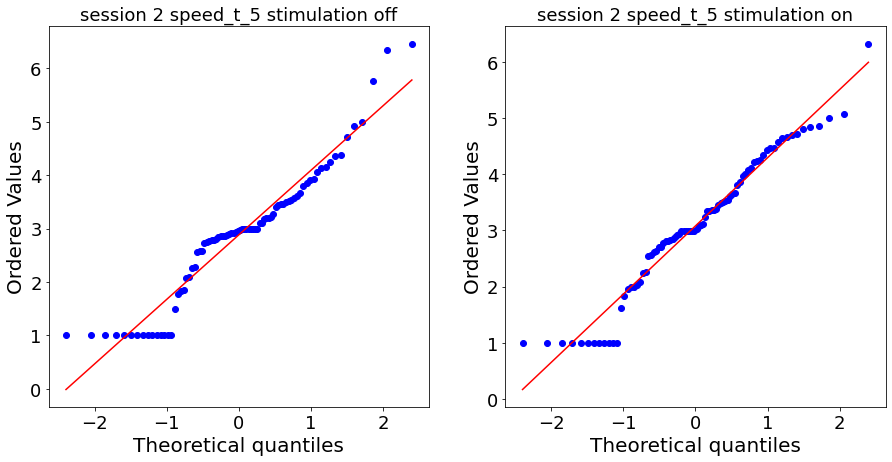

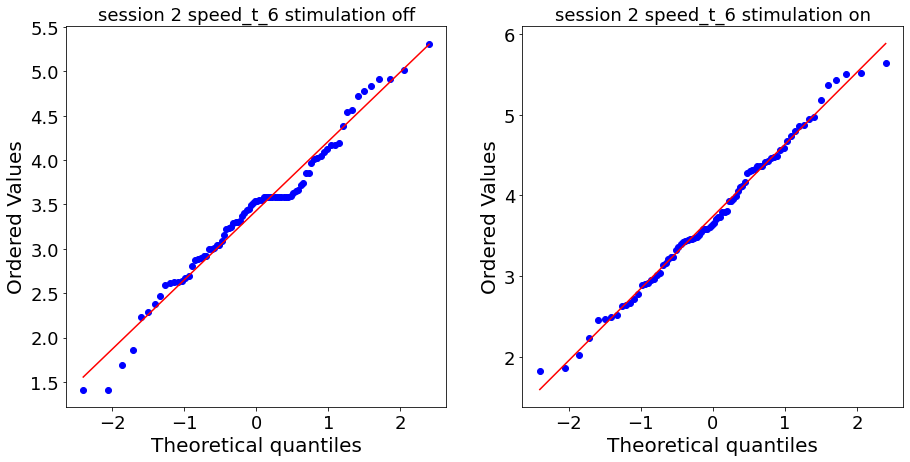

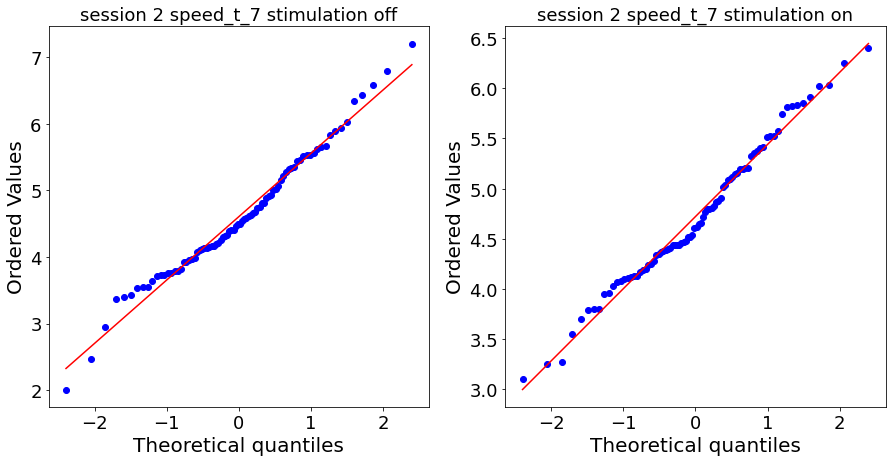

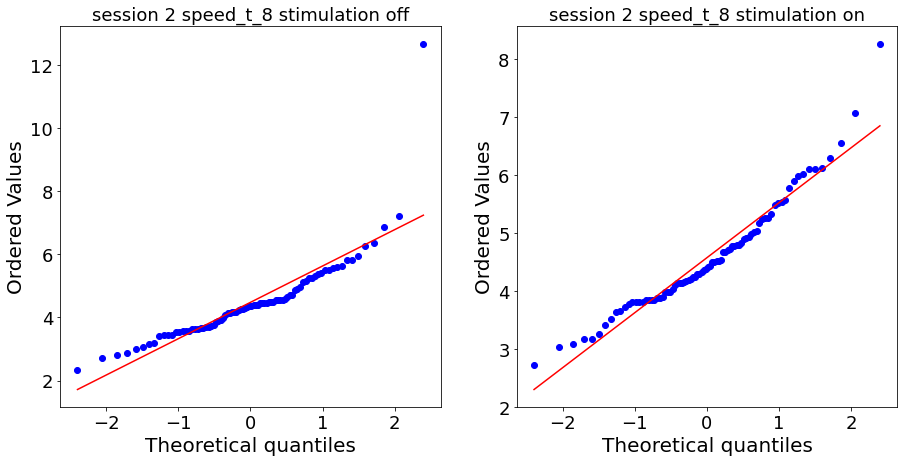

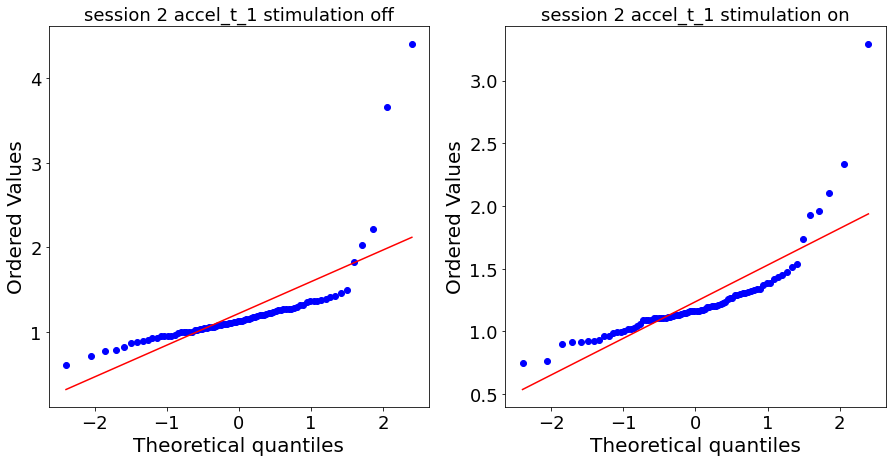

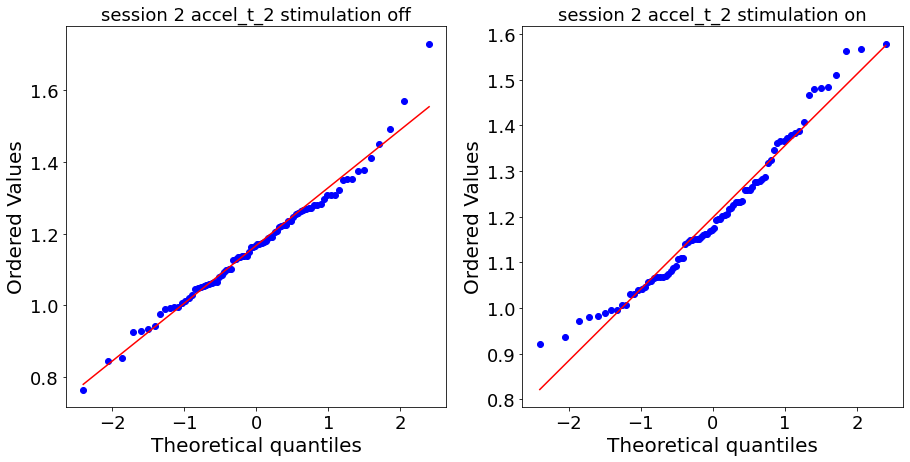

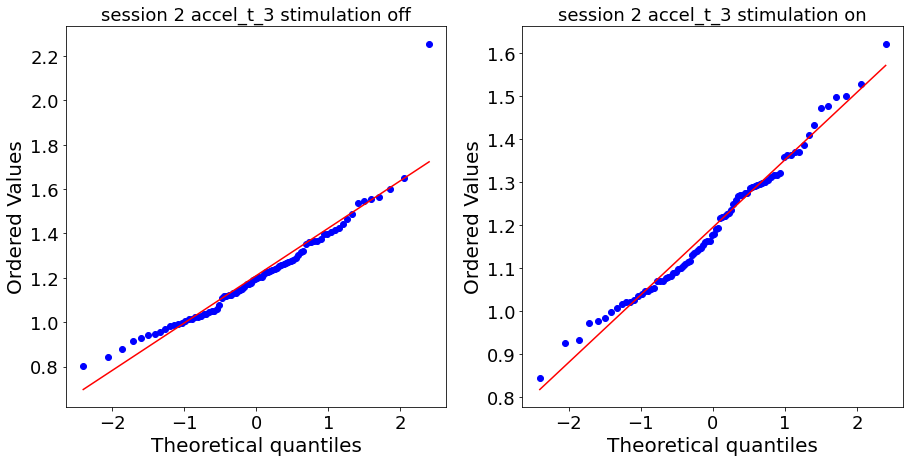

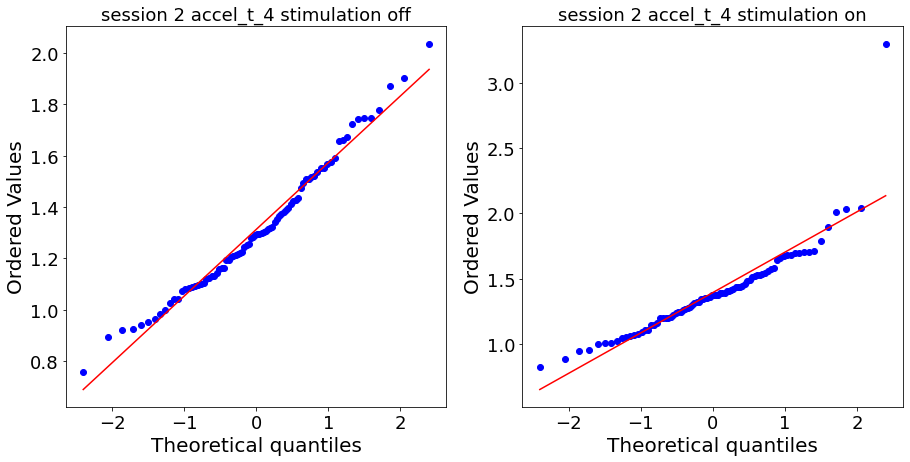

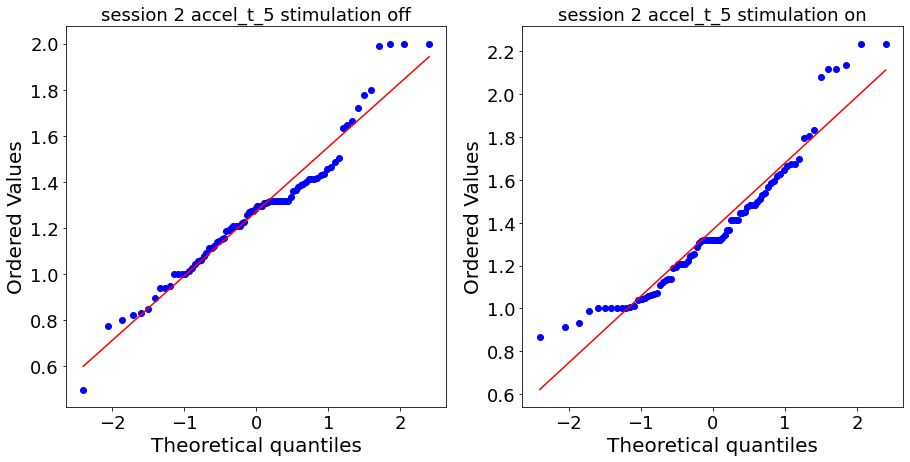

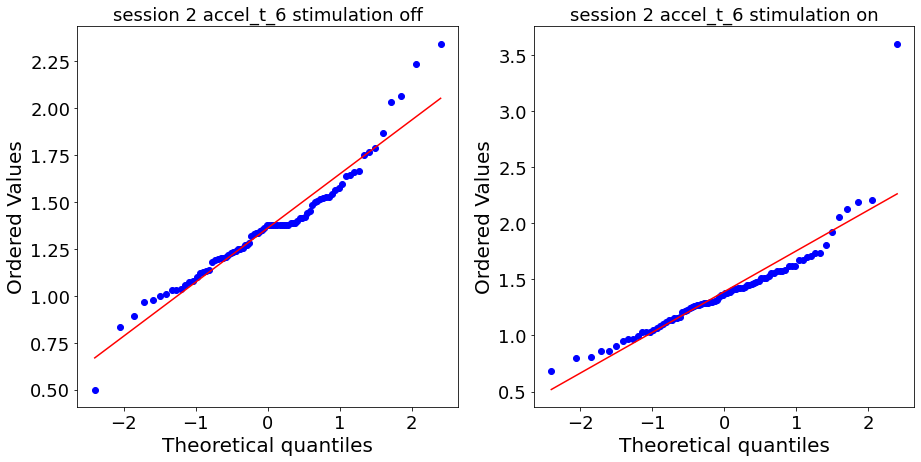

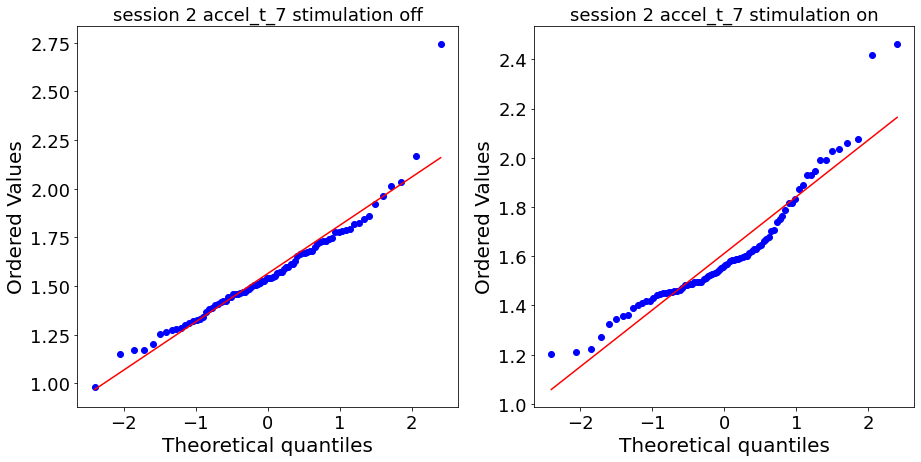

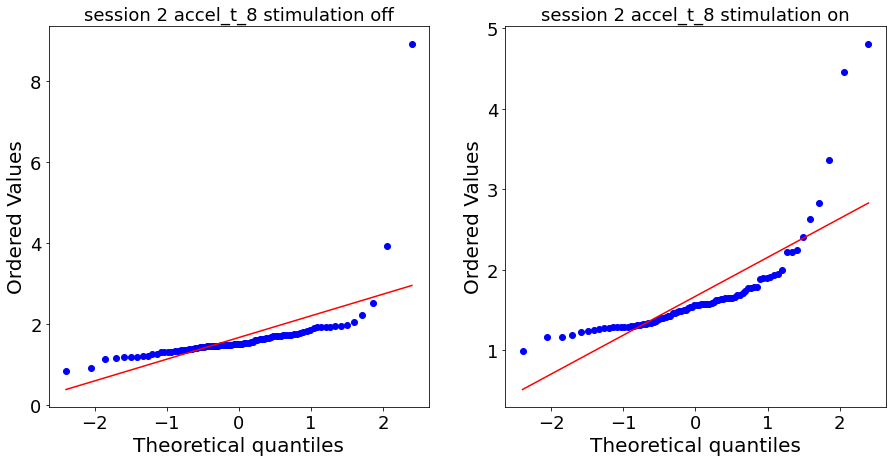

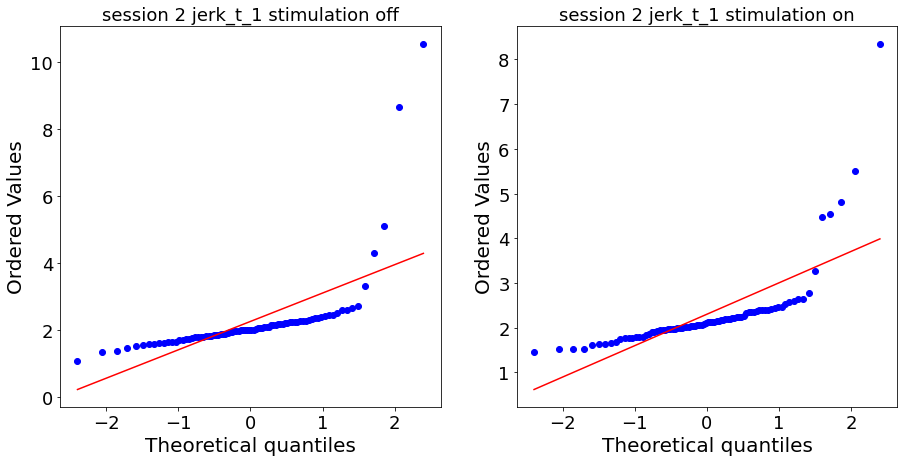

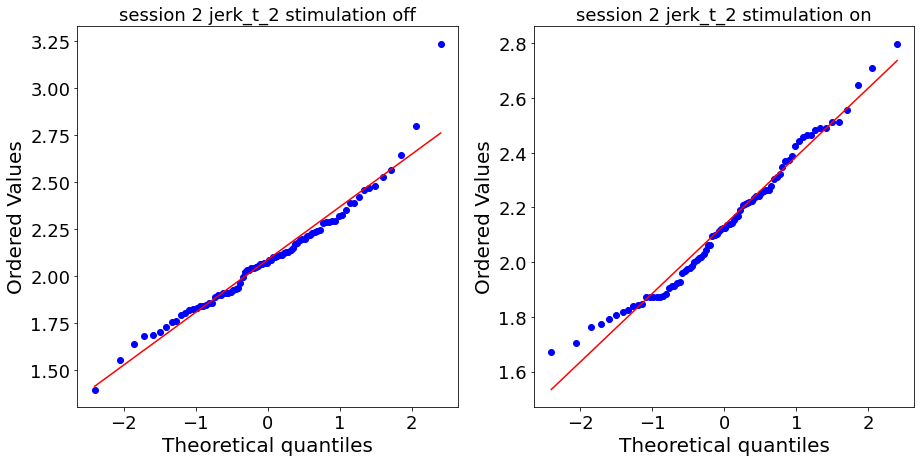

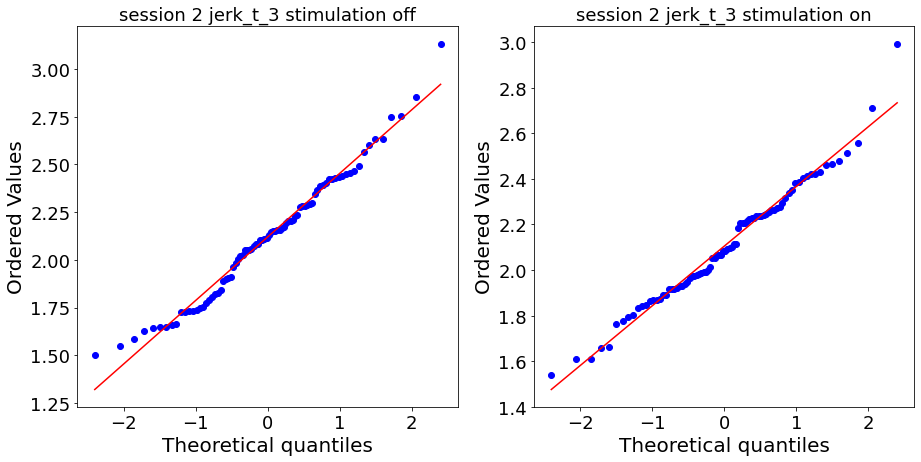

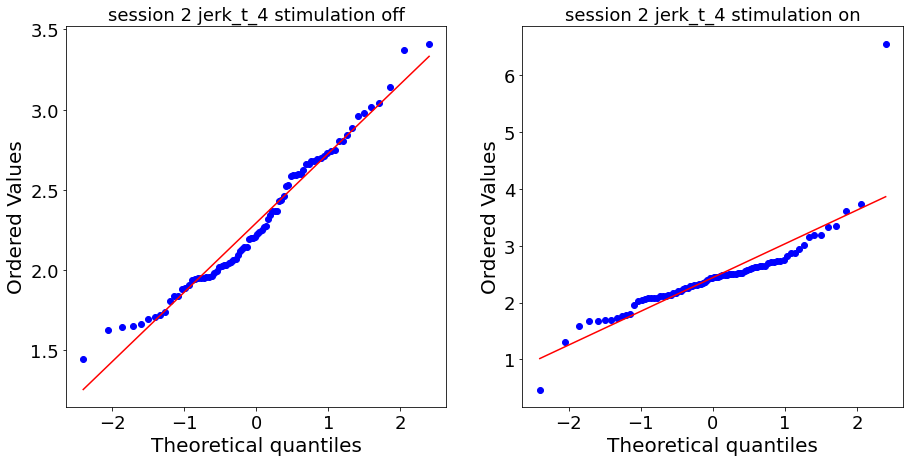

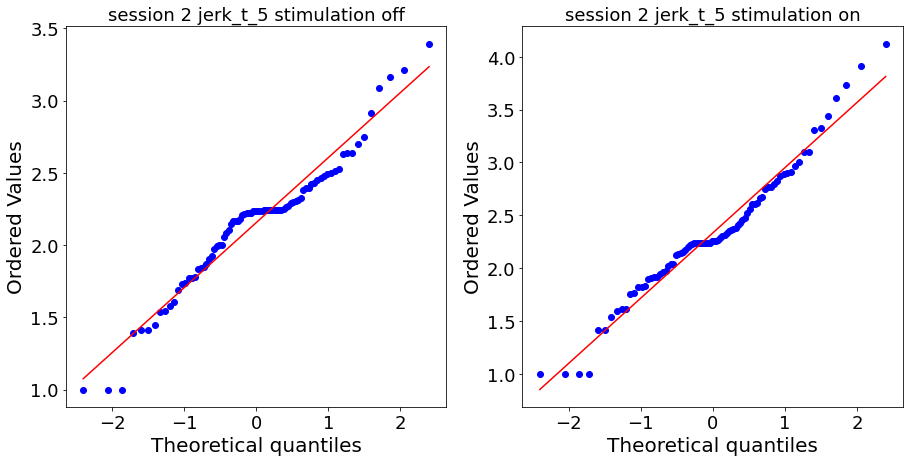

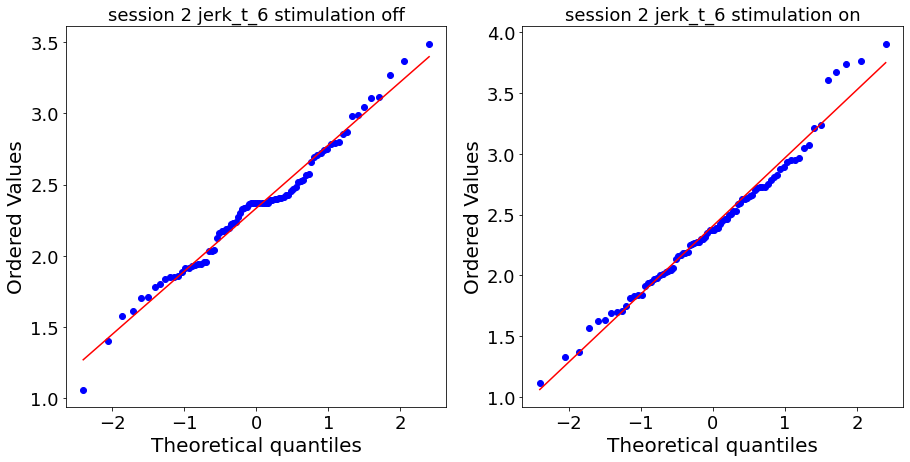

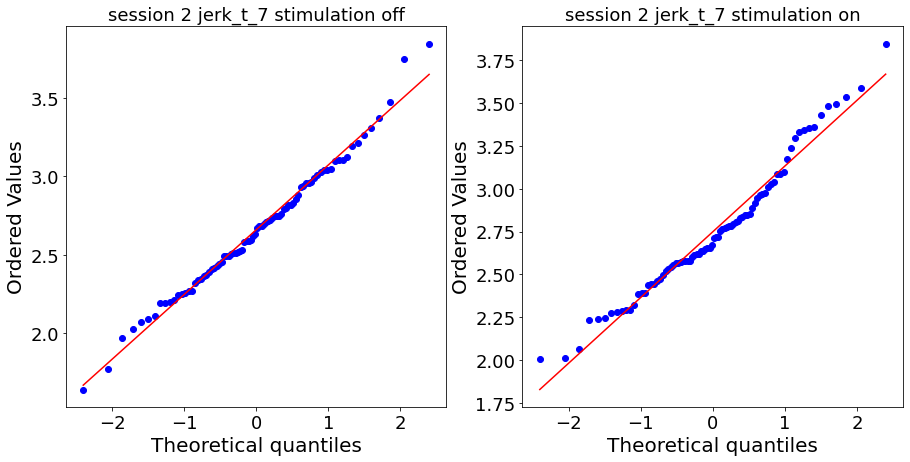

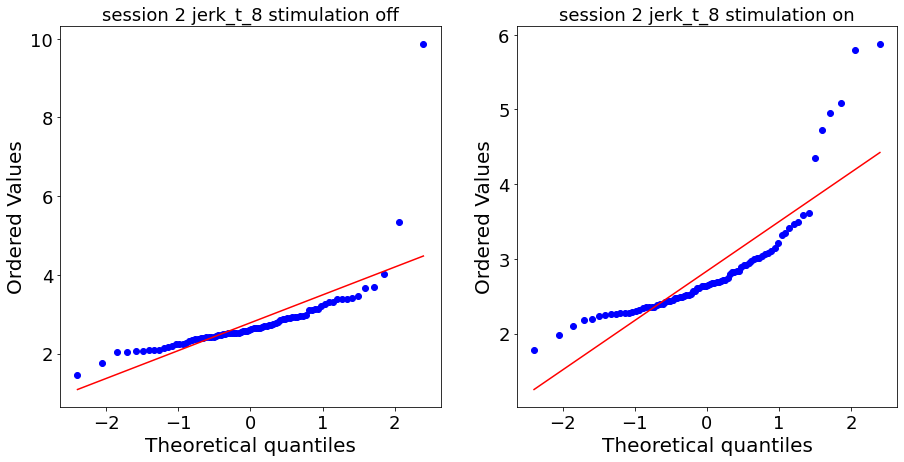

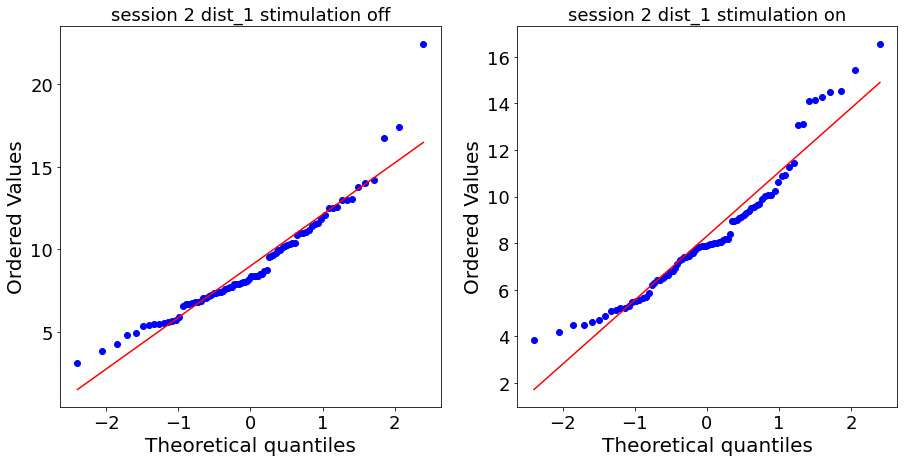

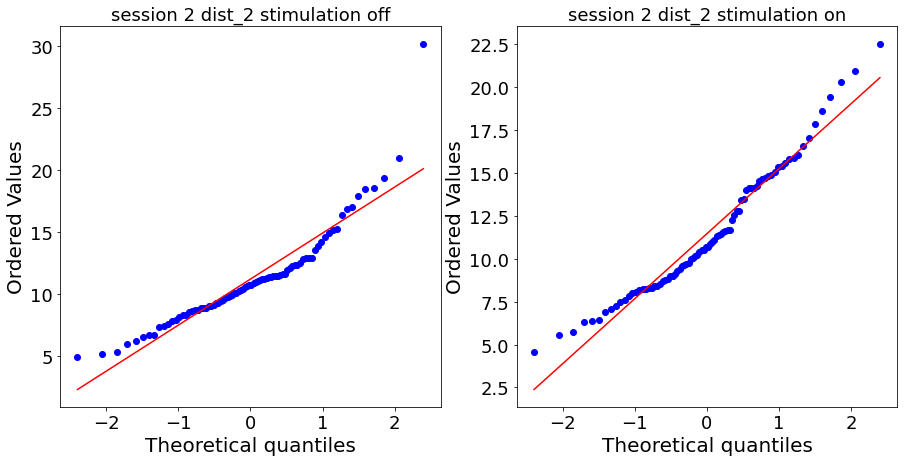

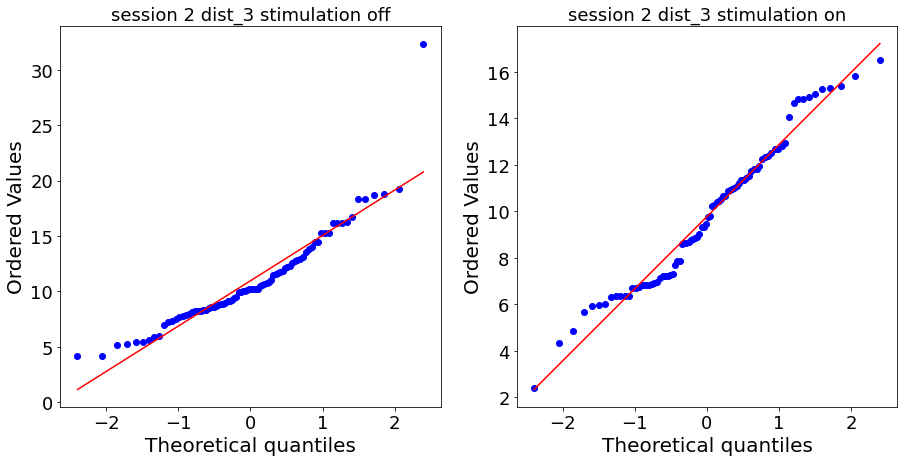

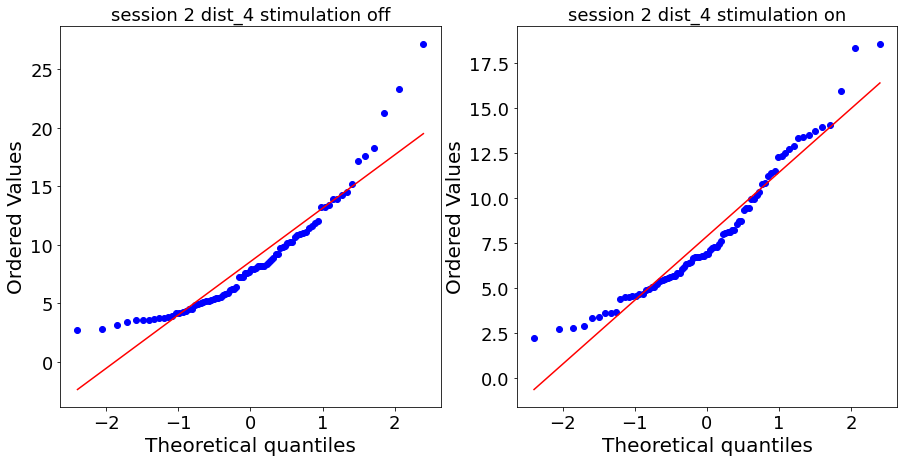

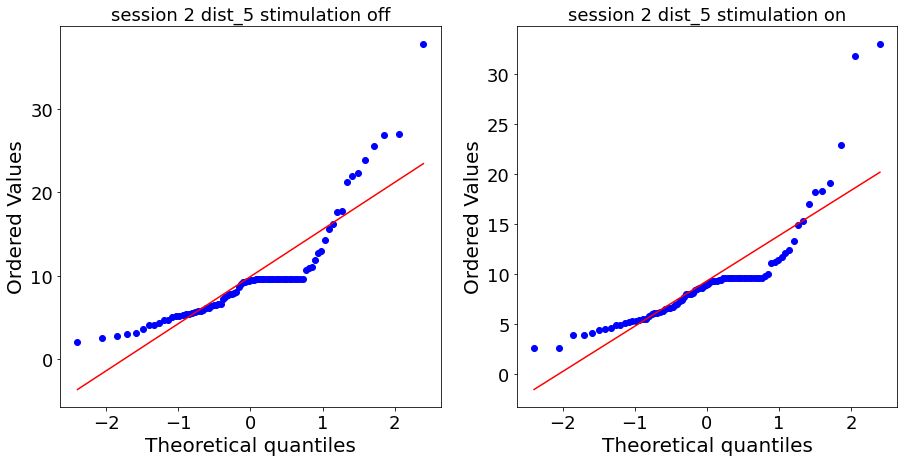

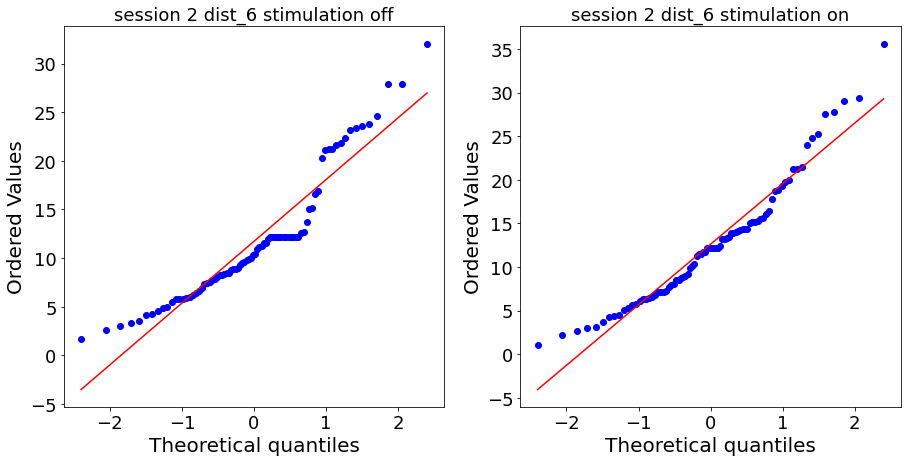

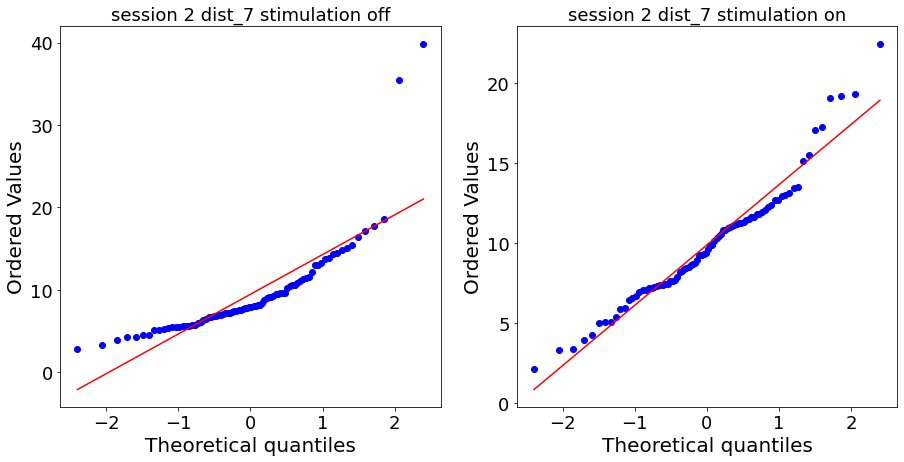

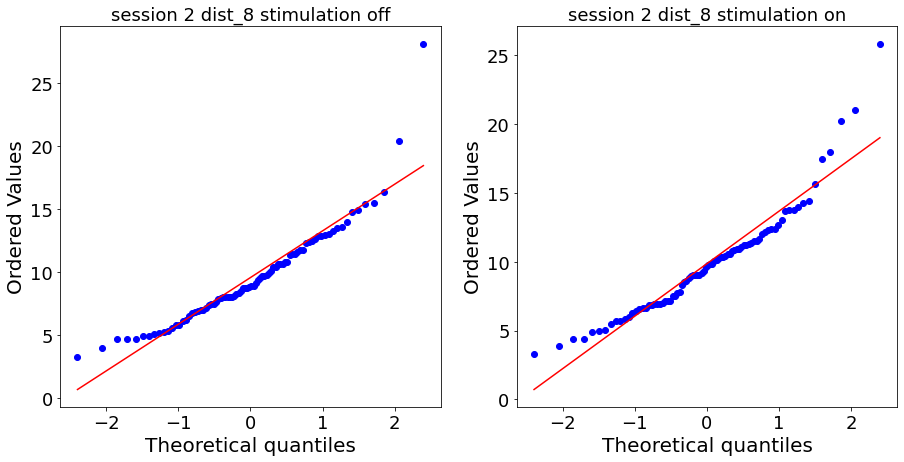

In [46]:
# Plot qq plots for session 2 on the unsmoothened dataset
from scipy.stats import probplot
features = unsmoothened_df[unsmoothened_df['session'] == 2].drop(['session', 'ix_block', 'ix_trial', 'startTStamp'], axis =1)

print('session 2')
for i, column in enumerate(features.columns):
    if column != 'stim':
        fig, axs = plt.subplots(1,2, figsize = (15,7))
        axs = axs.ravel()
        probplot(features[column][features['stim'] == 0], plot = axs[0])
        axs[0].set_title('session 2 ' + column + " stimulation off")
        probplot(features[column][features['stim'] == 1], plot = axs[1])
        axs[1].set_title('session 2 ' + column + " stimulation on")
        plt.show()

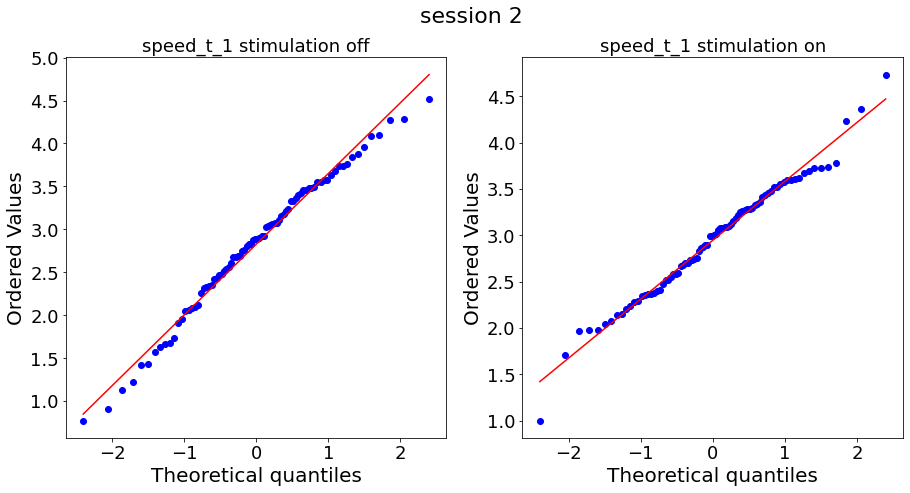

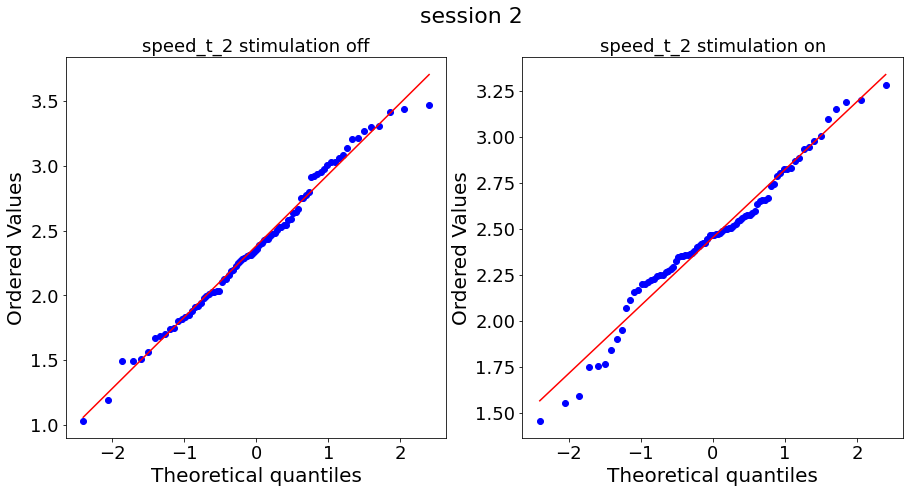

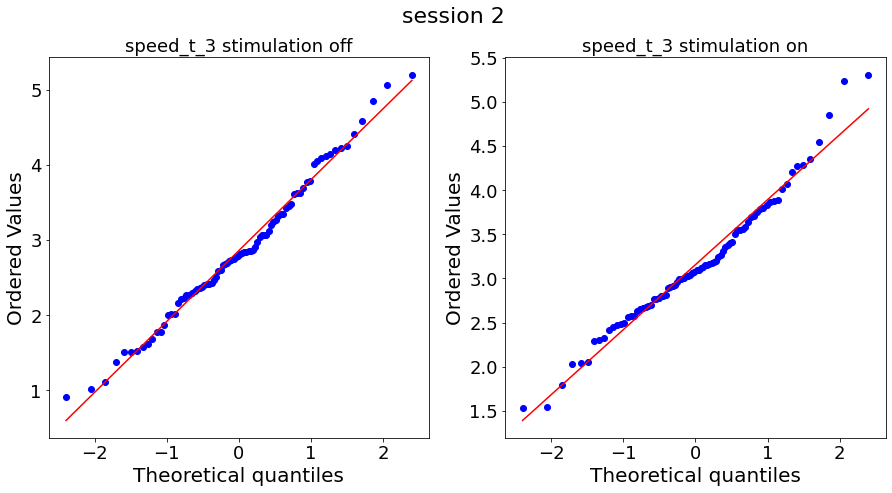

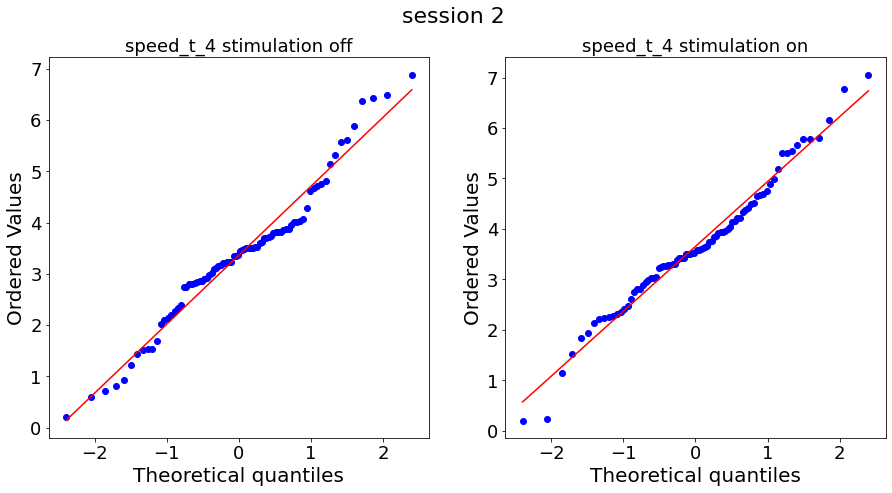

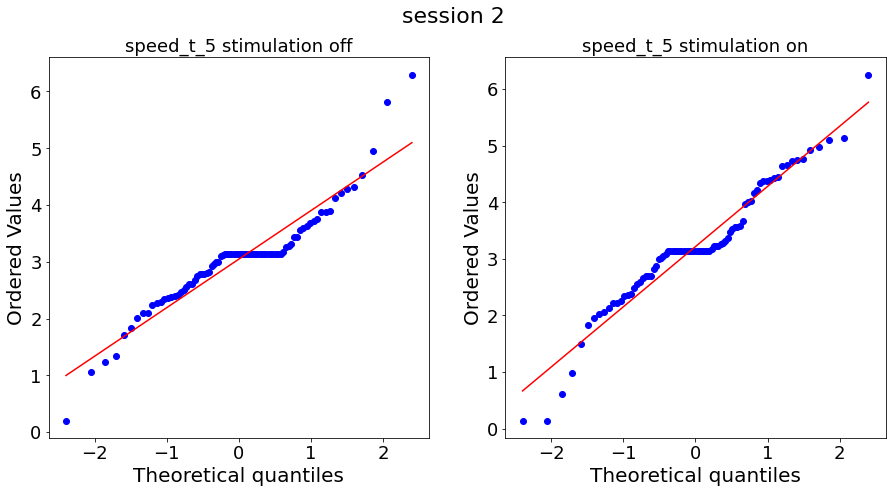

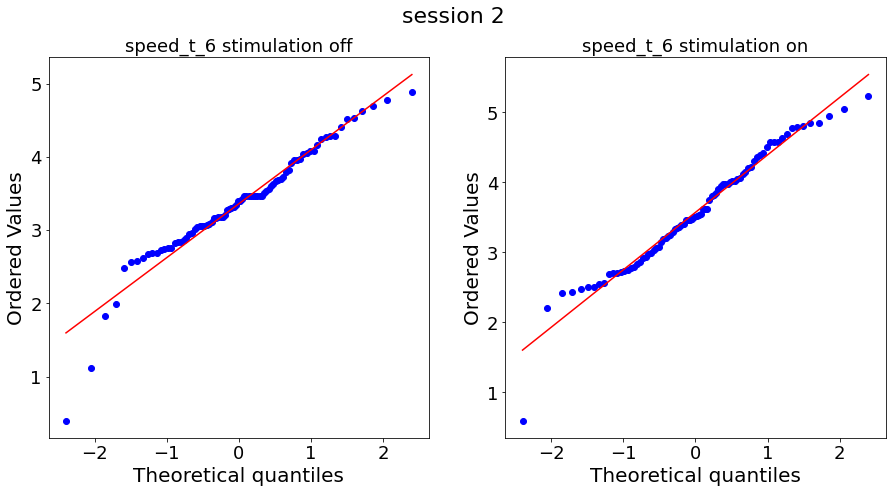

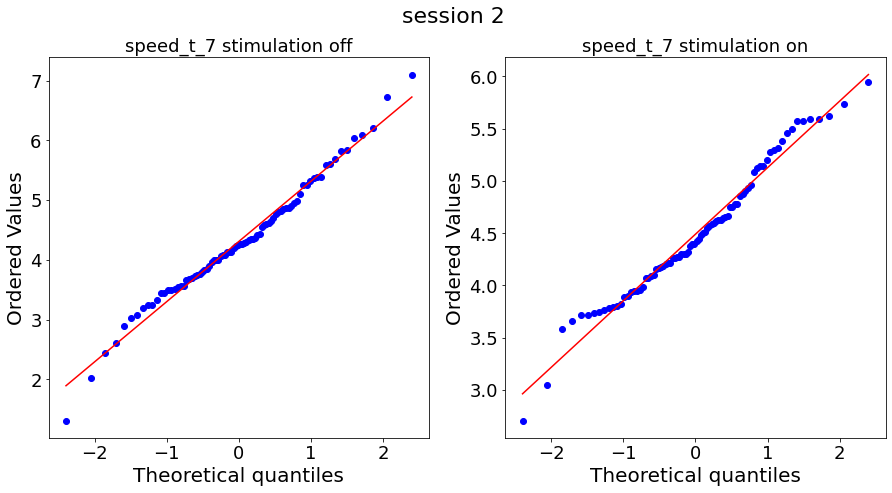

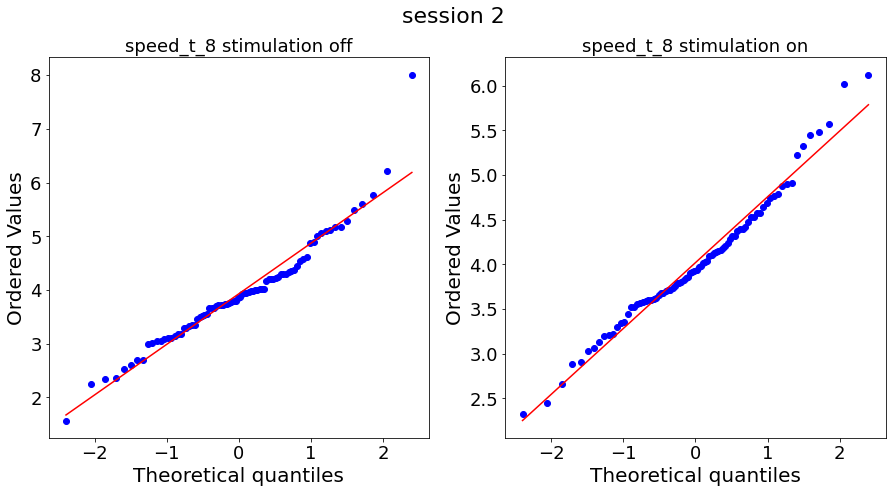

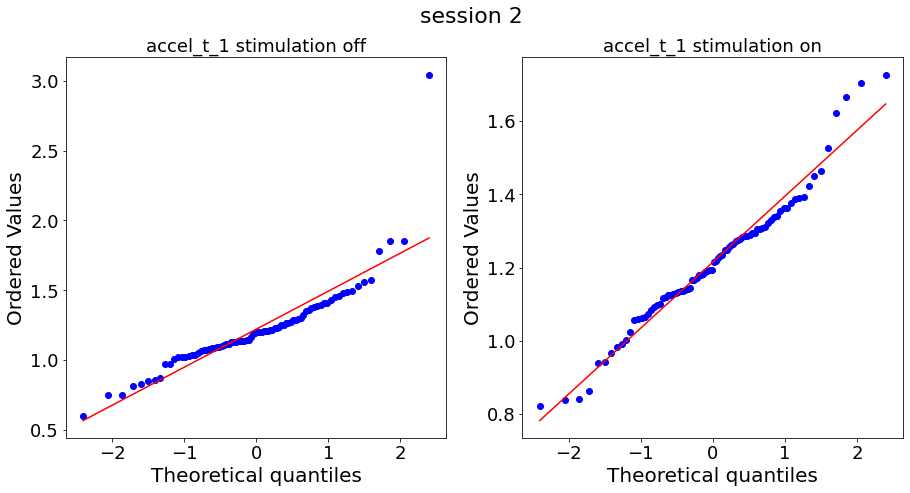

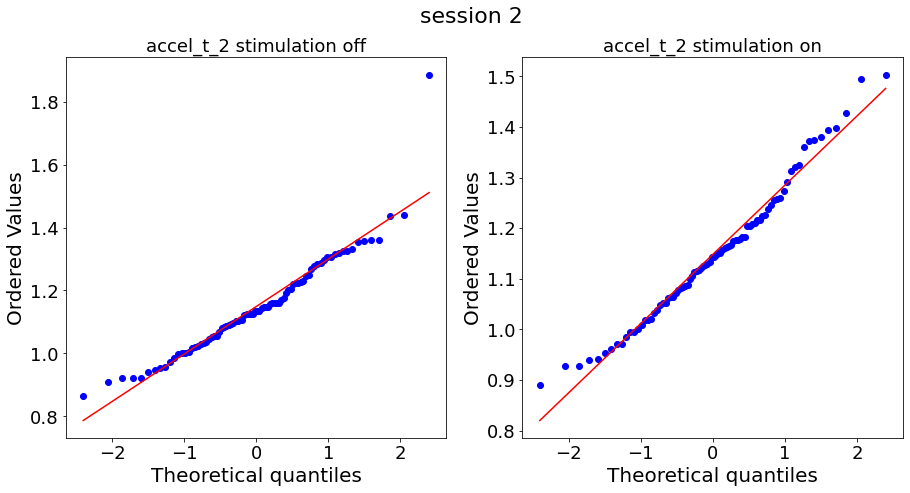

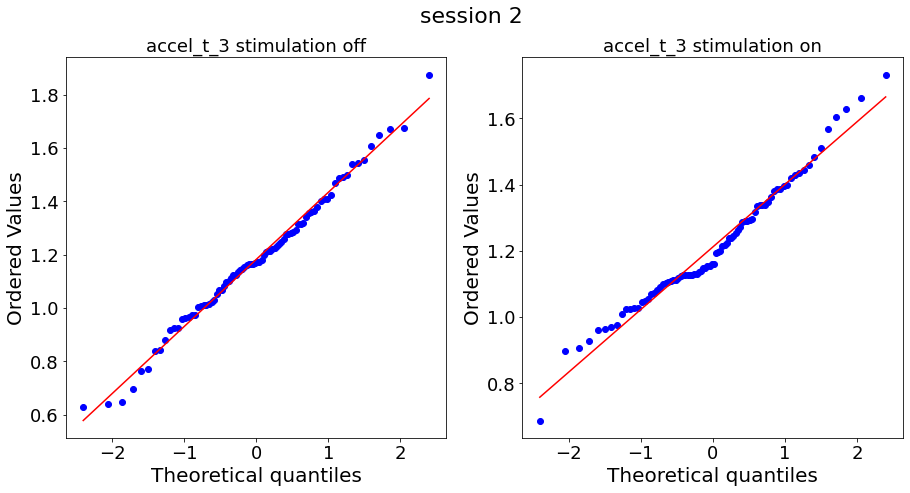

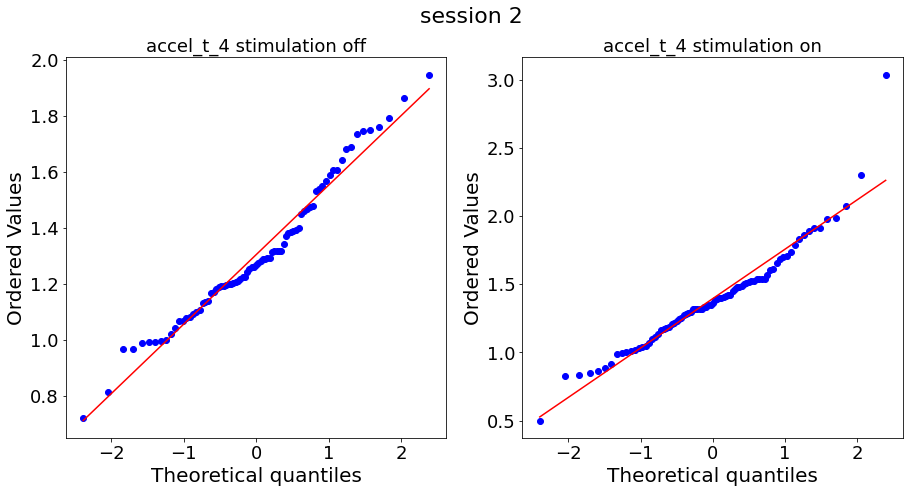

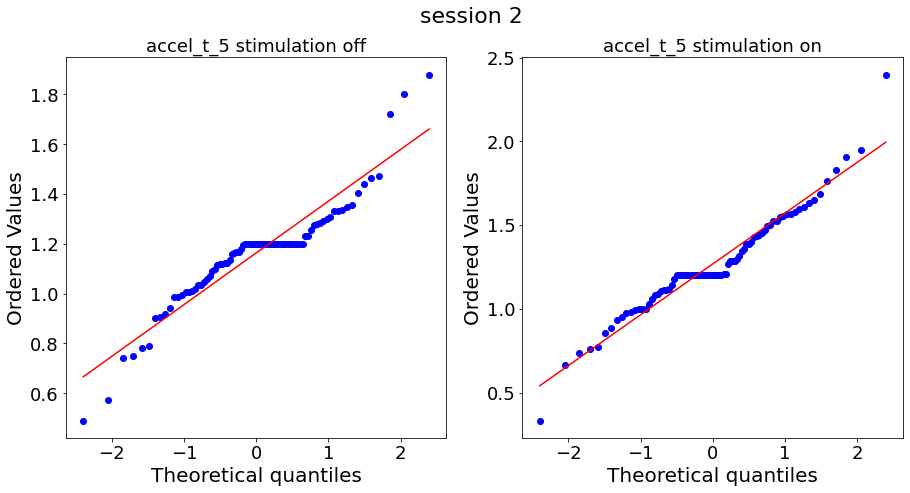

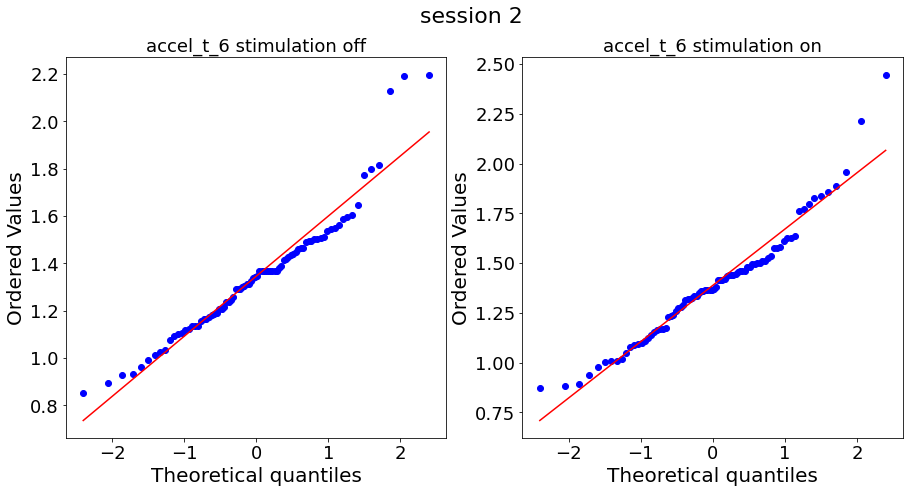

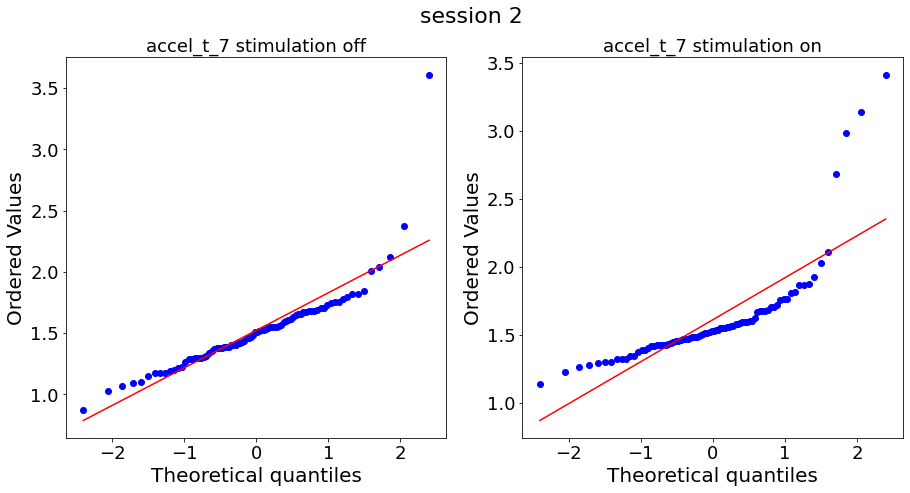

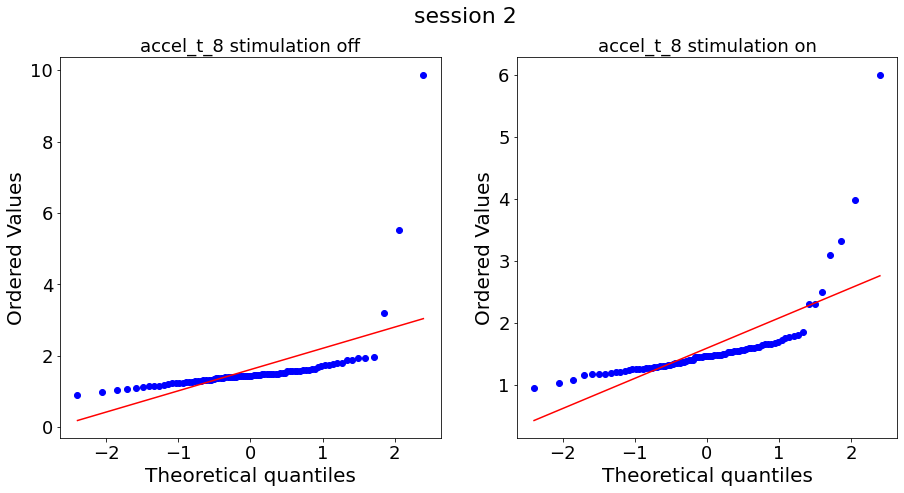

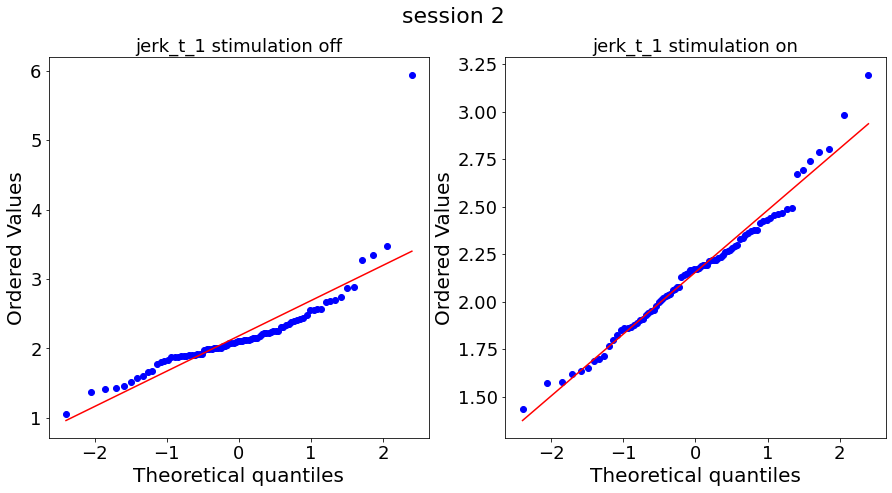

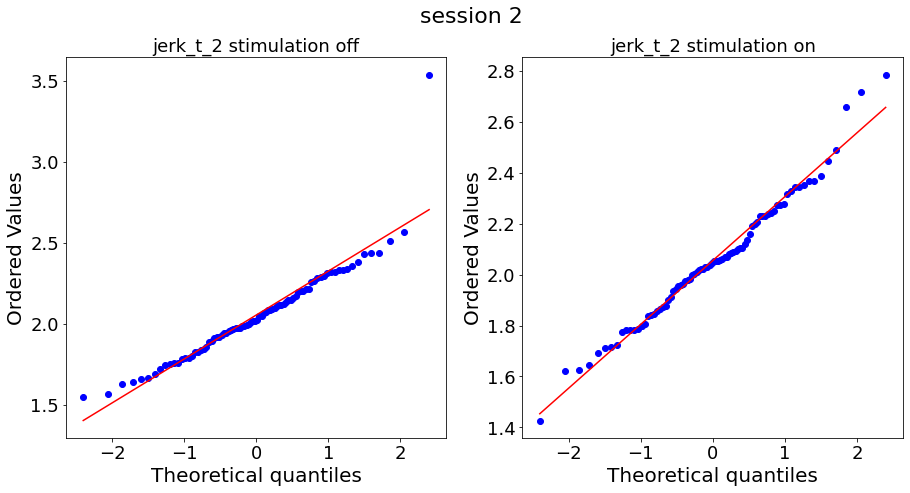

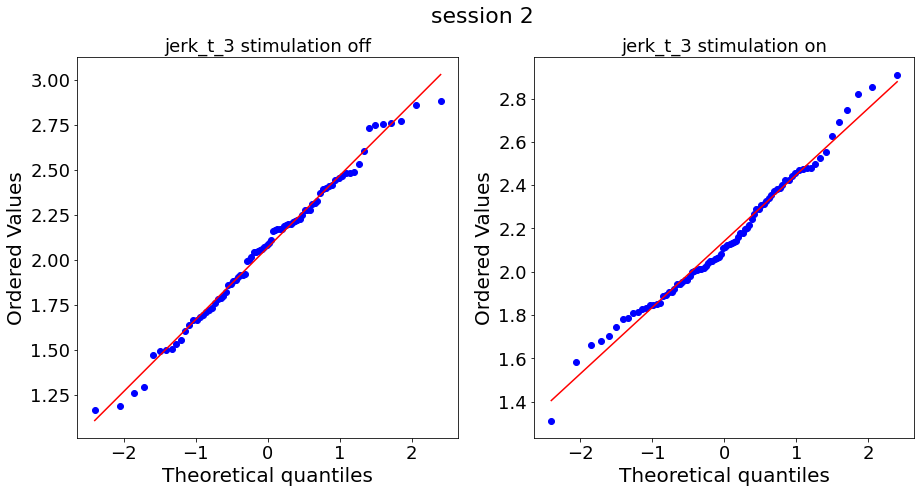

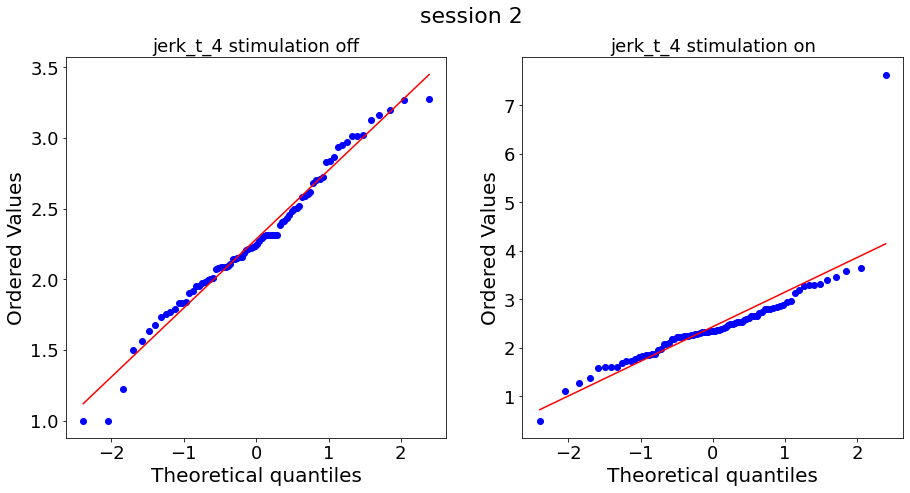

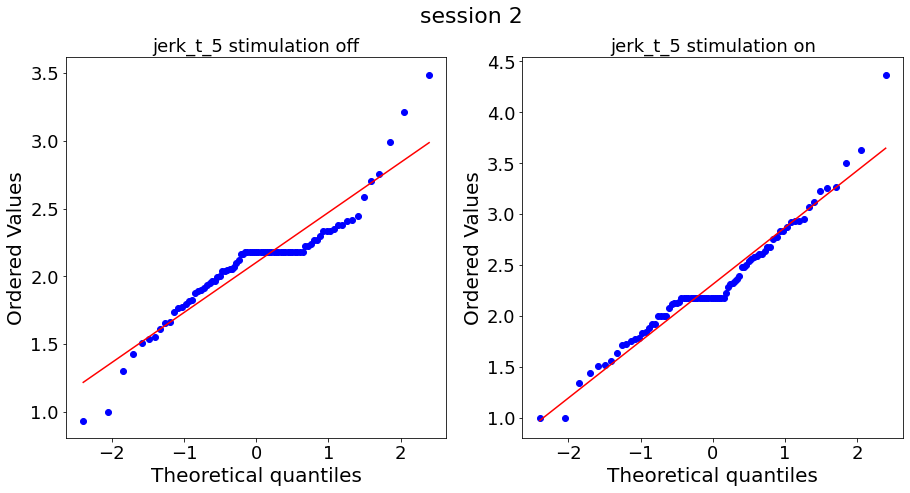

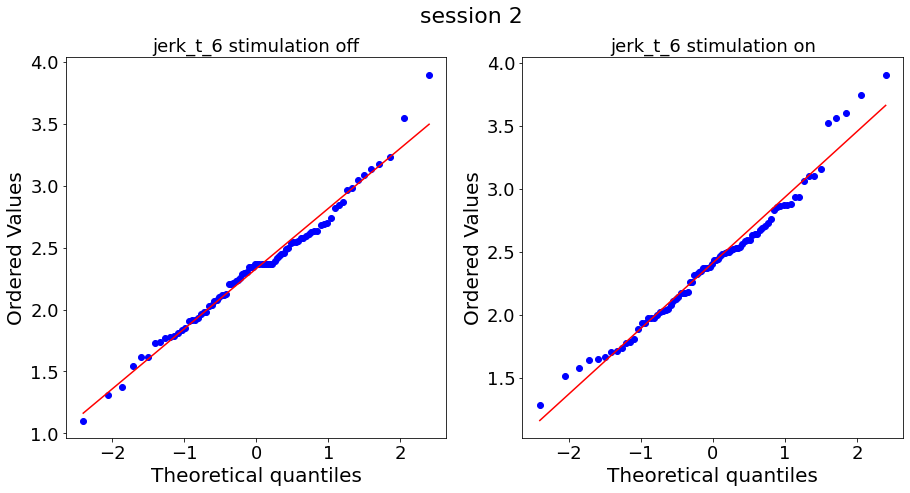

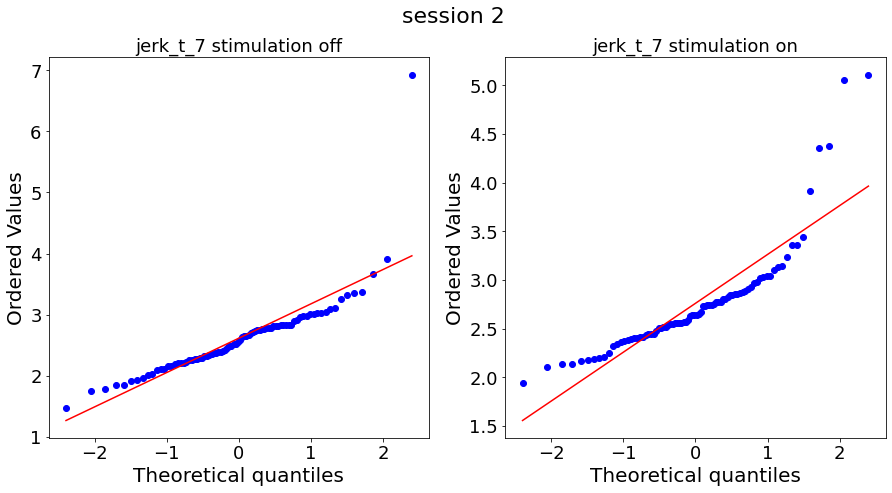

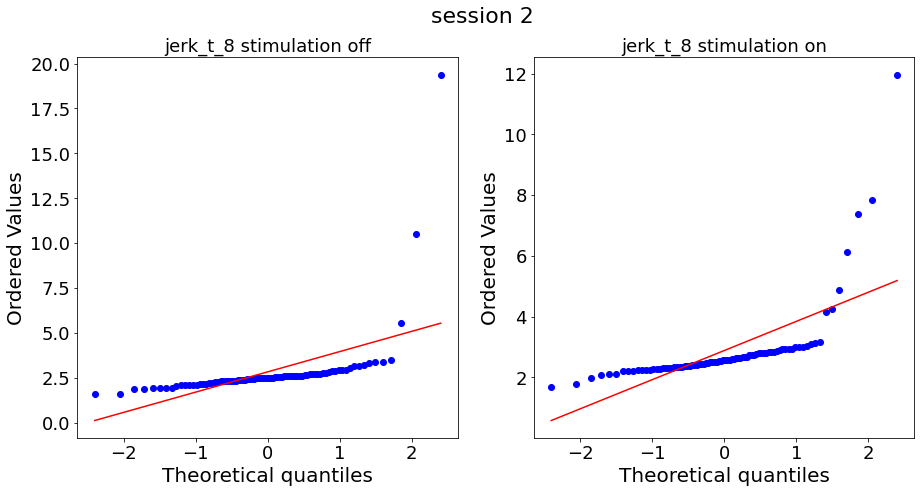

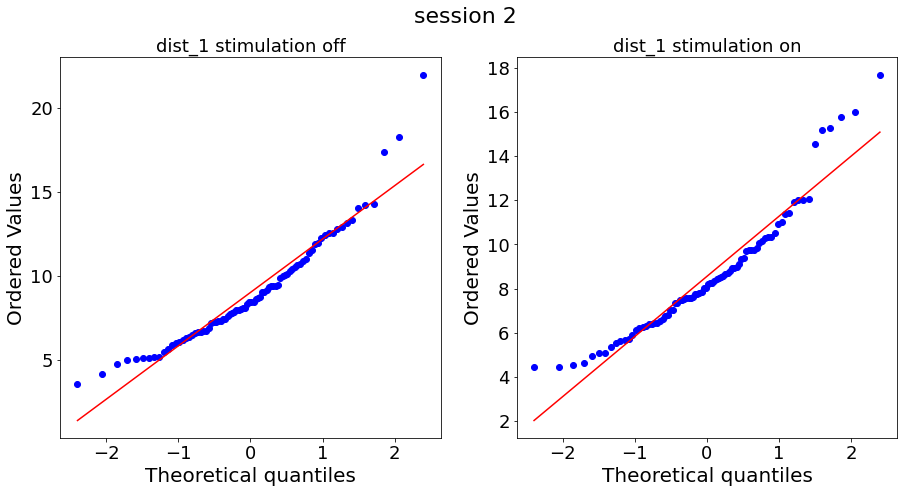

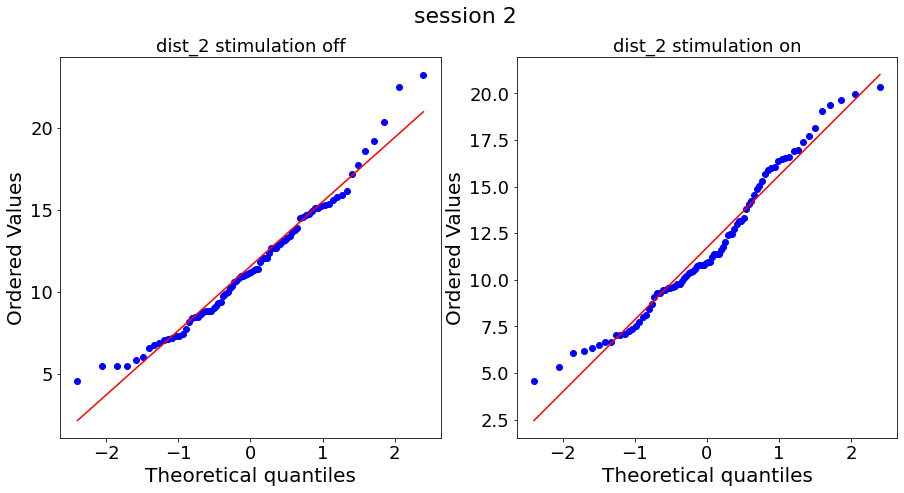

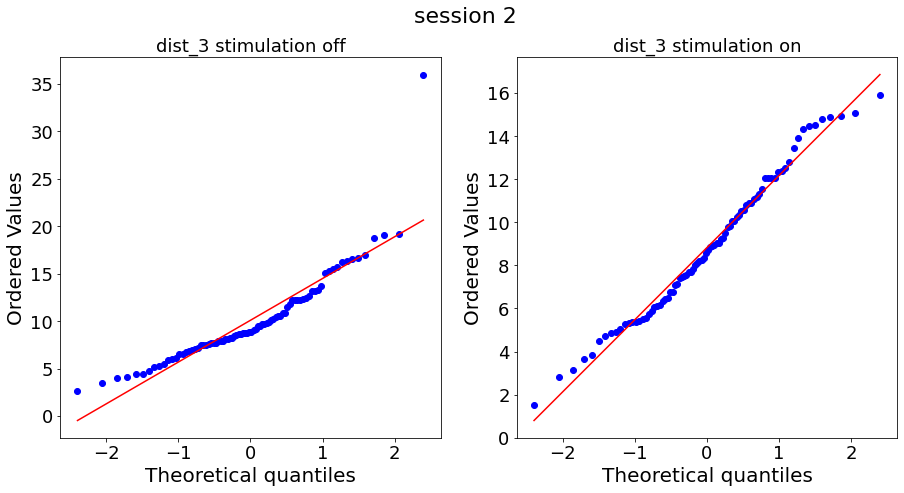

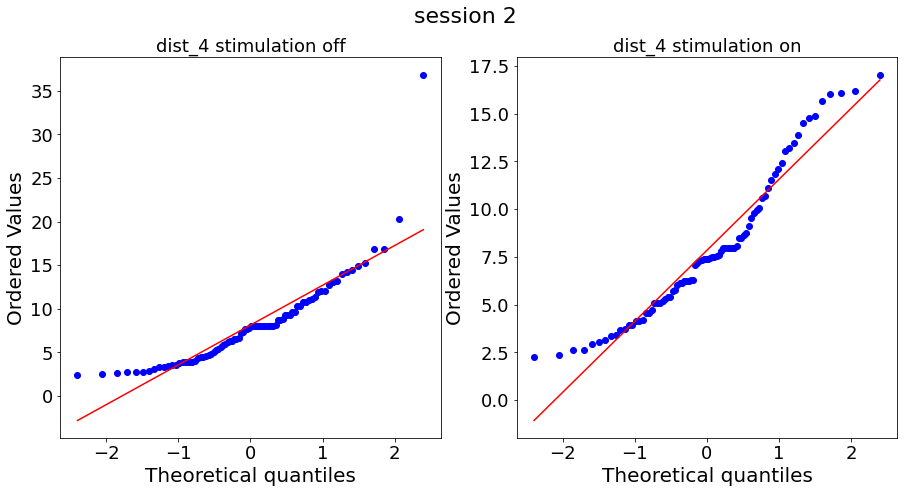

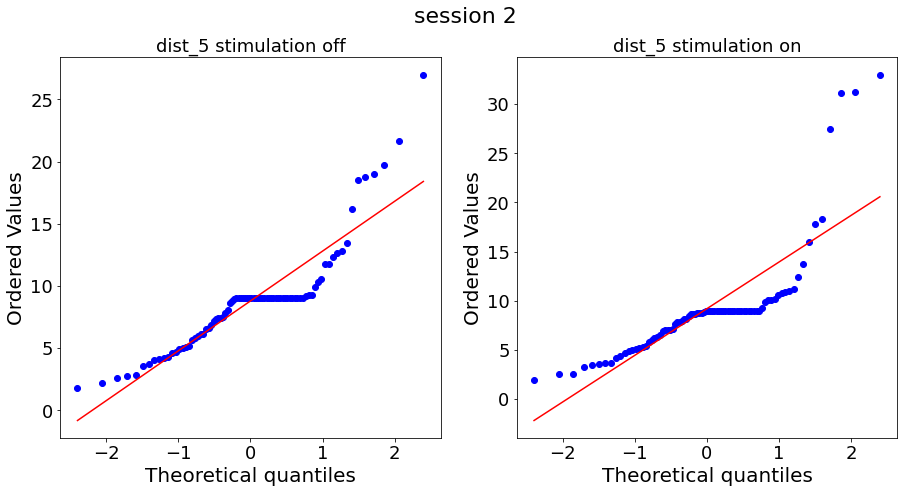

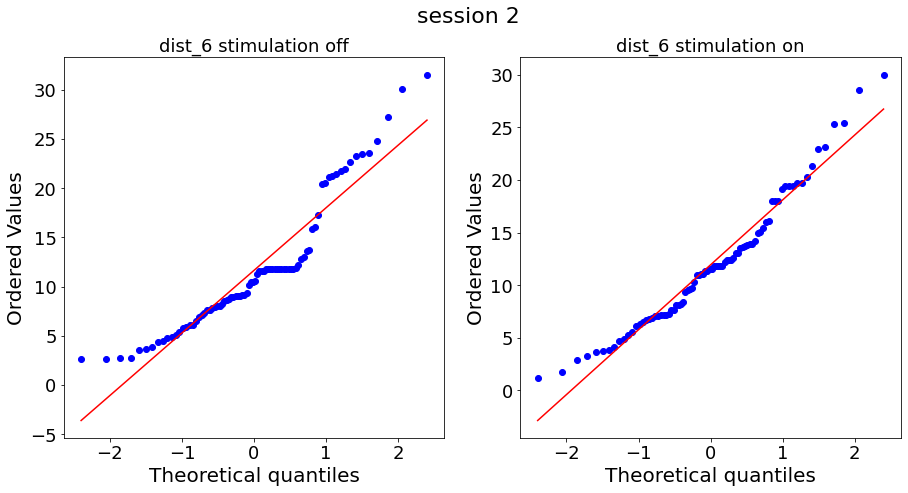

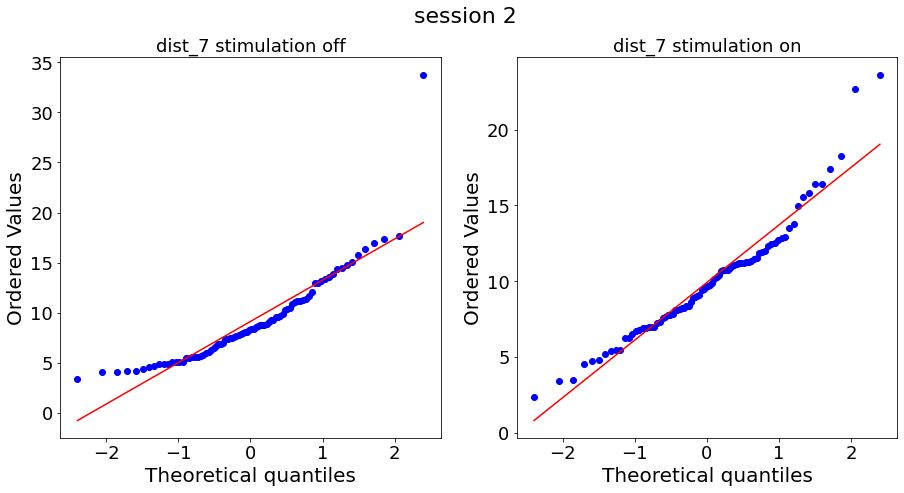

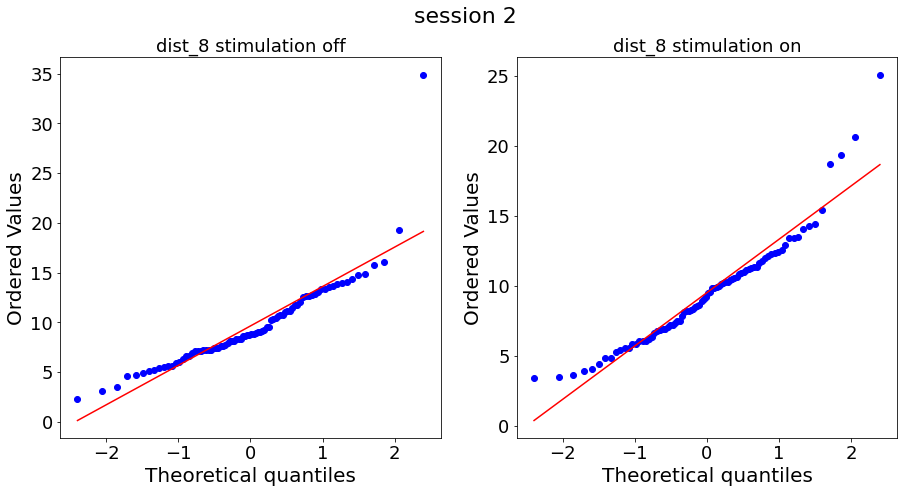

In [52]:
# plot qq-plots on directed smoothened data
from scipy.stats import probplot
features = directed_df[directed_df['session'] == 2].drop(['session', 'ix_block', 'ix_trial', 'startTStamp'], axis =1)

for i, column in enumerate(features.columns):
    if column != 'stim':
        fig, axs = plt.subplots(1,2, figsize = (15,7))
        fig.suptitle('session 2')
        axs = axs.ravel()
        off = [ x for x in features[column][features['stim'] == 0] if x > 0]
        on = [ x for x in features[column][features['stim'] == 1] if x > 0]
        
        probplot(off, plot = axs[0])
        axs[0].set_title(column + " stimulation off")
        probplot(on, plot = axs[1])
        axs[1].set_title(column + " stimulation on")
        plt.show()

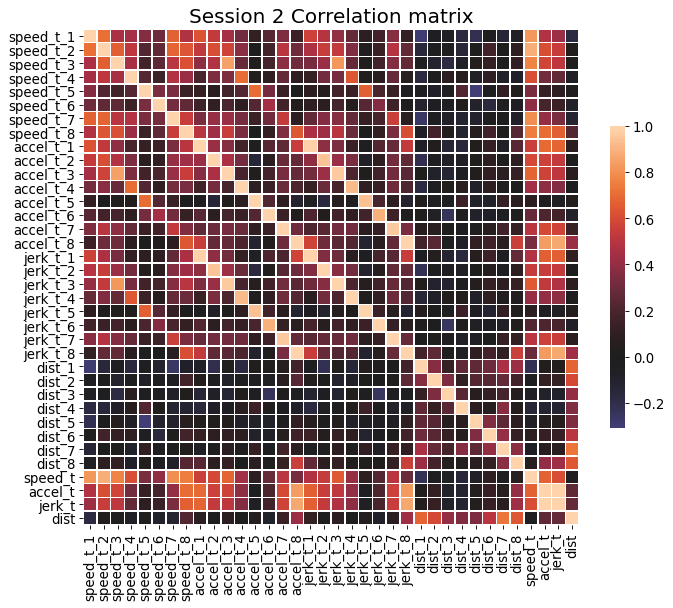

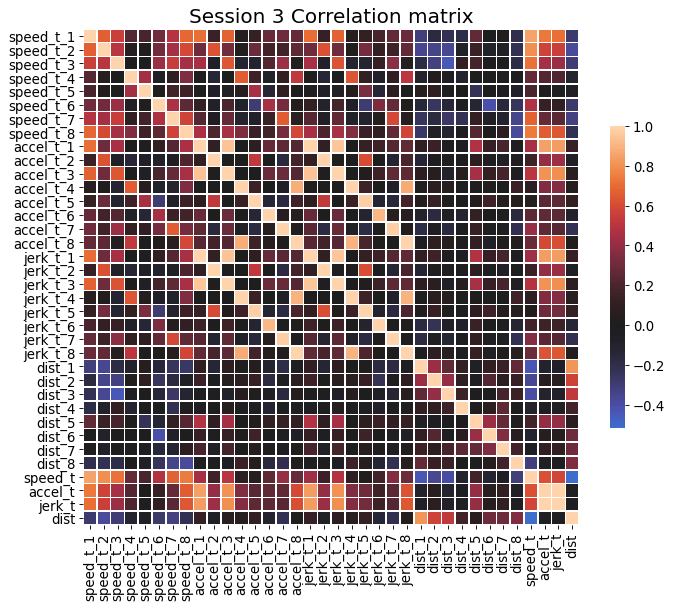

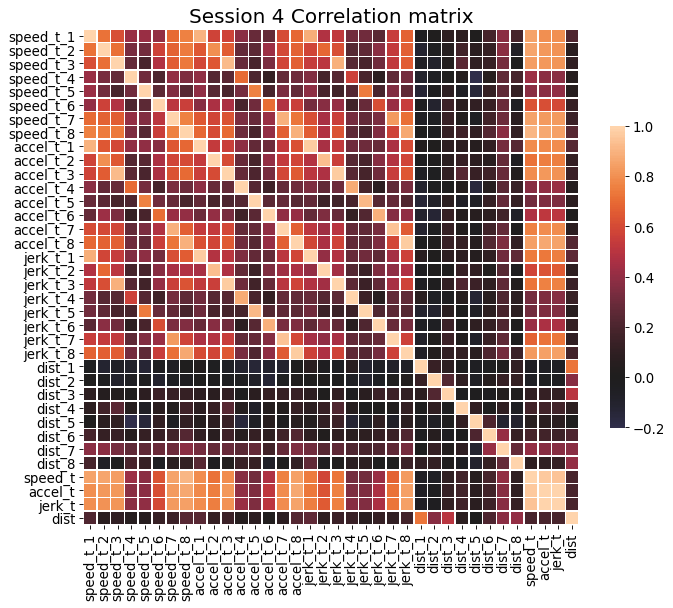

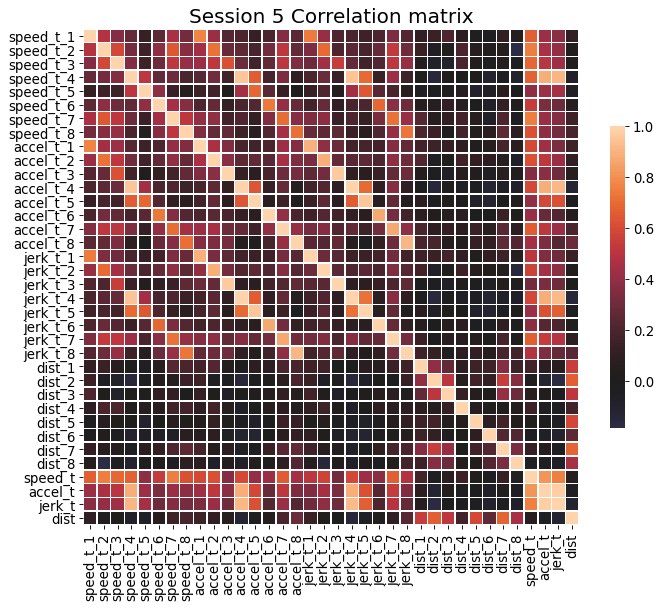

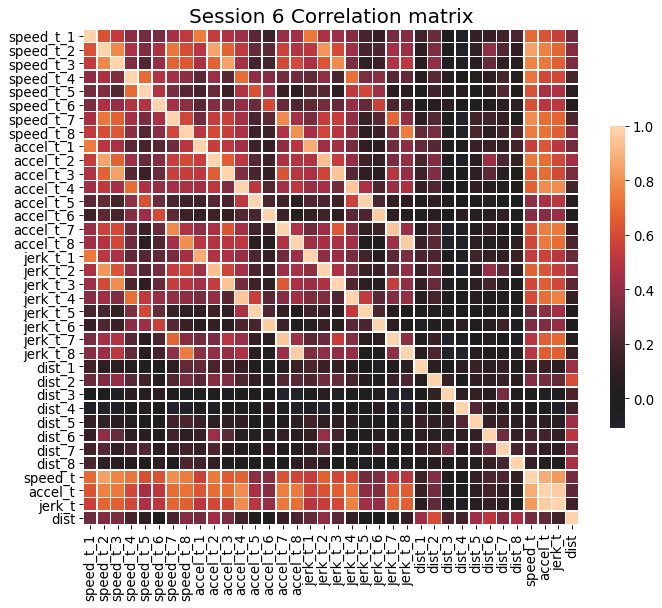

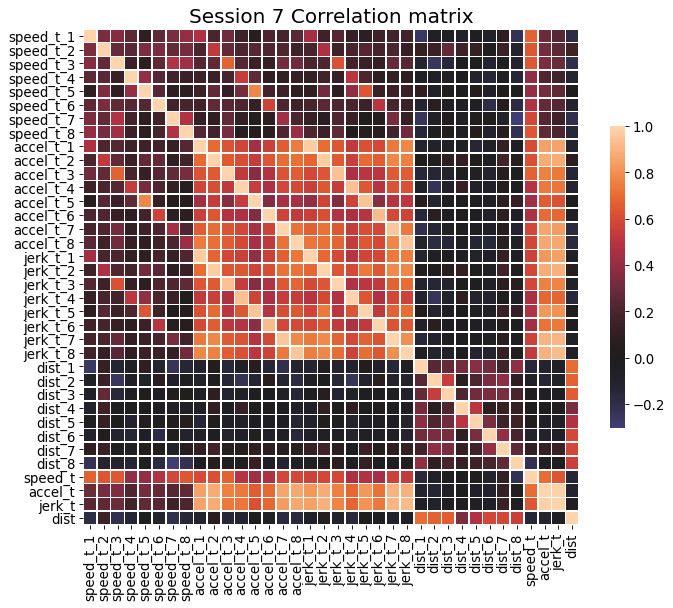

In [57]:
# produce correlation matrices of the directed features
from matplotlib.pyplot import figure

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

for name, group in whole_df.groupby('session'):
    features = group.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
    figure(figsize=(10, 10), dpi=80)
    sns.heatmap(features.corr(), vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Session " + str(name) + " Correlation matrix")
    plt.savefig("Correlation matrix session " + str(name) )
    plt.show()    

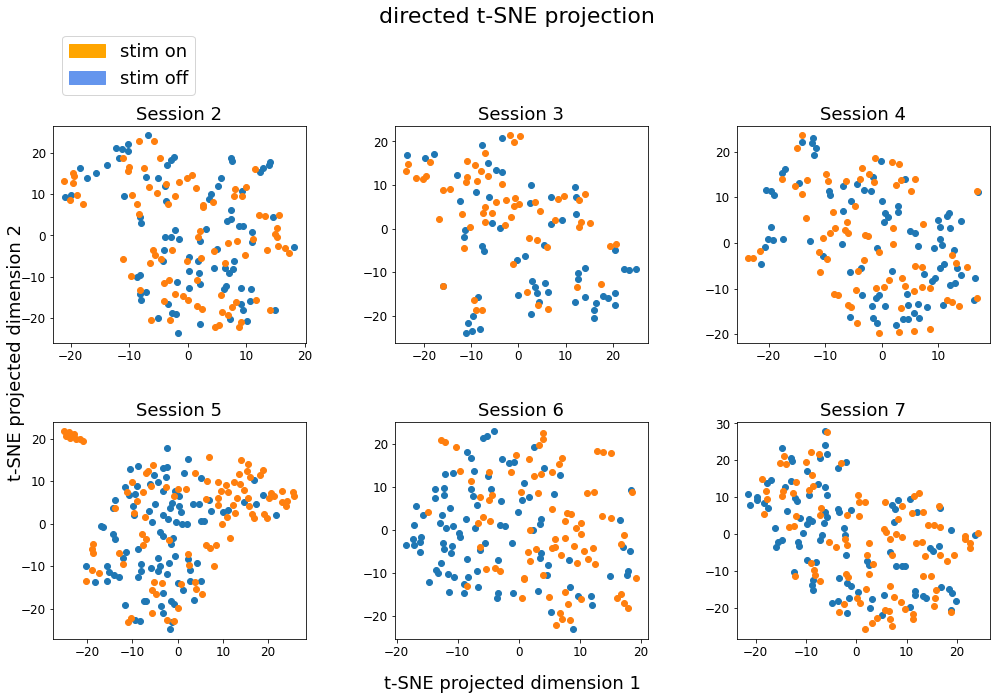

In [56]:
# Create t-SNE projections
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE

fig, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.ravel()

fig.suptitle(" directed t-SNE projection")
fig.tight_layout(pad=3.0)
for name, group in directed_df.groupby('session'):
    features = group.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
    labels = group['stim']
    X_embedded = TSNE(n_components=2, n_jobs = -1, learning_rate = 100, n_iter = 500, 
                      perplexity = 12).fit_transform(features)
    
    axs[name-2].scatter(X_embedded[labels == 0][:,0],X_embedded[labels == 0][:,1], label='stim off')
    axs[name-2].scatter(X_embedded[labels == 1][:,0],X_embedded[labels == 1][:,1], label='stim on')
    axs[name-2].set_title("Session " + str(name))

orange_patch = mpatches.Patch(color='orange', label = 'stim on')
blue_patch = mpatches.Patch(color='cornflowerblue', label = 'stim off')
axs[0].legend(handles = [orange_patch, blue_patch], bbox_to_anchor=(0, 1.1), loc='lower left')    
fig.text(0.5, 0.04, 't-SNE projected dimension 1', ha='center', va='center')
fig.text(0.04, 0.5, 't-SNE projected dimension 2', ha='center', va='center', rotation='vertical')

plt.show()
fig.savefig("directed_t_SNE_projection")

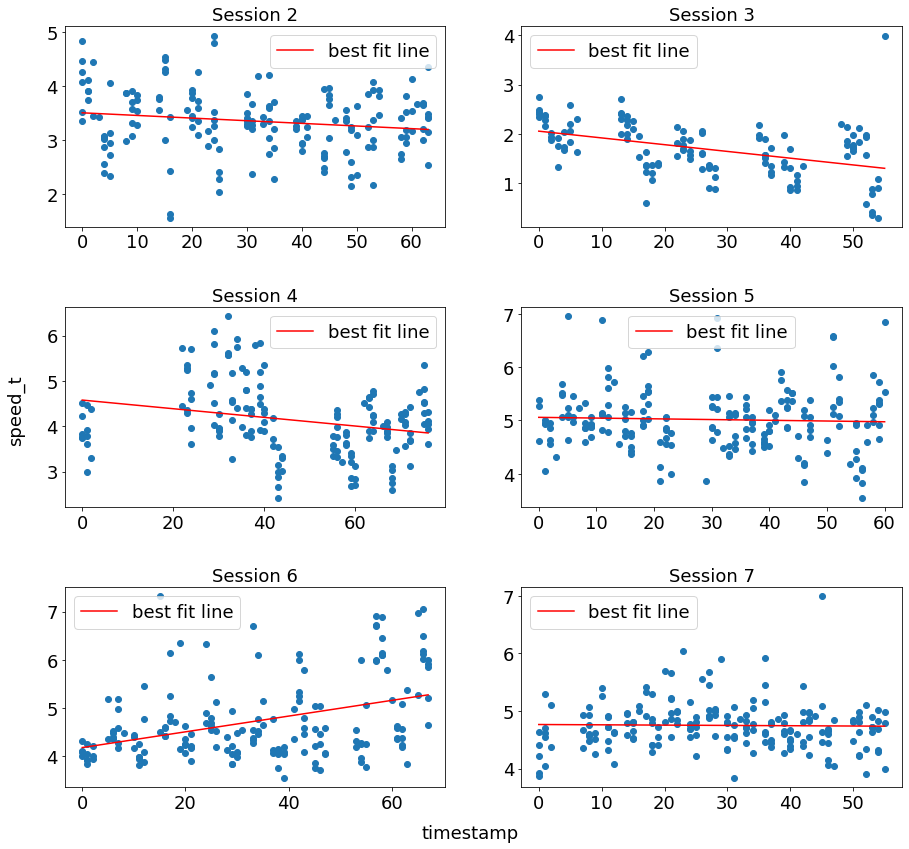

In [34]:
# Plot linear trends on data
fig, axs = plt.subplots(3,2, figsize=(15,14))
axs = axs.ravel()
plt.subplots_adjust(hspace=0.4)
for i, (name, group) in enumerate(undirected_df.groupby('session')):    
    axs[i].scatter(group['startTStamp'], group['speed_t'])
    axs[i].plot(np.unique(group['startTStamp']), 
                np.poly1d(np.polyfit(group['startTStamp'], group['speed_t'], 1))(np.unique(group['startTStamp']))
               ,color = 'r', label = 'best fit line')
    axs[i].set_title("Session %d" %name)
    axs[i].legend()
    
fig.text(0.5, 0.08, 'timestamp', ha='center', va='center')
fig.text(0.08, 0.5, 'speed_t', ha='center', va='center', rotation='vertical')
plt.show()

fig.savefig("data trend")

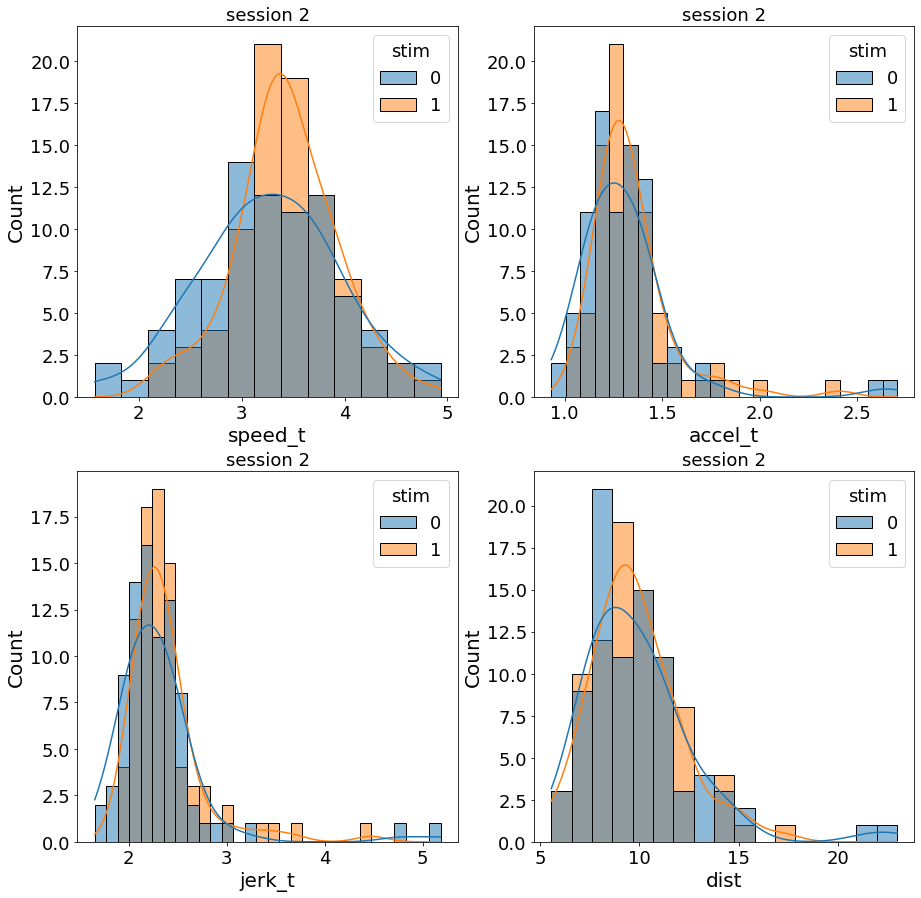

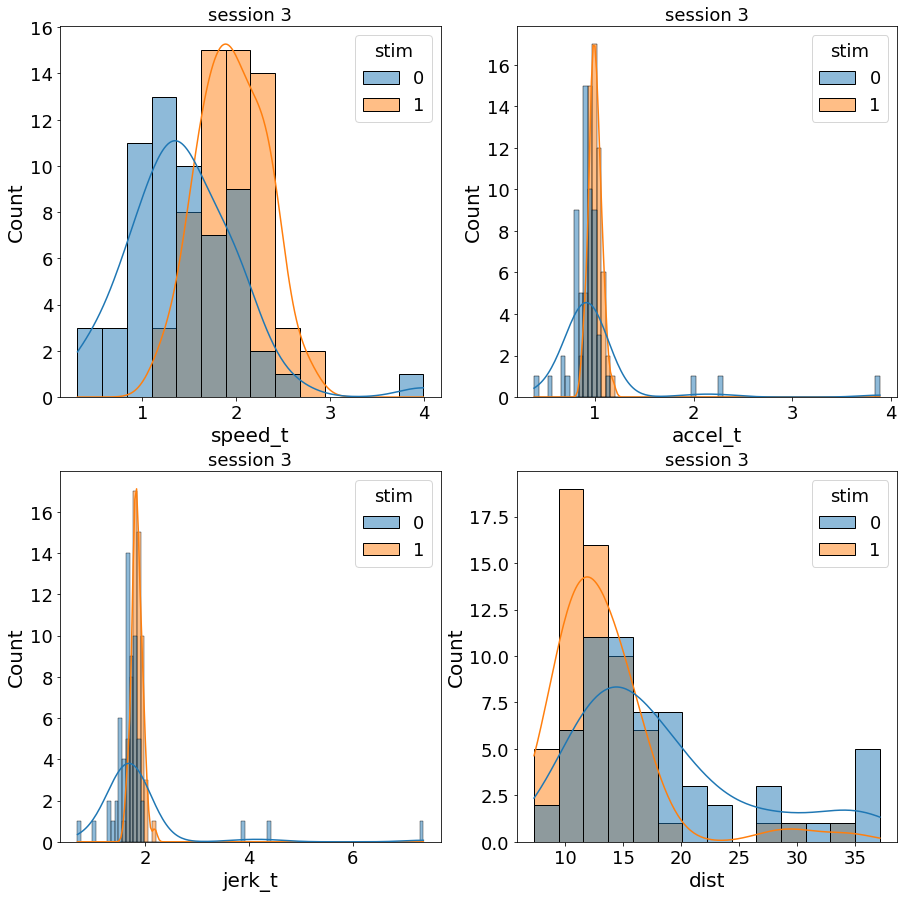

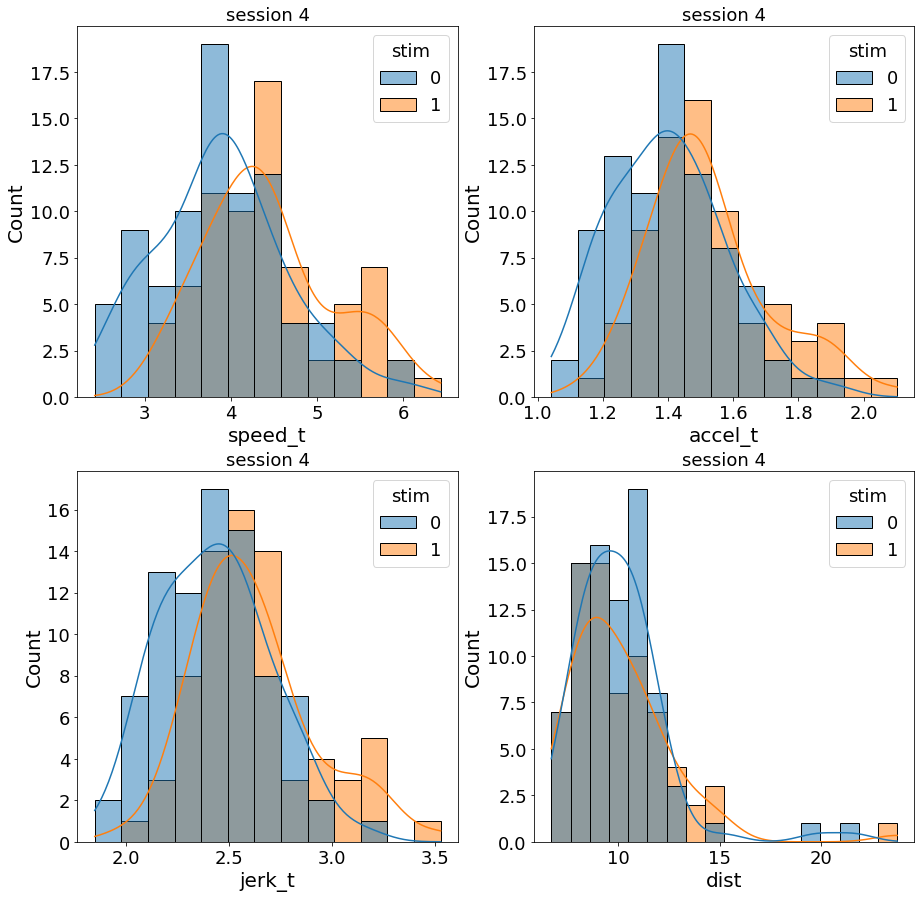

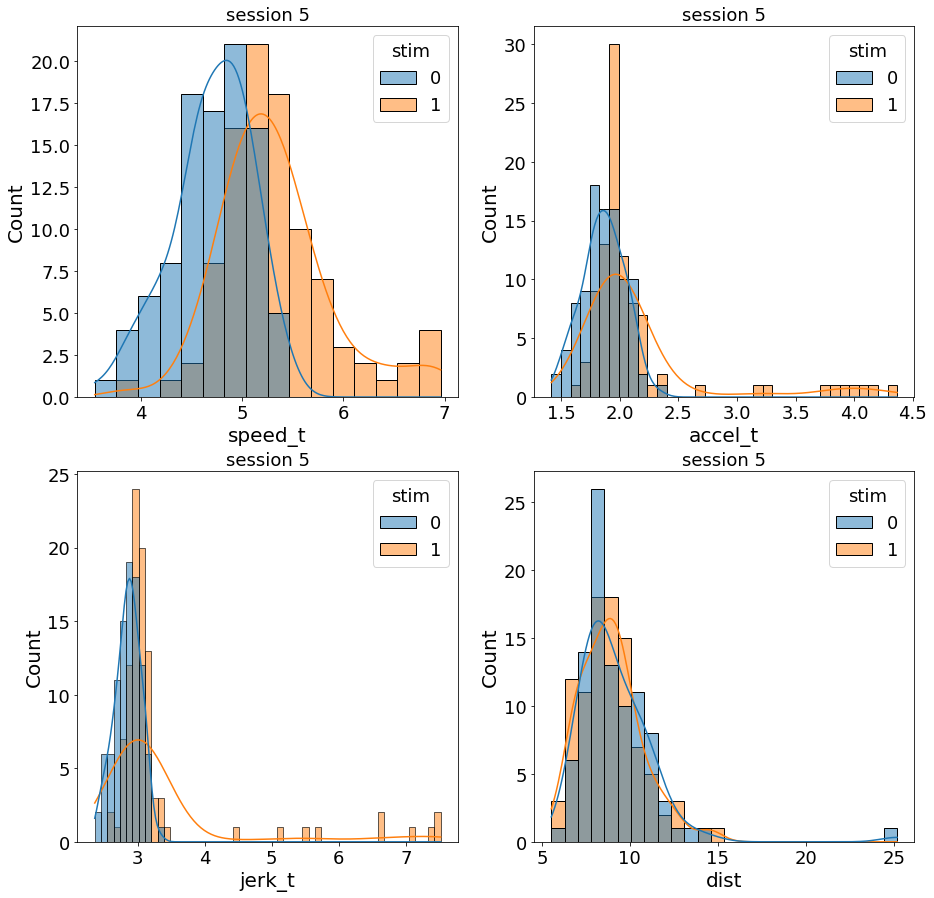

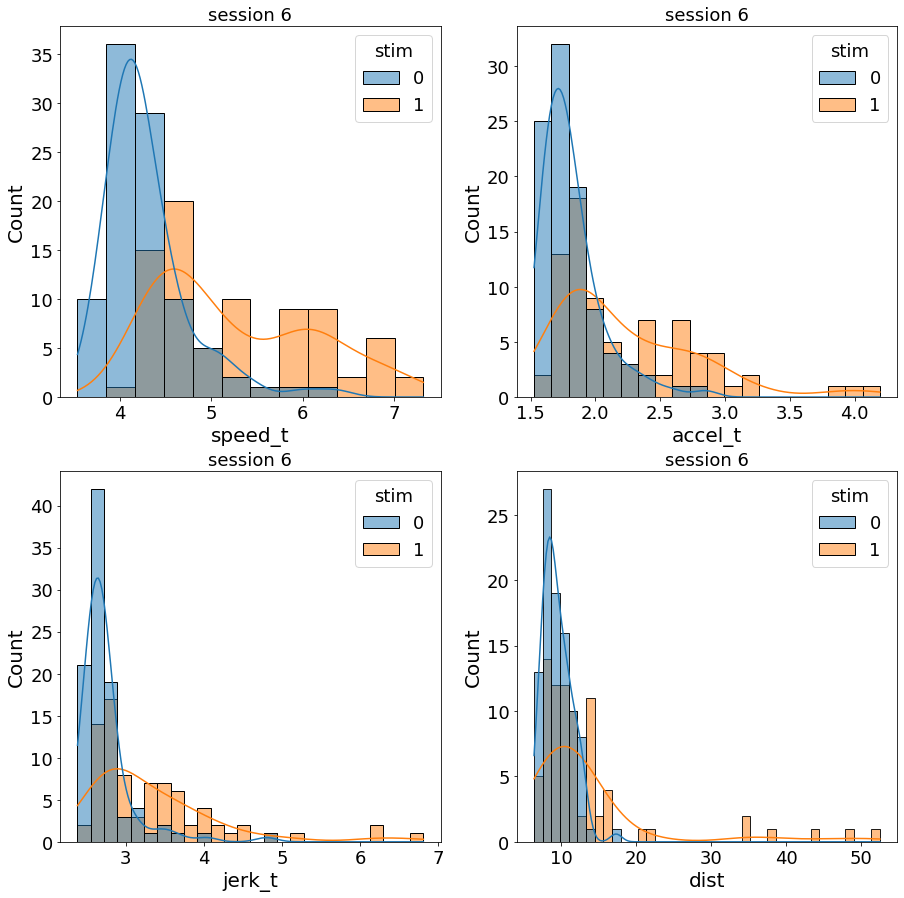

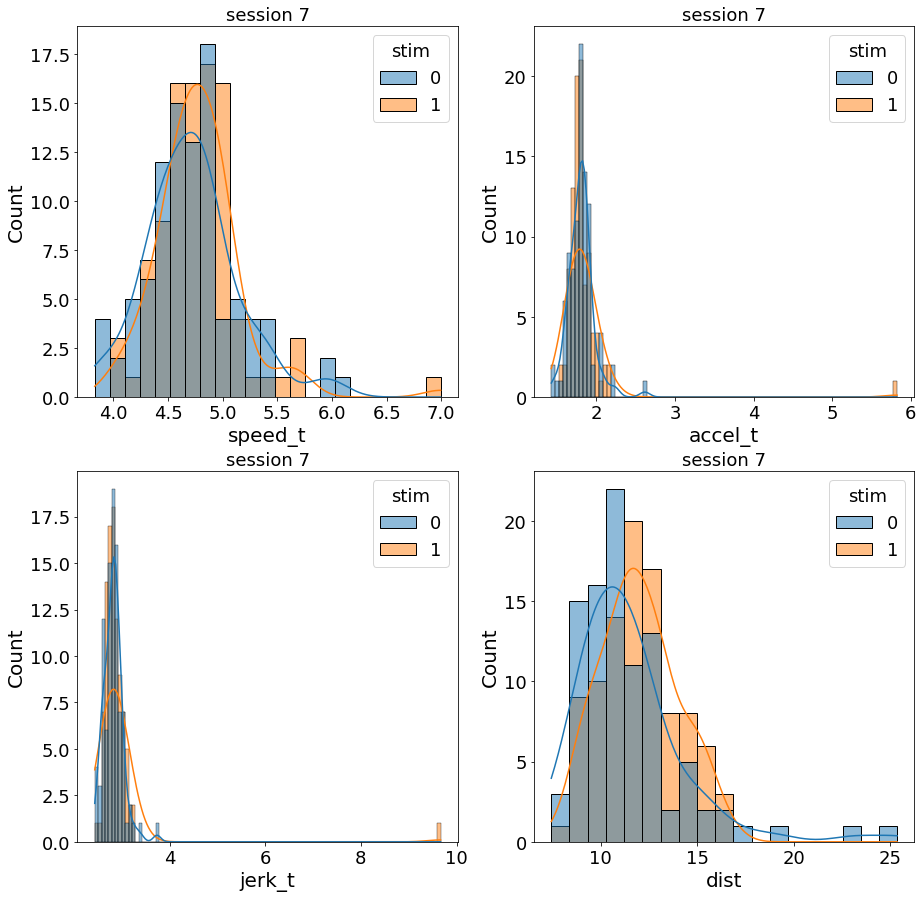

In [37]:
# plot feature distributions of undirected features
for name, group in undirected_df.groupby('session'):
    features = group.drop(['session', 'ix_block', 'ix_trial', 'startTStamp'], axis =1)  
    fig, axs = plt.subplots(2,2, figsize=(15,15))
    axs = axs.ravel()
    for i, column in enumerate(features.columns):
        if column != 'stim':

            sns.histplot(data = features, x=column, hue='stim', kde = True, ax=axs[i-1]).set_title('session ' + str(name))
    plt.show()
    fig.savefig("Undirected session " + str(name) + " features")

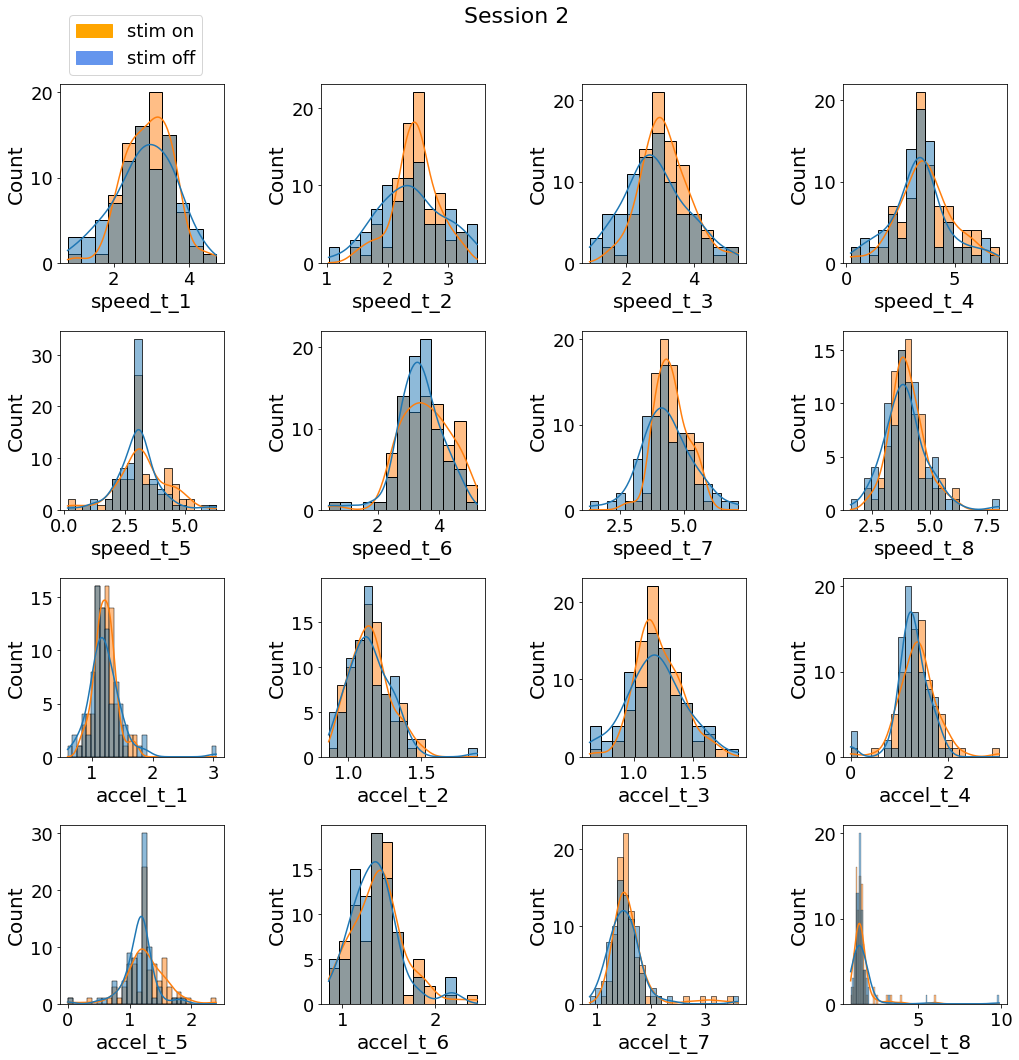

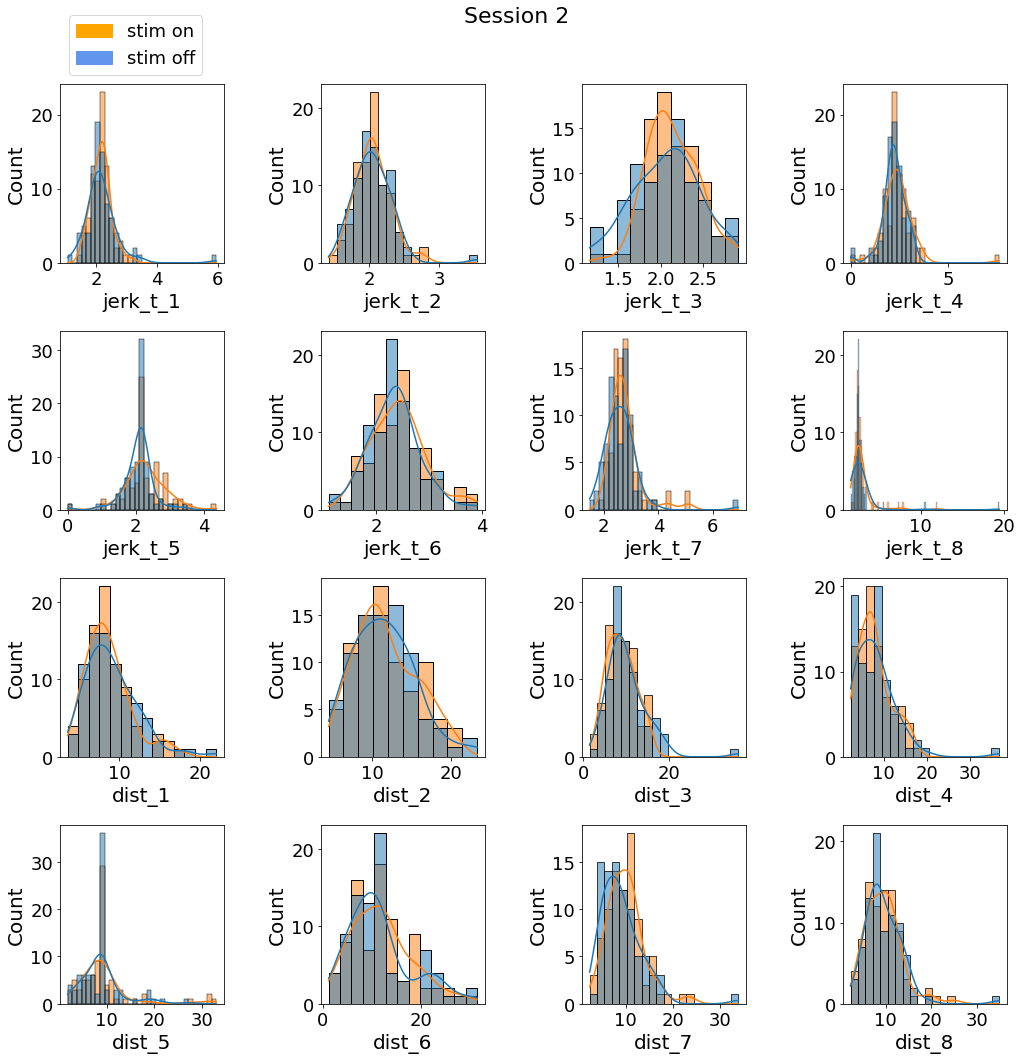

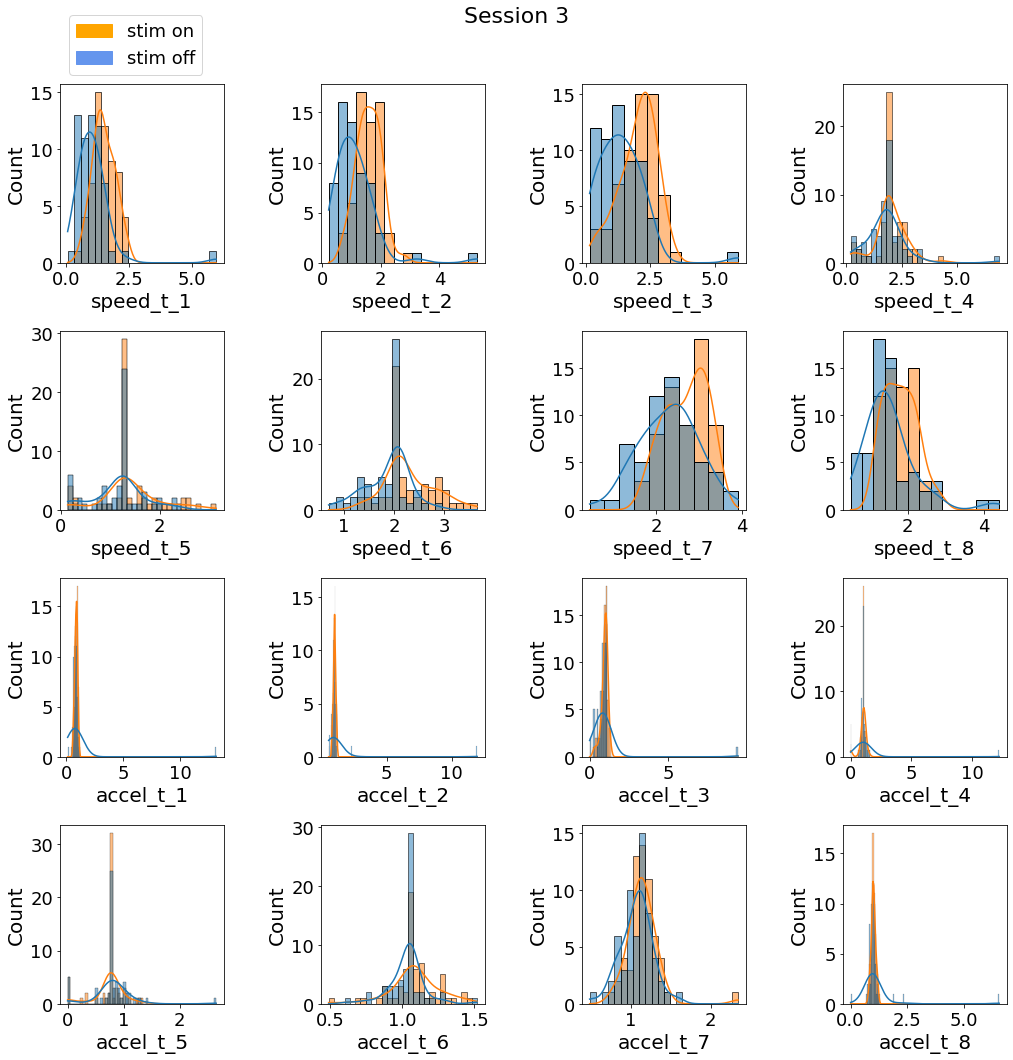

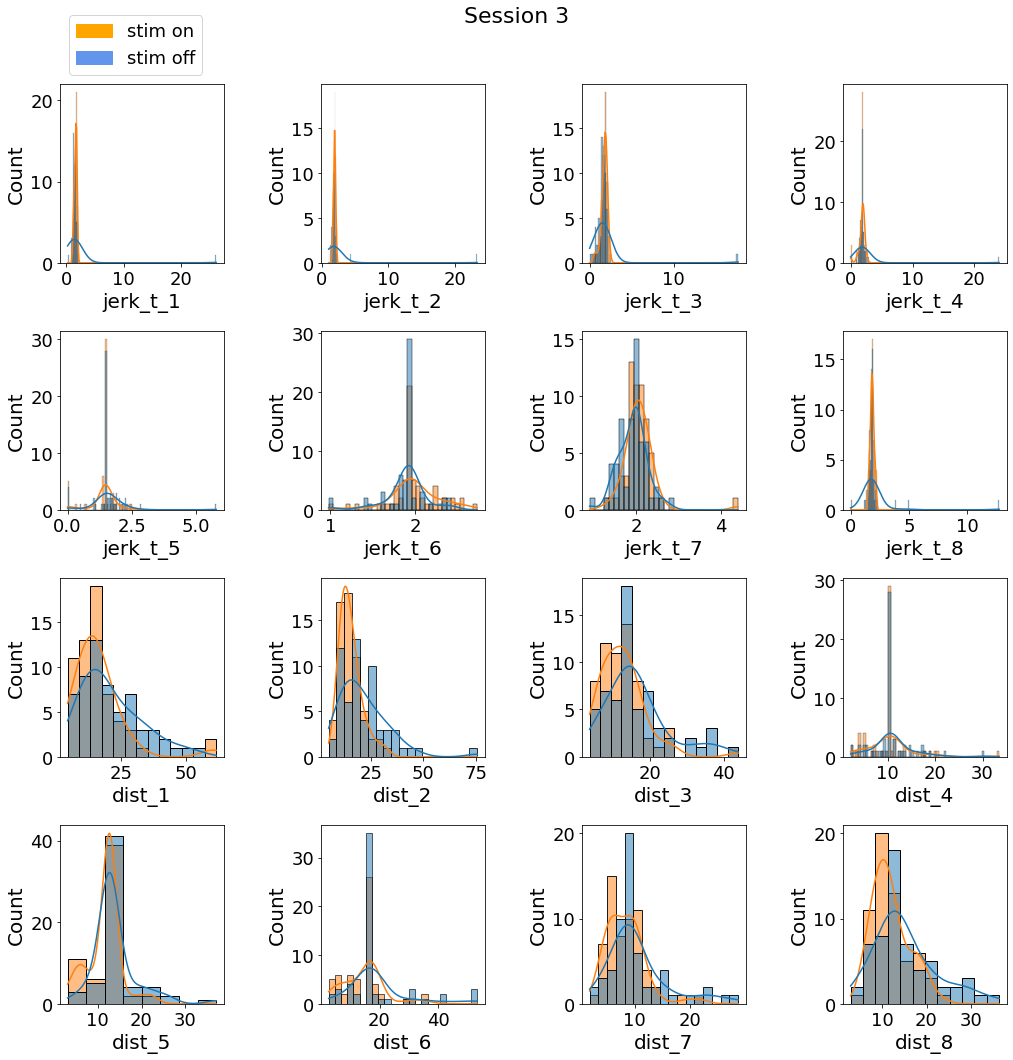

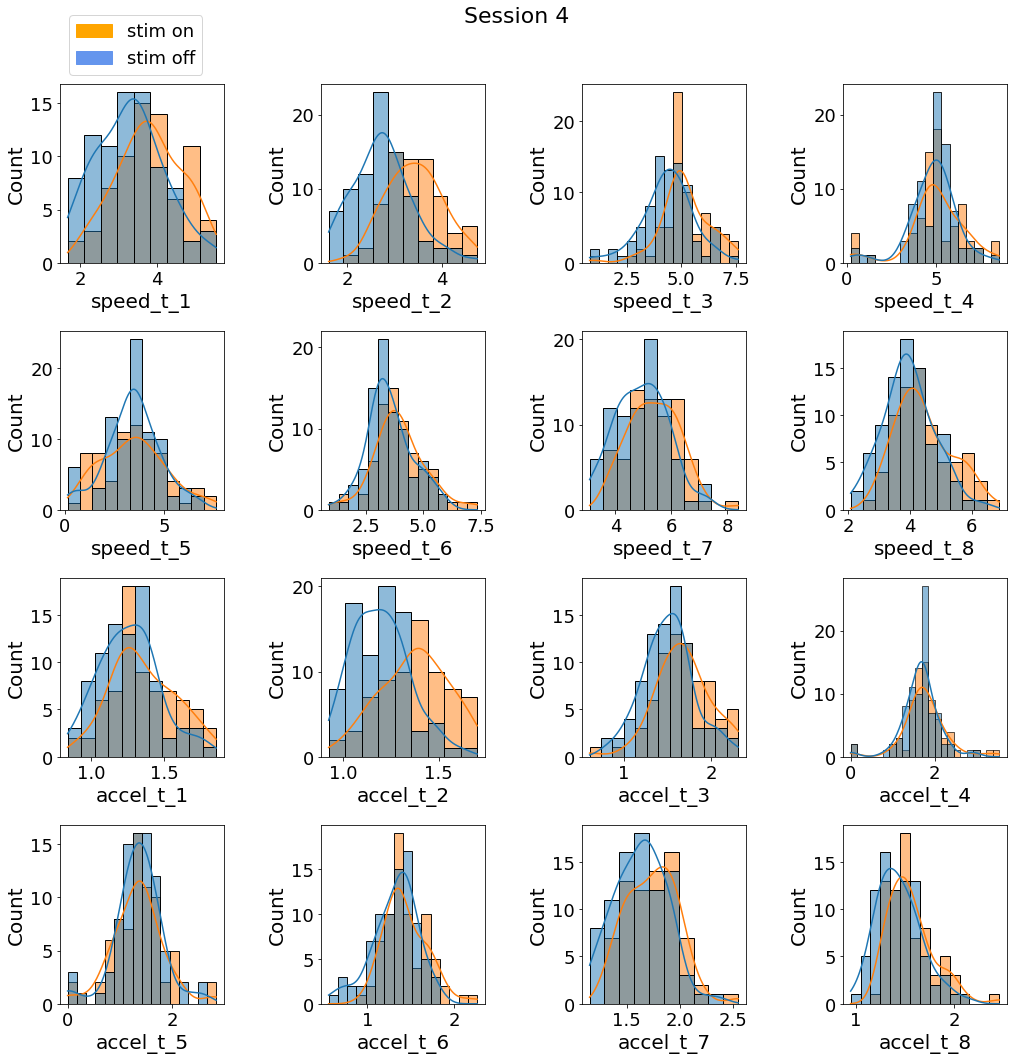

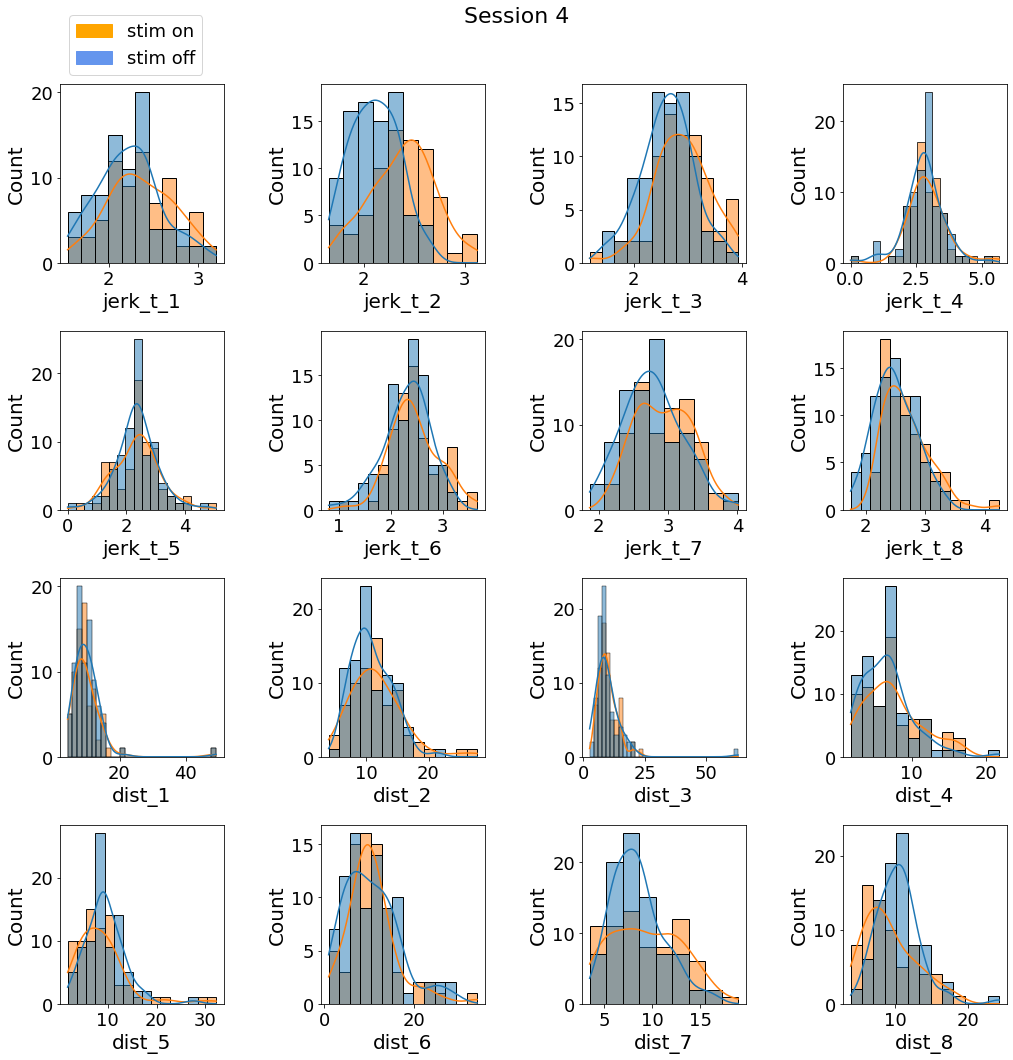

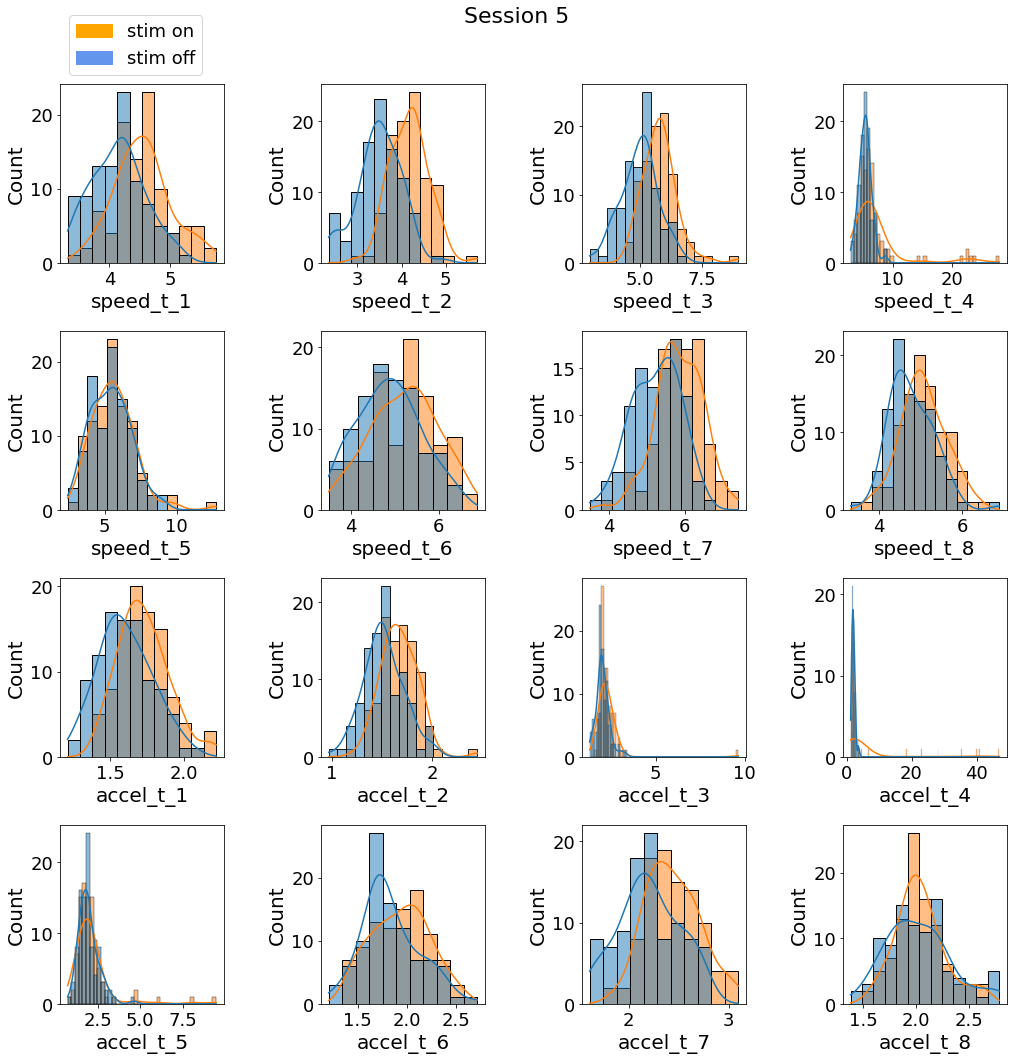

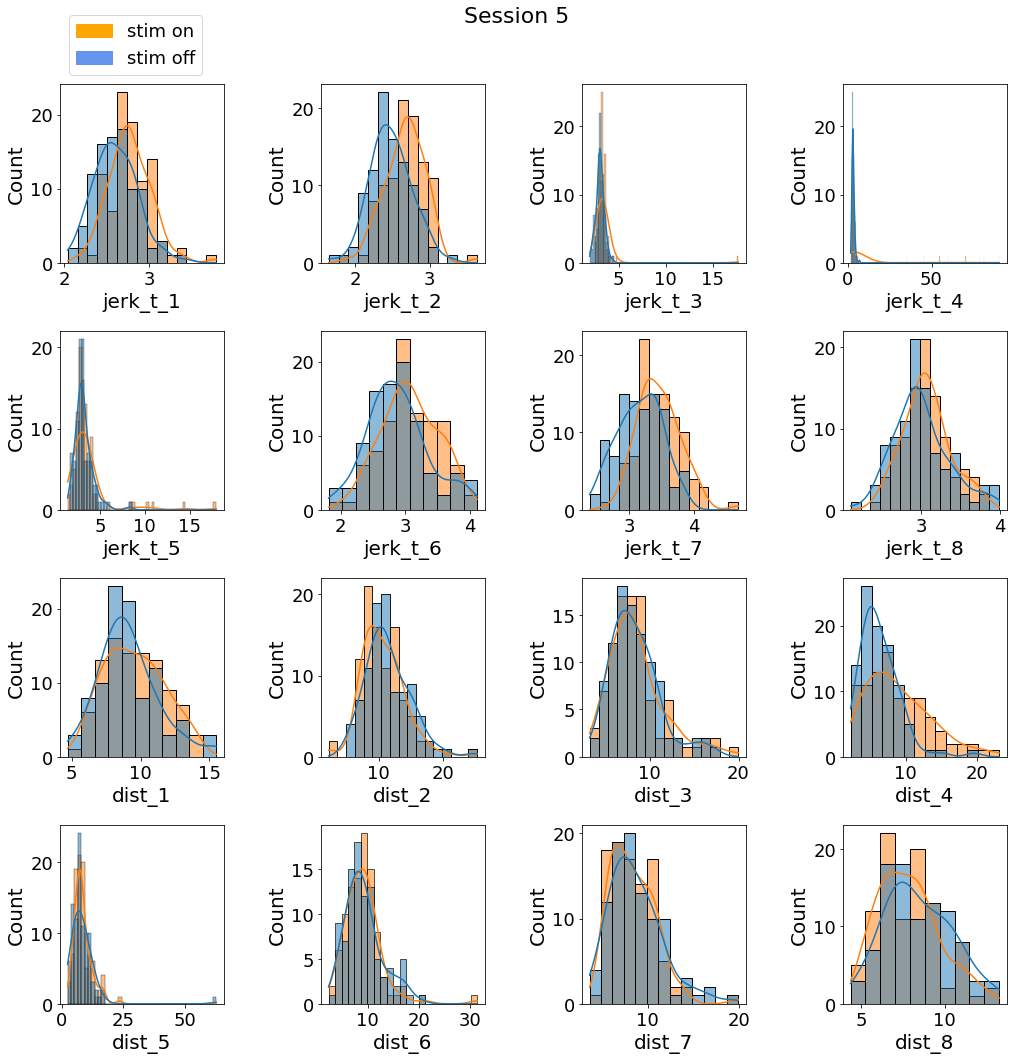

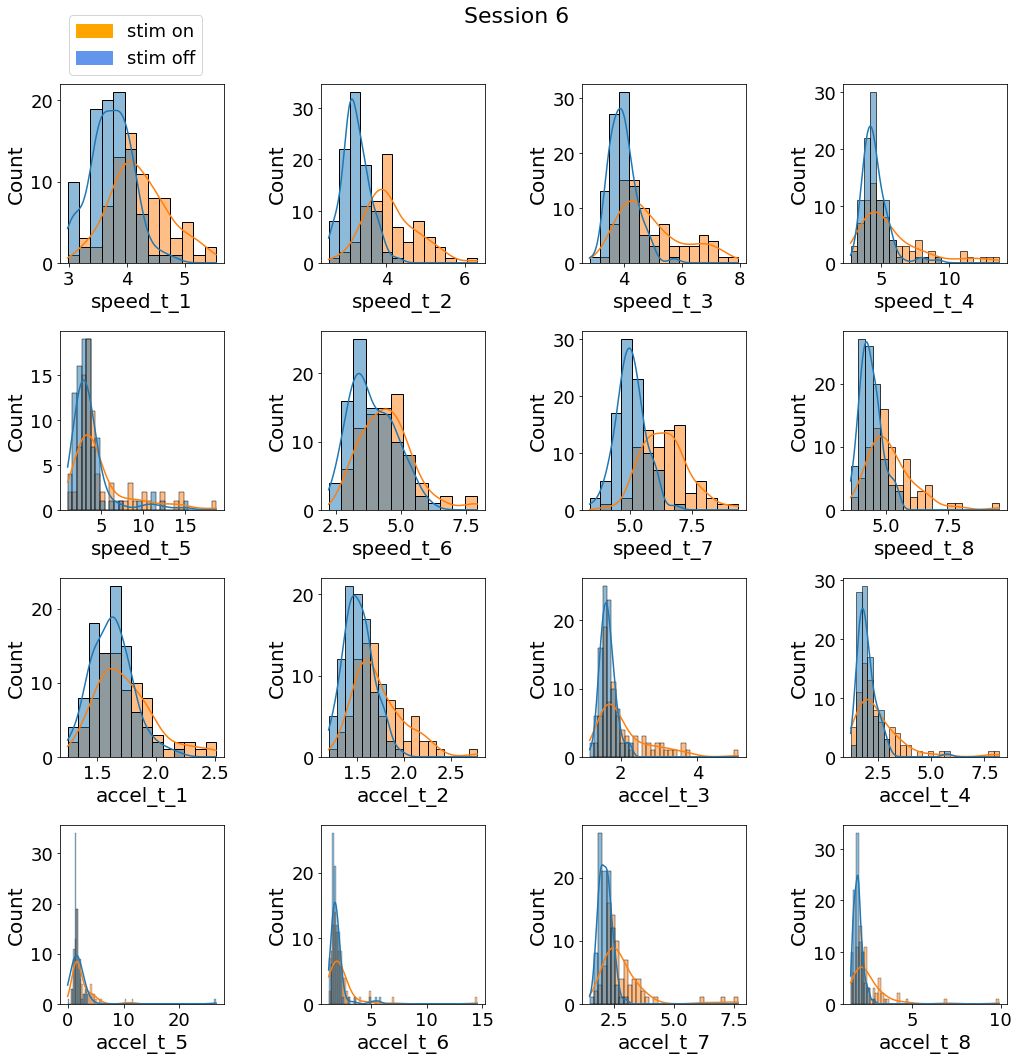

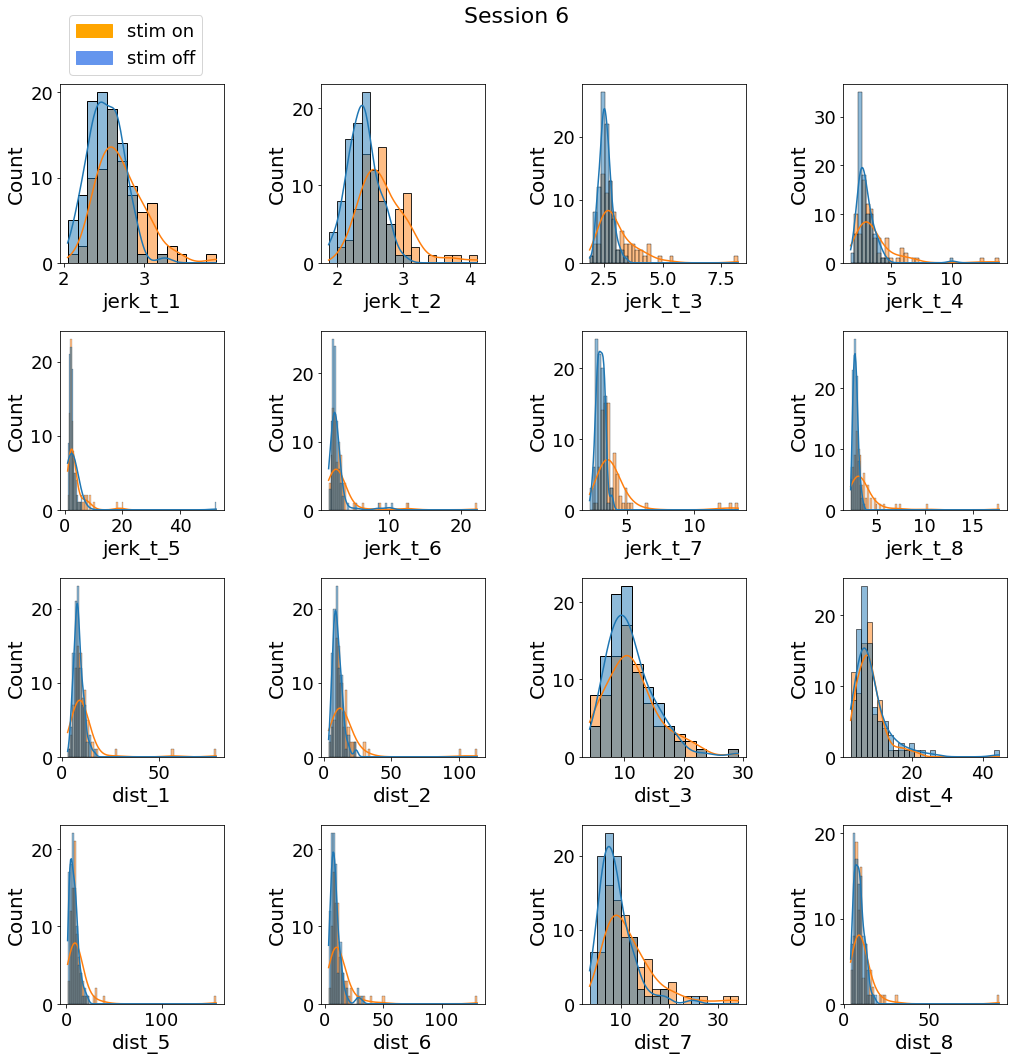

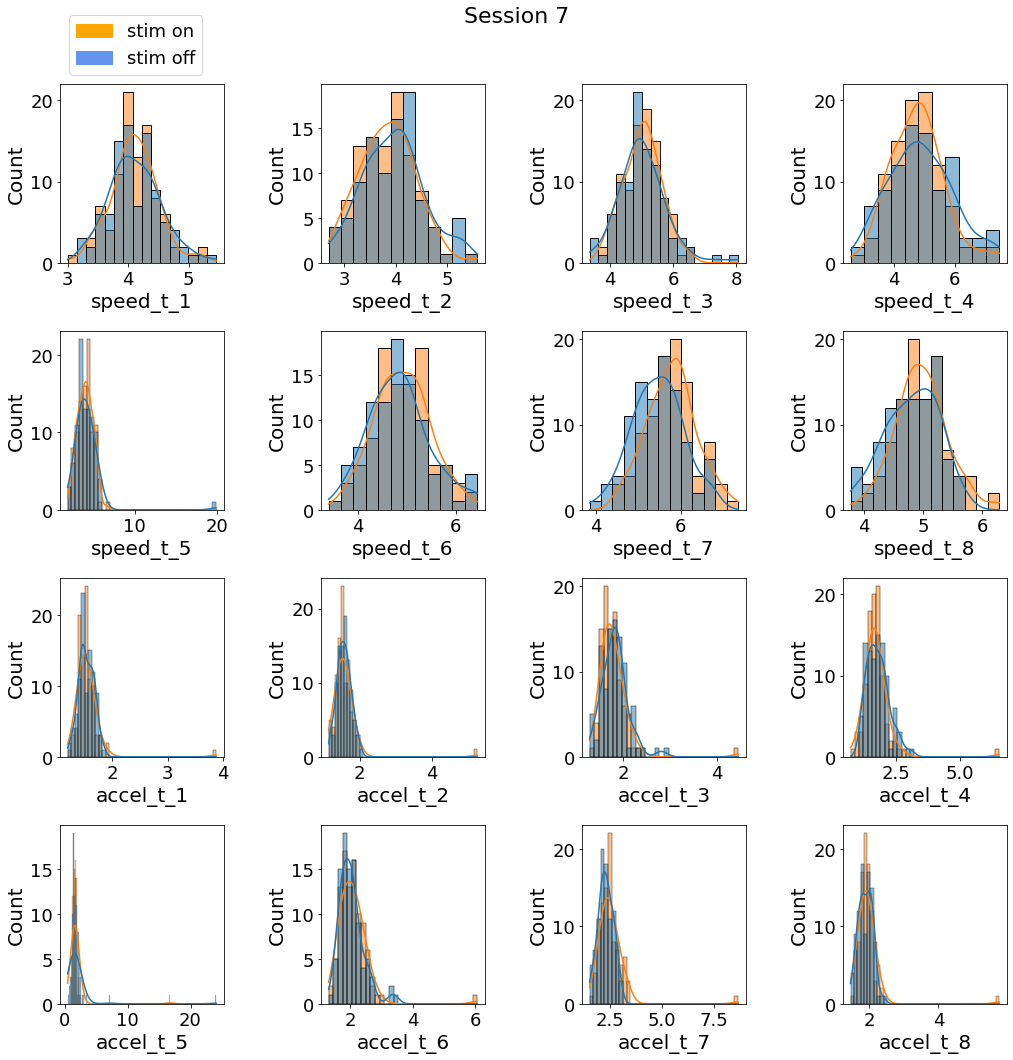

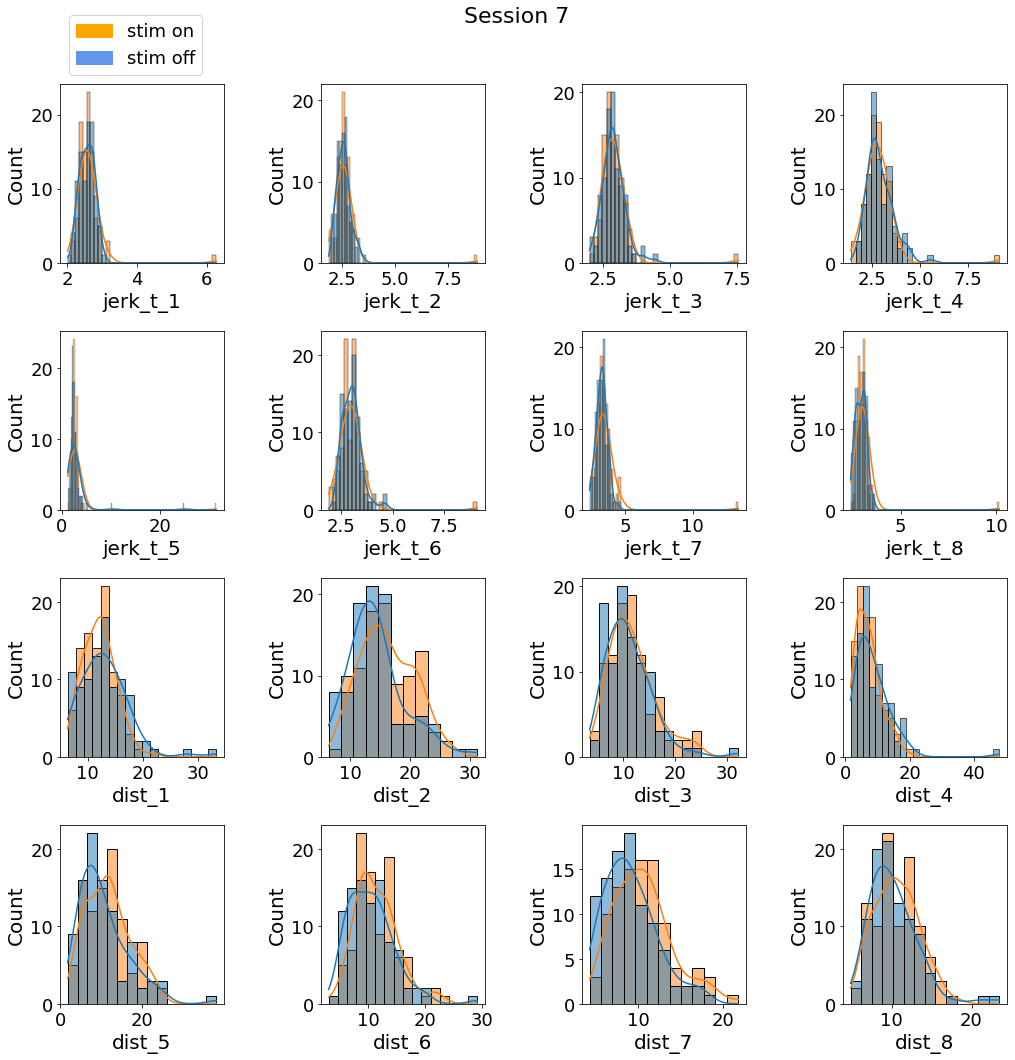

In [47]:
# plot feature distributions of directed features
for name, group in directed_df.groupby('session'):
    features = group.drop(['session', 'ix_block', 'ix_trial', 'startTStamp'], axis =1)
    fig, axs = plt.subplots(4,4, figsize=(15,15))
    fig.suptitle('Session ' + str(name))
    axs = axs.ravel()
    fig.tight_layout(pad=2.0)
    for i in range (17):
        if features.columns[i] != 'stim':            
            sns.histplot(data = features, x=features.columns[i], 
                         hue='stim', kde = True, ax=axs[i-1], legend = False)
    orange_patch = mpatches.Patch(color='orange', label = 'stim on')
    blue_patch = mpatches.Patch(color='cornflowerblue', label = 'stim off')
    axs[0].legend(handles = [orange_patch, blue_patch], bbox_to_anchor=(0, 1), loc='lower left')
    plt.show()
    fig.savefig("session " + str(name) + ' speed and accel.png')
    
    fig, axs = plt.subplots(4,4, figsize=(15,15))
    axs = axs.ravel()
    
    fig.suptitle('Session ' + str(name))
    fig.tight_layout(pad=2.0)
    for i in range (17,33):
        if features.columns[i] != 'stim':            
            sns.histplot(data = features, x=features.columns[i], 
                         hue='stim', kde = True, ax=axs[i-17], legend = False)
    
    axs[0].legend(handles = [orange_patch, blue_patch], bbox_to_anchor=(0, 1), loc='lower left')
    plt.show()
    fig.savefig("session " + str(name) + ' jerk and dist.png')

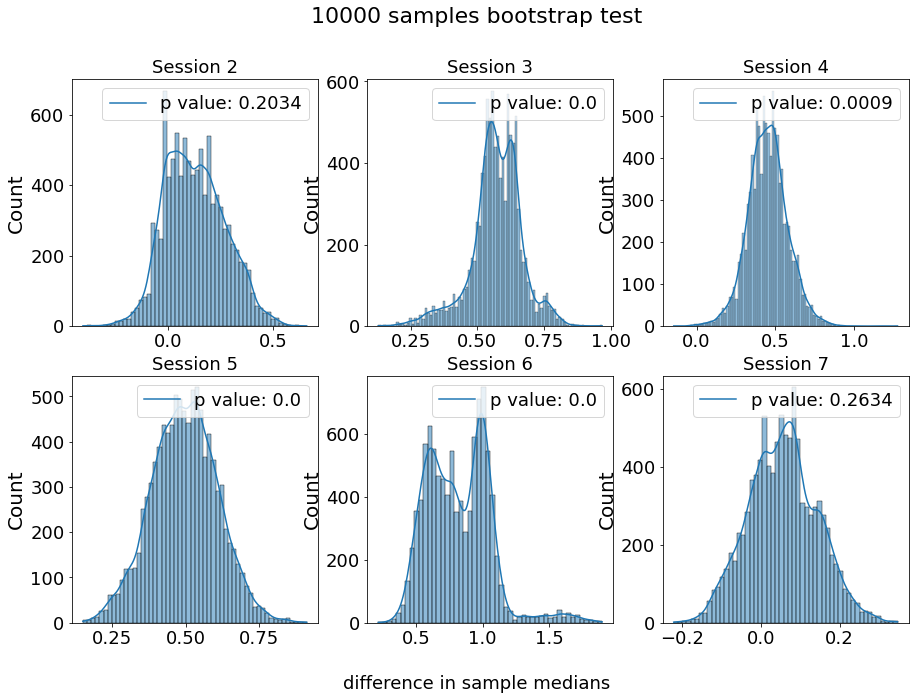

In [48]:
# Carry out randomization test for the difference in medians
import random
fig, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.ravel()
samples = 10000
fig.suptitle(str(samples) + " samples bootstrap test")
fig.text(0.5, 0.04, 'difference in sample medians', ha='center', va='center')

for index, (name, group) in enumerate(undirected_df.groupby('session')):
    
    n = 100    
    differences = []

    for _ in range(samples):
        sample_indexes = random.choices(range(0, len(group)), k = n)
        sample = group.iloc[sample_indexes]
        sample_0 = sample[sample['stim'] == 0]['speed_t']
        sample_1 = sample[sample['stim'] == 1]['speed_t']
        
        median_0 = sample_0.median()
        median_1 = sample_1.median()
        
        differences.append(median_1 - median_0)
    leq_count = sum(i <= 0 for i in differences)
    
    sns.histplot(differences, kde = True, ax=axs[index]).set_title('Session ' +str(name))
    axs[index].legend({"p value: " + str(leq_count/samples)})
fig.savefig('bootstrap_undirected_medians_speed_t')
plt.show()
    